## **Load *Monod*+meK-Means and Packages**

In [614]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/')

In [615]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [616]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import scipy.stats

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

import os

import sklearn
import scanpy as sc
import anndata

import random

In [617]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## **Load Metadata and Select Genes for Inference Across Conditions**

In [618]:
#Load cell barcodes from original study

meta_path = '/home/tchari/metadata/'
data_path = '/home/tchari/counts/cancer_dt/'

In [619]:
orig_bcs = pd.read_csv(meta_path+'home/alex/lab/drugres/10x/D0D3FullSeq/Day3/outs/filtered_feature_bc_matrix/barcodes.tsv',header=None)
orig_bcs.head()


0
0  AAACCCAAGCAGGCAT-1
1  AAACCCAAGCTGCCAC-1
2  AAACCCAAGGCCGCTT-1
3  AAACCCAAGTGACACG-1
4  AAACCCACACTTGGGC-1

In [620]:
#Get full count matrices and barcodes
ds = lp.connect('/home/tchari/counts/cancer_dt/loom/all_cancer_dt.loom')
U = ds.layers['unspliced'][:].T
S = ds.layers['spliced'][:].T
bars = ds.ca['barcode']
g_names = ds.ra['gene_name']
ds.close()

In [ ]:
S.shape

In [621]:
#Select genes to begin with that have enough U/S counts
filt_param={
        "min_U_mean": 0.01,
        "min_S_mean": 0.01,
        "max_U_max": 400,
        "max_S_max": 400,
        "min_U_max": 1,
        "min_S_max": 1,
    }

expr_filt = monod.preprocess.threshold_by_expression(S.T,U.T,
                                                     filt_param) #[:,np.isin(bars,filt_bars)]

INFO:root:7525 genes retained after expression filter.


In [622]:
#Make anndata with conditions and get most variable genes

adata = anndata.AnnData(S[:,expr_filt])
adata.obs_names = [f"Cell_{i:d}" for i in range(adata.n_obs)]
adata.var_names = g_names[expr_filt] #Only look at genes with high enough U/S expression

sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  This is separate from the ipykernel package so we can avoid doing imports until


In [623]:
np.sum(adata.var.highly_variable)

1754

In [514]:
#Literature genes?
#Supp Fig 9

#Study found two populations, 

lit_genes = ['CDH2','COL1A1','CALD1','TGFB2', 'INHBA','INHBB','SERPINE1',
            'LEF1','TEAD1','SRF','FOXO4','FOXF2','FOXA1','ATF','E4F1','MAZ',
            'AP1','SOX9','E2F1','NFY','YY1','TGFB2','WNT5A','CTNNB1','DKK1','CDH2',
            'COL1A1','CALD1','SCD','FASN','FDFT1','LDLR','SQLE','HMGCS1','FADS2',
            'TNFRSF12A','FDPS','IDI1','ANXA5','ACAT2','FABP5','FAM129A','MVD',
            'TRIB3','ACSS2','DHCR7','ALCAM','SREBF2','HSD17B7','CBS',
            'STX5','JAG1','ERRFI1','LSS','ATF3','HMGCR','MAL2','CHKA',
            'MYL9','TAGLN','IGFBP3','TPM1','FSTL1','CALD1','FN1','GADD45A',
            'DAB2','GLIPR1','IL32','INHBA','CYR61','THBS1','MFAP5','SPARC',
            'SAT1','TFPI2','MGP','DKK1','FSTL3','WNT5A','SERPINH1','FERMT2',
            'GPC1','CTGF','TPM4','PDLIM4','ITGB1','SERPINE2','SDC4','CD59',
            'NOTCH2','COL5A1','LAMC1','PLAUR','BDNF','IGFBP3','FN1','CD24',
            'GADD45A','TGFB2','TIMP2','PSAP','CYR61','EDN1','INHBA','THBS1',
            'DUSP1','PINK1','GAS6','GSTP1','PDGFB','CTGF','TPD52L1','CAV2','CAV1',
            'INHBB','IGBP1','DAG1','PTPLAD1','ITGB1','MID1','LYN','PEA15',
            'RIPK2','RNF149','CDC42','PTPN11','EZR','TRIB1','MUC20','KRAS','RRAS',
            'GADD45A','CYR61','EDN1','SAT1','DUSP1','FOS','PNRC1','JUNB','TIPARP',
            'OLR1','F3','IER2','CCND1','CCNL1','NAMPT','TUBB2A','TRIB1','SDC4','BTG3',
            'RIPK2','PTGS2','TGIF1','PLAUR','ID3','SOX4','CYP1B1','KLHL24',
            'GSN','AHNAK2','GRN','HIST1H2AC','HIST1H2BD','HIST1H1C','HEG1','FTH1',
            'HCFC1R1','GLUL','CTSH','BCAM','CALCOCO1','MUC1','ANXA4','EPHX1','YPEL5']

# + Supp Table 1 and 4 from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7379796/#MOESM3 using GTEx NSCLC data
# old_lit_genes = ["GPR68", "VNN1", "IL1A", "PTX3", "SLC37A2", "C1S", "TNFAIP6", "PAX6", "ANXA10", "LOC645638", 
#               "PAQR5", "HAVCR1", "DENND2C", "SLC7A2", "GFPT2", "LOC283050", "ZEB1", "CYP1B1", "COL4A6", "IL4I1", 
#               "ZEB2", "TMEM158", "EMP3", "TM4SF19", "CEP112", "SGK1", "XLOC_003457", "SLC16A1", "CLGN", "AKR1C3", 
#               "ELMOD1", "IL1RAPL1", "FGFR1", "GLIPR1", "CLMP", "LOC100506912", "C11orf96", "IL6", "MMP1", "G0S2", 
#               "SPOCD1", "FLJ31104", "Q952V6", "LOC645722", "ARHGEF4", "DOCK4", "AKR1C1", "COL4A5", "C1R", "GATA6", 
#               "PYGO1", "IL7", "GNG4", "LOC100287314", "CYP1B1-AS1", "ST7-AS1", "CTSC", "TGM2", "CAPN5", "SATB2", 
#               "ITPR1", "WDR19", "MGAT4C", "MGC11082", "RAD21L1", "TPK1", "POLR3G", "XLOC_l2_013513", "LINC00460", 
#               "TIMD4", "TRAF1", "EBI3", "C14orf34", "EPHB3", "FZD8", "BTG2", "FLJ42709", "TMEM233", "TM7SF2", 
#               "HABP2", "PIP", "LOC441956", "CTSH", "GATA5", "B3GALNT1", "ALDOC", "XLOC_002408", "PCDHB14", "ADCY4",
#               "C11orf93", "IGF1", "LOC100505535", "SULT2B1", "PRRG4", "EFEMP1", "EMP2", "LOC100132741", "XLOC_007389",
#               "FGF9", "GALNT5", "FAM153B", "CA11", "CCNI2", "PRINS", "TMEM139", "TMEM61", "APCDD1", "CYP1A1", "FAAH", 
#               "CAPN12", "TRIB2", "SFTPB", "C10orf81", "MB", "KLK4", "AQP3", "TSPAN13", "LOC100505946", "BMP7", 
#               "NOTCH3", "LRCH2", "PPP1R14D", "DNM3", "KRT6A", "NEURL1B", "FAR2", "EPS8L1", "TFAP2D", "LGALS9", 
#               "SPTLC3", "HPGD", "NYNRIN", "COL9A3", "FHL2", "FADS2", "XLOC_010995", "LOC730102", "CEACAM1", "NLRP12", 
#               "FAM153A", "NTM", "CST6", "ADORA1", "TCEA3", "PDE9A", "GJB5", "XLOC_l2_011910", "FRMD3", "IRX4", 
#               "GPR133", "PCDHB11", "PCDHB9", "SYTL1", "BST2", "VSNL1", "ABCA4", "LOC729860", "ARHGAP44", 
#               "XLOC_002771", "JAKMIP2", "MYO1D", "SYTL2", "RASSF10", "KLF13", "XLOC_l2_007543", "FGD3", "SEMA5B", 
#               "MSMB", "PCDHB16", "CRYM", "GCNT3", "ZNF711", "TFF3", "PMEPA1", "SPINK2", "PCDHB8", "MAGIX", "LIMCH1", 
#               "SESN3", "ST6GALNAC2", "C19orf46", "TNFSF10", "CYP2B6", "SYNPO", "FMO5", "GPM6B", "NDN", "XLOC_006350", 
#               "DLL1", "XLOC_001243", "ATP10A", "C14orf159", "ABCA13", "EFHD1", "RASD1", "MFSD4", "CEACAM5", "ZPLD1", 
#               "EPB41L4A", "LOC440335", "PELI2", "SBK1", "FGFBP1", "SLC40A1", "SLC13A3", "ENTPD3", "RORC", "FAM49A", 
#               "PCSK9", "KRTAP4-1", "TMEM125", "LMO3,RIPK3", "CRLF1", "XLOC_l2_009301", "MCF2L", "GPR64", "SLC16A9", 
#               "SLC44A4", "ENPP3", "DENND2A", "ARHGAP4", "NELL1", "C13orf15", "SIDT1", "TSPAN1", "TLE2", "PCDH20", 
#               "MPV17L", "GABBR2", "APOD", "POF1B", "CKMT1A", "NDNF", "ID4", "KLHDC9", "LOC100129480", "SDPR", 
#               "C19orf81", "ICAM2", "KCNMB4", "ATP2C2", "LY75", "PRR15L", "NOSTRIN", "PLEKHG1", "LRRTM1", "C9orf152",
#               "FGF19", "HPN", "ST6GALNAC1", "C17orf28", "DOK7", "KLK7", "RNF43", "NAPSA", "MUC1", "XLOC_008823", 
#               "INPP5D", "DMBT1", "C1orf116", "PRODH", "CYB5R2", "CAPN8", "ERN2", "NEBL", "CST1", "CXCL17", "KAL1",
#               "SYT13", "KLK8", "C2orf54", "TNS4", "KRT4", "NMNAT2", "LOC389023", "RARRES3", "TMC4", "AUTS2", "BCAS1",
#               "PLA2G10", "SPTSSB", "SLITRK6", "VSTM2L", "FAM174B", "ZBED2", "IFI27", "KLK6", "ANO1", "MIR205HG", "RNASE1", 
#               "HOPX", "NPTX2", "SPTB", "CELF2", "CRIP1", "SLCO2A1", "PROC", "AGR2", "SLC34A2", "KLK5", "VTCN1", "CEACAM3", 
#               "PHACTR3", "CEACAM7", "INHBB", "SPOCK2", "CEACAM6", "KRT6A", "MMP12", "GREM1", "AKR1B10", "GJB2", "CXCL13", 
#               "NUF2", "COL11A1", "TPX2", "MMP1", "PBK", "UHRF1", "TTK", "GINS1", "UBE2C", "UBE2T", "ANLN", "CTHRC1", "DLGAP5", 
#               "BUB1B", "TOP2A", "RRM2", "CCNB1", "COL10A1", "FOXM1", "MELK", "CDC20", "PRC1", "CDKN3", "HJURP", "ADAMDEC1", 
#               "KIF4A", "KRT5", "MAGEA6", "FAM64A", "CEP55", "KRT6B", "TUBB2B", "PCP4", "SPP1", "NCAPG", "NEK2", "PSAT1", 
#               "NMU", "KIF20A", "EXO1", "GPR87", "SCG5", "HMMR", "TRIP13", "SPINK1", "RMI2", "DSP", "SLC6A8", "DTL", "SPRR1B", 
#               "KIAA0101", "CKAP2L", "NTS", "PRAME", "RAD51AP1", "S100A2", "KIF2C", "RAD54L", "KIF11", "HS6ST2", "SULF1", "SHCBP1", 
#               "MAD2L1", "CDCA7", "NUSAP1", "GJB6", "PLK1", "KIF14", "FAM83D", "OIP5", "CDCA3", "PYCR1", "MKI67", "NCAPG2", "CENPK", 
#               "KIF15", "CCNA2", "EZH2", "KRT15", "CTSV", "LOC101929272", "PPAP2C", "KRT14", "DEPDC1", "CDC6", "DSG3", "CENPE", 
#               "GALNT14", "CDC45", "E2F8", "HES6", "HMGB3", "KRT16", "RFC4", "DNMT3B", "MDK", "HMGB3P1", "THBS2", 
#               "CST4", "ATAD2", "BIRC5", "EPR1", "GPX2", "DUXAP10", "SPC25", "LOC344887", "CRABP2", "UBE2S", "DEPDC1B", "STIL", 
#               "PITX1", "KIF18B", "UGT8", "MMP3", "C12orf56", "KIF23", "CYP24A1"]

# lit_genes += old_lit_genes

In [624]:
new_gs = list(adata.var_names[adata.var.highly_variable]) #np.unique(lit_genes) #list(adata.var_names[adata.var.highly_variable])+

In [625]:
g_filt = np.isin(g_names,new_gs)

In [626]:
#Genes need to be in annotation
annots=pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',delim_whitespace=True,header=None)
print(annots.head())

annot_filt = np.isin(g_names,list(annots[0]))

       0      1    2   3   4   5   6   7   8   9   ...  39  40  41  42  43  \
0    TNMD  14950   48  23  10   5   2   2   2   2  ...   0   0   0   0   0   
1    DPM1  23689   98  38  25  17  10   6   5   5  ...   0   0   0   0   0   
2   SCYL3  44637  132  51  20  13   9   7   6   4  ...   0   0   0   0   0   
3  TSPAN6  12884   43  18  13   8   3   2   2   1  ...   0   0   0   0   0   
4     FGR  23122   41  18   8   4   1   1   1   1  ...   0   0   0   0   0   

   44  45  46  47  48  
0   0   0   0   0   0  
1   0   0   0   0   0  
2   0   0   0   0   0  
3   0   0   0   0   0  
4   0   0   0   0   0  

[5 rows x 49 columns]


In [627]:
final_filt = g_filt & expr_filt & annot_filt

In [628]:
print('No. selected genes: '+str(np.sum(final_filt)))

No. selected genes: 1749


In [629]:
np.sum([i in g_names[final_filt] for i in lit_genes])

66

## **Set up Files for Inference and Select Cell Barcodes**

In [630]:
ks = [1]*4+[5,10,15] #1s = subsamples of data for fitting technical params, other K options for meK-Means
num_ks = len(ks) #Number of Ks to try

In [631]:
#Set  up output file names for inference run results

#Make names for each of the K runs
runs = ['run'+str(i) for i in range(len(ks))]
clus_names = ['k'+str(run_k)+'_'+r for run_k,r in zip(ks,runs)]

#Output file names
dataset_names = ['meK_cancer_dt_'+y  for y in clus_names]
print('Runs: ',dataset_names)

Runs:  ['meK_cancer_dt_k1_run0', 'meK_cancer_dt_k1_run1', 'meK_cancer_dt_k1_run2', 'meK_cancer_dt_k1_run3', 'meK_cancer_dt_k5_run4', 'meK_cancer_dt_k10_run5', 'meK_cancer_dt_k15_run6']


In [632]:
#Set reference data filepaths
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

#Attribute names in loom file, same as in standard kallisto|bustools --lamanno output
attribute_names=[('unspliced','spliced'),'gene_name','barcode']

loom_filepaths = ['/home/tchari/counts/cancer_dt/loom/all_cancer_dt.loom']*num_ks #All runs use the same loom file
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

loom_filepaths:  ['/home/tchari/counts/cancer_dt/loom/all_cancer_dt.loom', '/home/tchari/counts/cancer_dt/loom/all_cancer_dt.loom', '/home/tchari/counts/cancer_dt/loom/all_cancer_dt.loom', '/home/tchari/counts/cancer_dt/loom/all_cancer_dt.loom', '/home/tchari/counts/cancer_dt/loom/all_cancer_dt.loom', '/home/tchari/counts/cancer_dt/loom/all_cancer_dt.loom', '/home/tchari/counts/cancer_dt/loom/all_cancer_dt.loom']


Filter cell barcodes

Select random subsamples of cells for determining technical/sampling params

In [633]:
l_o_bcs = list(orig_bcs[0])
len_bcs = len(l_o_bcs)

bcs_for_filt = [random.sample(l_o_bcs,int(len_bcs/3)), 
                random.sample(l_o_bcs,int(len_bcs/3)), 
                random.sample(l_o_bcs,int(len_bcs/3)), 
                random.sample(l_o_bcs,int(len_bcs/3))]+[l_o_bcs]*3 #for the k meK-Means runs, keep all barcodes

Dataset meK_cancer_dt_k1_run0. 
	11662 barcodes in loom, 10468 pass filter. 11914 in annotations; of these, 11576 in loom and 10468 in filtered loom.
3971 cells in annotations. 3854 in loom. 3490 pass filter.
Dataset meK_cancer_dt_k1_run1. 
	11662 barcodes in loom, 10468 pass filter. 11914 in annotations; of these, 11576 in loom and 10468 in filtered loom.
3971 cells in annotations. 3872 in loom. 3514 pass filter.
Dataset meK_cancer_dt_k1_run2. 
	11662 barcodes in loom, 10468 pass filter. 11914 in annotations; of these, 11576 in loom and 10468 in filtered loom.
3971 cells in annotations. 3867 in loom. 3497 pass filter.
Dataset meK_cancer_dt_k1_run3. 
	11662 barcodes in loom, 10468 pass filter. 11914 in annotations; of these, 11576 in loom and 10468 in filtered loom.
3971 cells in annotations. 3867 in loom. 3501 pass filter.
Dataset meK_cancer_dt_k5_run4. 
	11662 barcodes in loom, 10468 pass filter. 11914 in annotations; of these, 11576 in loom and 10468 in filtered loom.
11914 cells in

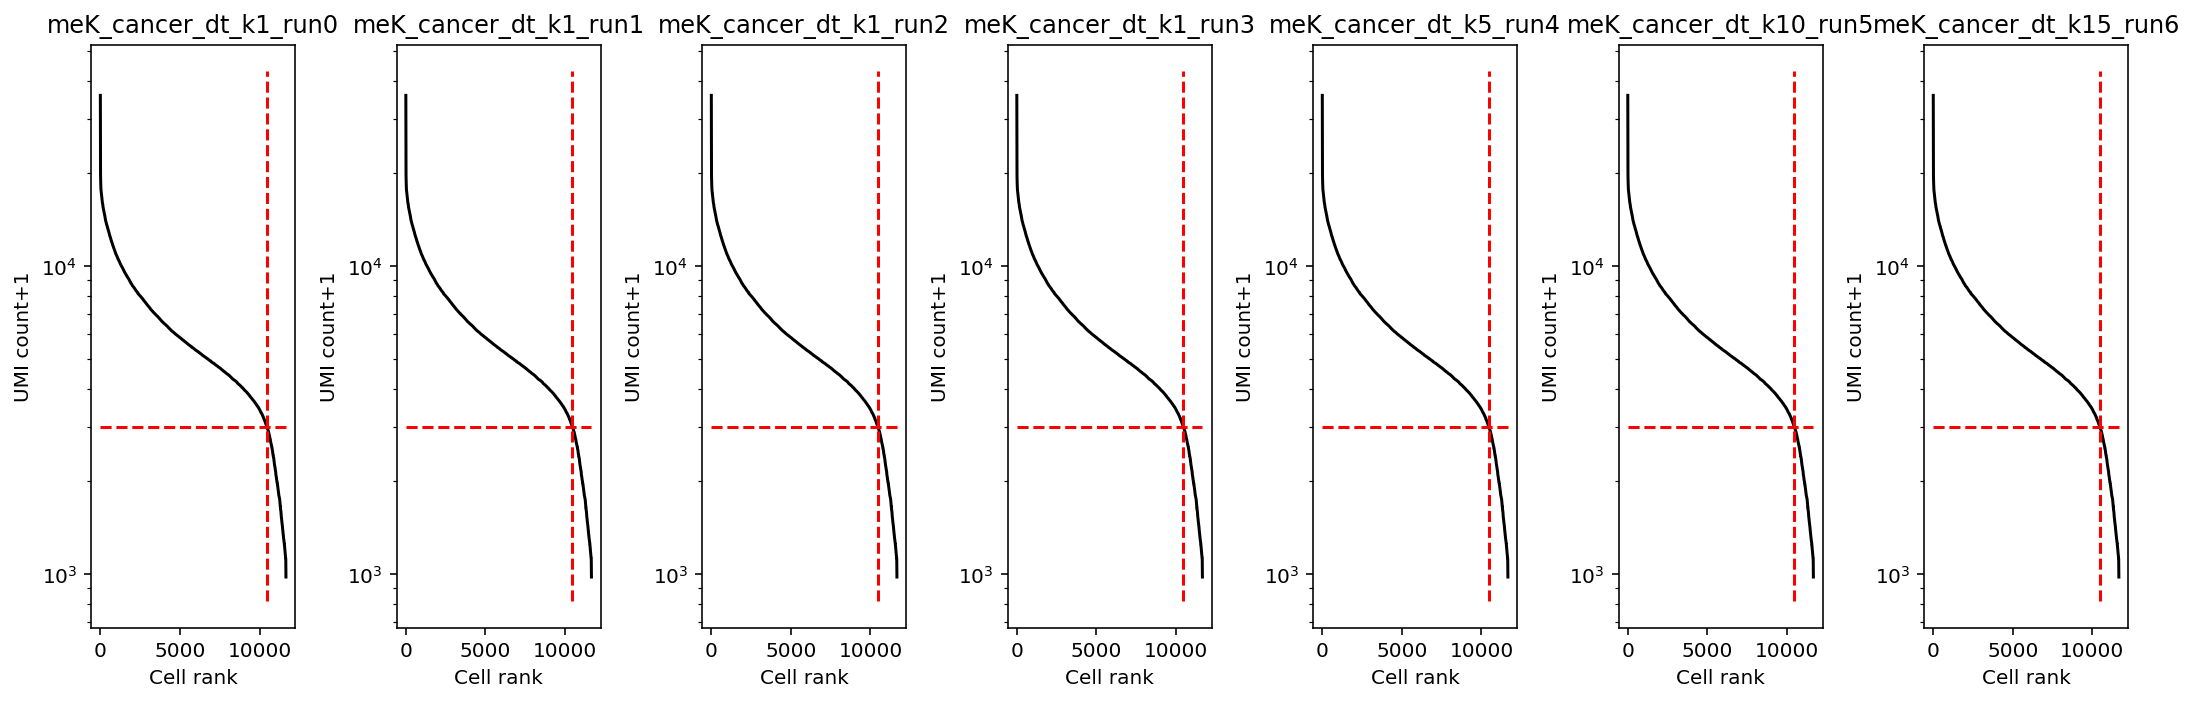

In [634]:
#Filter for cell barcodes with reasonable UMI threshold, and filter for cells in selected conditions
cf = []
thr_lb = [3e3]*num_ks #4e3,Set UMI count filter for each K run

fig1,ax1 = plt.subplots(1,num_ks,figsize=(15,5))

bcs = bars
n_cells = S.shape[0]


for k in range(num_ks):
    filename = loom_filepaths[k]
    dataset_name = dataset_names[k]


    #Make knee plot with S+U counts
    monod.preprocess.knee_plot(S.T+U.T,ax1[k],viz=True,thr=thr_lb[k])
    cf_ = ((S.T+U.T).sum(0)>thr_lb[k])

    #Make filter for low count barcodes
    n_annot_bcs = len(orig_bcs[0])
    annot_bcs_in_loom = orig_bcs[0].isin(bcs).sum()
    annot_bcs_in_filt_loom = orig_bcs[0].isin(bcs[cf_]).sum()
    print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')

    #Select for barcodes in selected conditions, if applicable
    annot_bcs = bcs_for_filt[k] #Filter for subset of barcodes
    cf.append(np.isin(bcs,annot_bcs) & cf_)
    print(f'{len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')


    ax1[k].set_title(dataset_name)

!mkdir ./figs
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_cancer_dt_meK.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

## **Create Output Files and Run meK-Means**

In [635]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [636]:
!mkdir ./fits

mkdir: cannot create directory ‘./fits’: File exists


### **Run *Monod* First on Data Subsamples to get Global, Sampling Parameters**

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230922_025_tech_cancer_dt_1 already exists.
INFO:root:Dataset: meK_cancer_dt_k1_run0
INFO:root:3476 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:911 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run0 already exists.
INFO:root:Dataset: meK_cancer_dt_k1_run1
INFO:root:3480 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:982 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run1 already exists.
INFO:root:Dataset: meK_cancer_dt_k1_run2
INFO:root:3495 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:944 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230922_025_tec

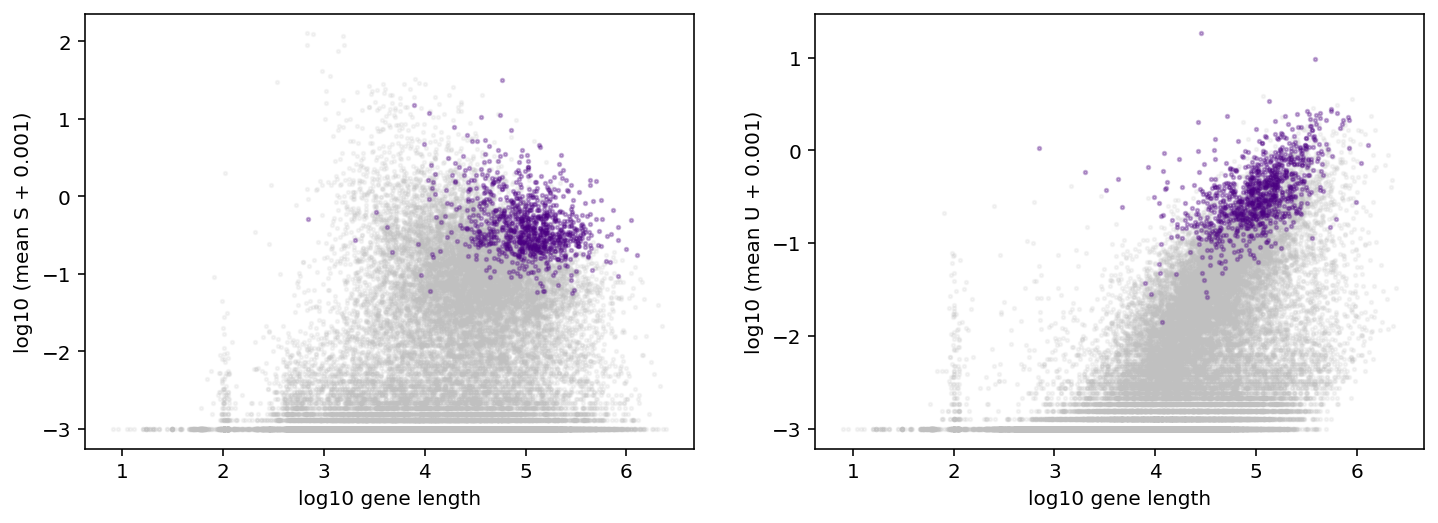

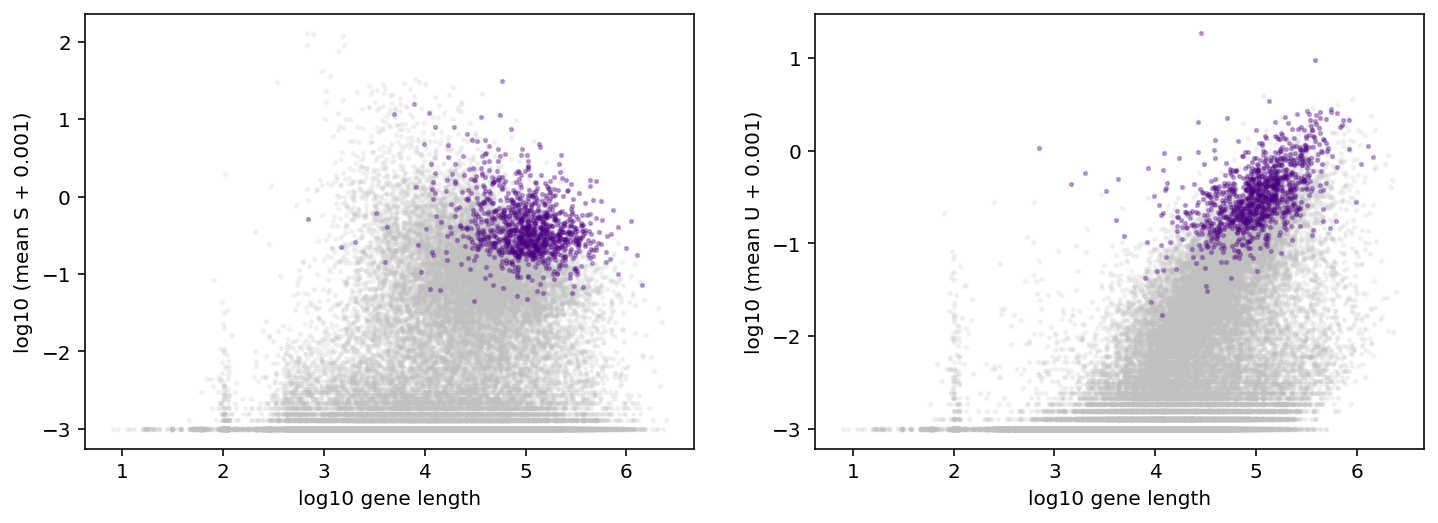

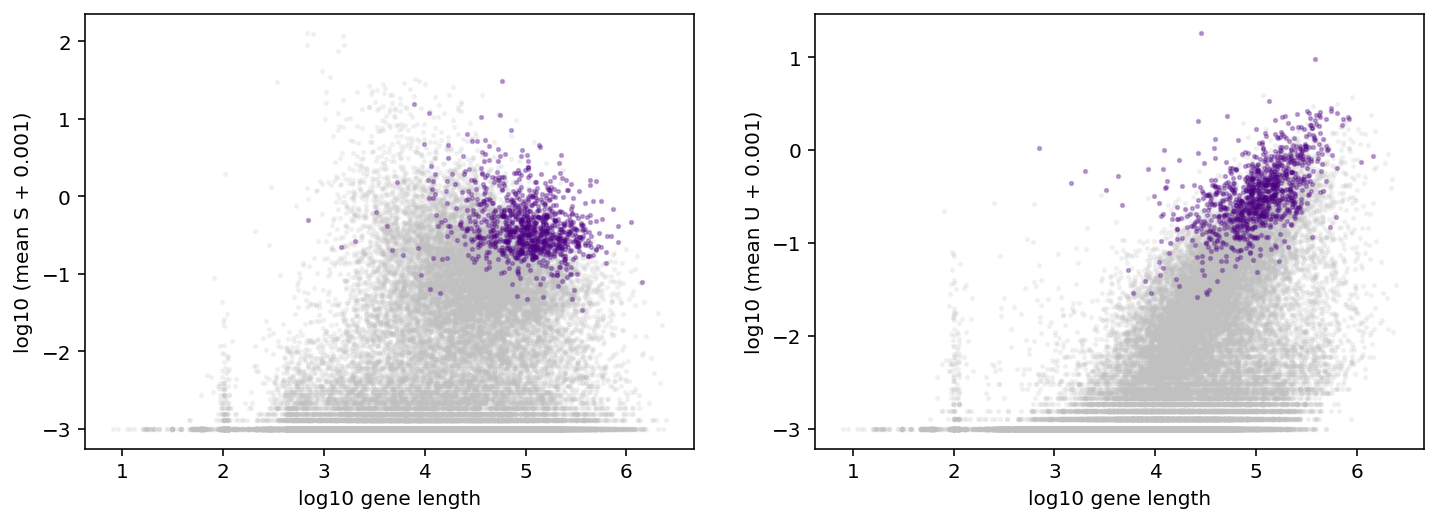

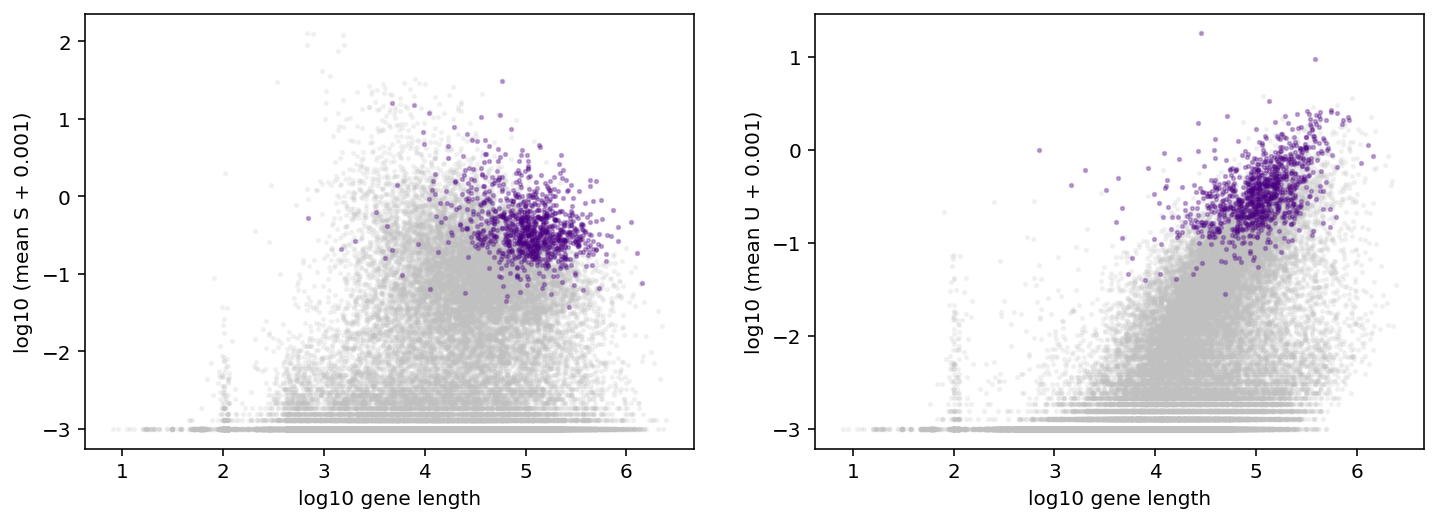

In [527]:
#Select to run inference on, same genes selected across all runs
#Selects for 1k high expression, less variable genes
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths[0:4], \
                                             transcriptome_filepath, \
                                             dataset_names[0:4], \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='tech_cancer_dt',batch_id=1,\
                                             datestring='230922', n_genes=1000,\
                                             exp_filter_threshold=None,cf=cf) 


In [528]:
#Set bounds from physical parameters search space
#Define bounds
phys_lb = [-2.0, -1.8, -1.8 ] 
phys_ub = [4.2, 2.5, 2.5] 
samp_lb = [-9, -4] 
samp_ub = [-4, 1.5] 

gridsize = [20,21]

In [529]:
result_strings = []
for i in range(4): #Only the first four runs here

    #Define model with bursty transcription and Poisson molecule capture/sampling
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    #Set up mminference parameters
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

    #Read in loom file with filtered barcodes
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])

    #Run inference(fit_all_grid_points()) and Save result file strings
    full_result_string = inference_parameters.fit_all_grid_points(30,search_data) 

    result_strings.append(full_result_string)
    
    

INFO:root:Directory ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run0/Bursty_Poisson_20x21 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run0/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: meK_cancer_dt_k1_run0
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:Gene list extracted from ./fits/gg_230922_025_tech_cancer_dt_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run0/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [08:53<00:00,  1.27s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run0/Bursty_Poisson_20x21/analysis_figures already exists.
INFO:root:Runtime: 537.9 seconds.
INFO:root:Directory ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run1/Bursty_Poisson_20x21 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run1/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: meK_cancer_dt_k1_run1
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:Gene list extracted from ./fits/gg_230922_025_tech_cancer_dt_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run1/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [09:15<00:00,  1.32s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run1/Bursty_Poisson_20x21/analysis_figures already exists.
INFO:root:Runtime: 560.2 seconds.
INFO:root:Directory ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run2/Bursty_Poisson_20x21 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run2/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: meK_cancer_dt_k1_run2
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:Gene list extracted from ./fits/gg_230922_025_tech_cancer_dt_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run2/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [09:09<00:00,  1.31s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run2/Bursty_Poisson_20x21/analysis_figures already exists.
INFO:root:Runtime: 553.9 seconds.
INFO:root:Directory ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run3/Bursty_Poisson_20x21 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run3/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: meK_cancer_dt_k1_run3
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:Gene list extracted from ./fits/gg_230922_025_tech_cancer_dt_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run3/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [09:11<00:00,  1.31s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run3/Bursty_Poisson_20x21/analysis_figures already exists.
INFO:root:Runtime: 556.3 seconds.


In [530]:
result_strings = [i+'/Bursty_Poisson_20x21/grid_scan_results.res' for i in np.array(dataset_strings)[0:4]]
print(result_strings[0])

./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run0/Bursty_Poisson_20x21/grid_scan_results.res


**Look at Values of 'Optimal' Sampling Parameters - for Each Subsample of Cells**

INFO:root:Grid scan results loaded from ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run0/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run0/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run0/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run0/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 7 genes out of 1000. Runtime: 1.9 seconds.
INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run0/Bursty_Poisson_20x21/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run0/Bursty_Poisson_20x21/analysis_figures/subsampling_stability.png.
INFO:root:Original o

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run0/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run0/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_230922_025_tech_cancer_dt_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run1/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run1/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run1/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run1/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run1/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run1/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_230922_025_tech_cancer_dt_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run2/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run2/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run2/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run2/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run2/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.


/home/tchari/monod/src/monod/inference.py:1003: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots(nrows=1, ncols=num_params, figsize=figsize)


INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run2/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_230922_025_tech_cancer_dt_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run3/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run3/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run3/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run3/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 11 genes out of 1000. Runtime: 1.9 seconds.
INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_can

/home/tchari/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run3/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4154: RuntimeWarning: overflow encountered in double_scalars
  fac1 = a / np.pi * np.exp(gamma)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4154: RuntimeWarning: overflow encountered in exp
  fac1 = a / np.pi * np.exp(gamma)


INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run3/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_230922_025_tech_cancer_dt_1/analysis_figures already exists.


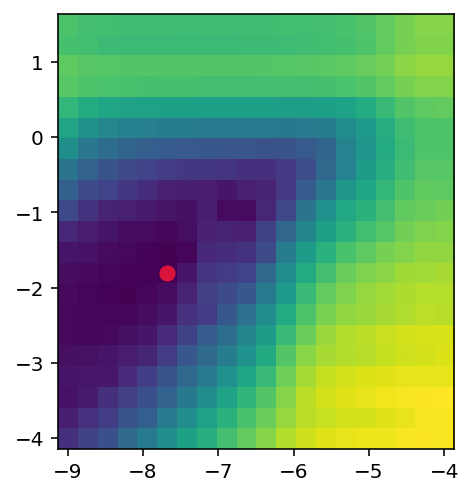

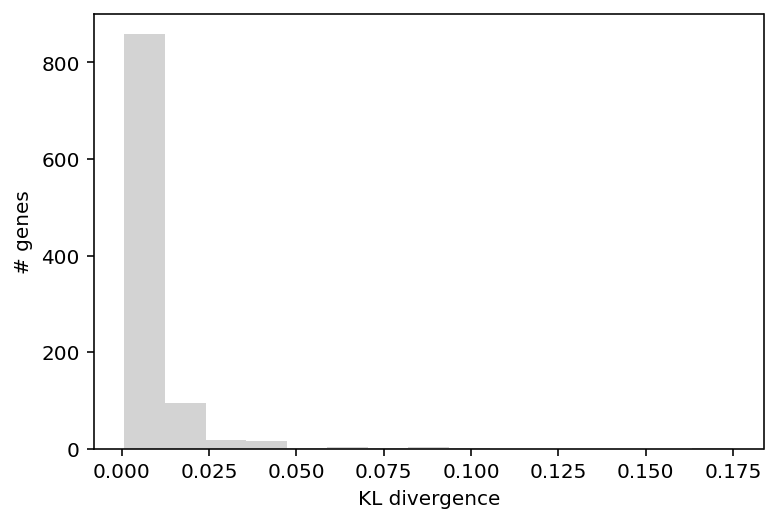

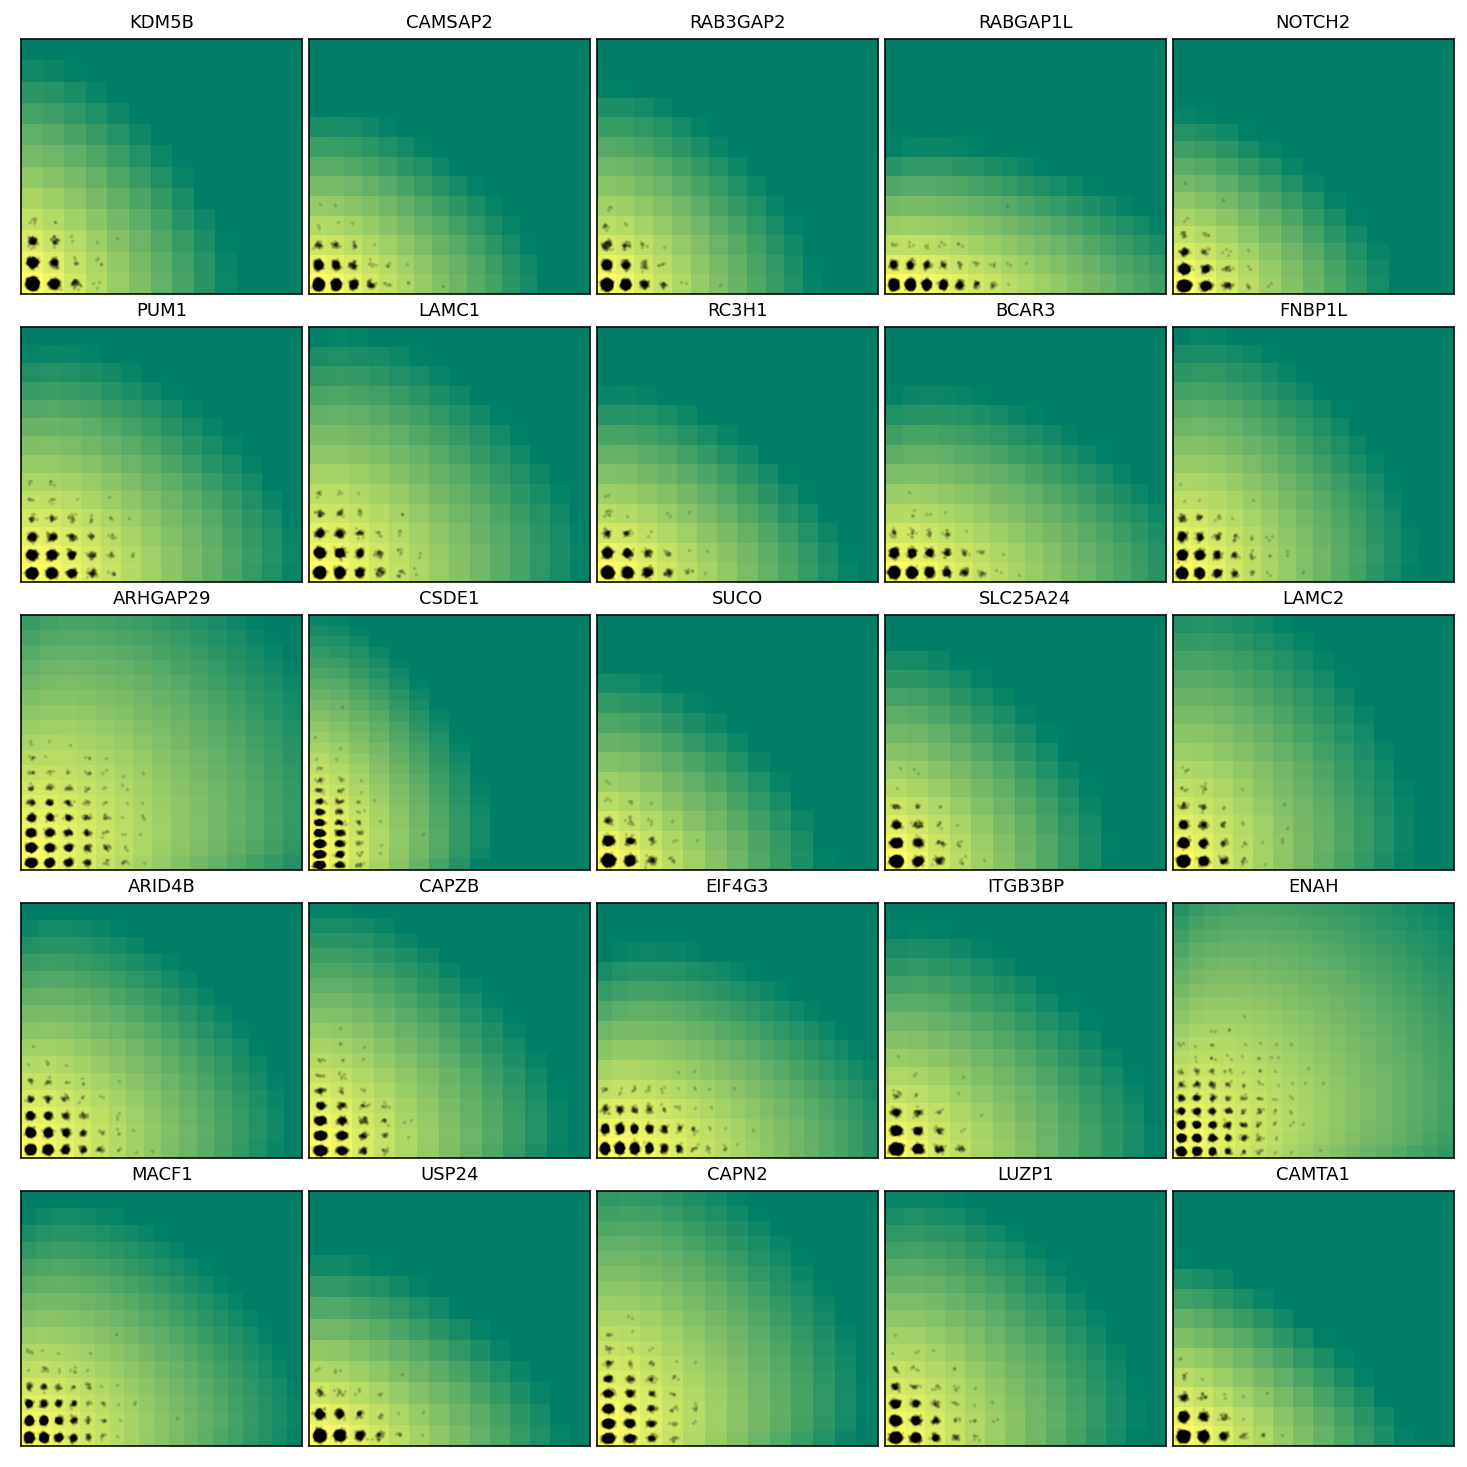

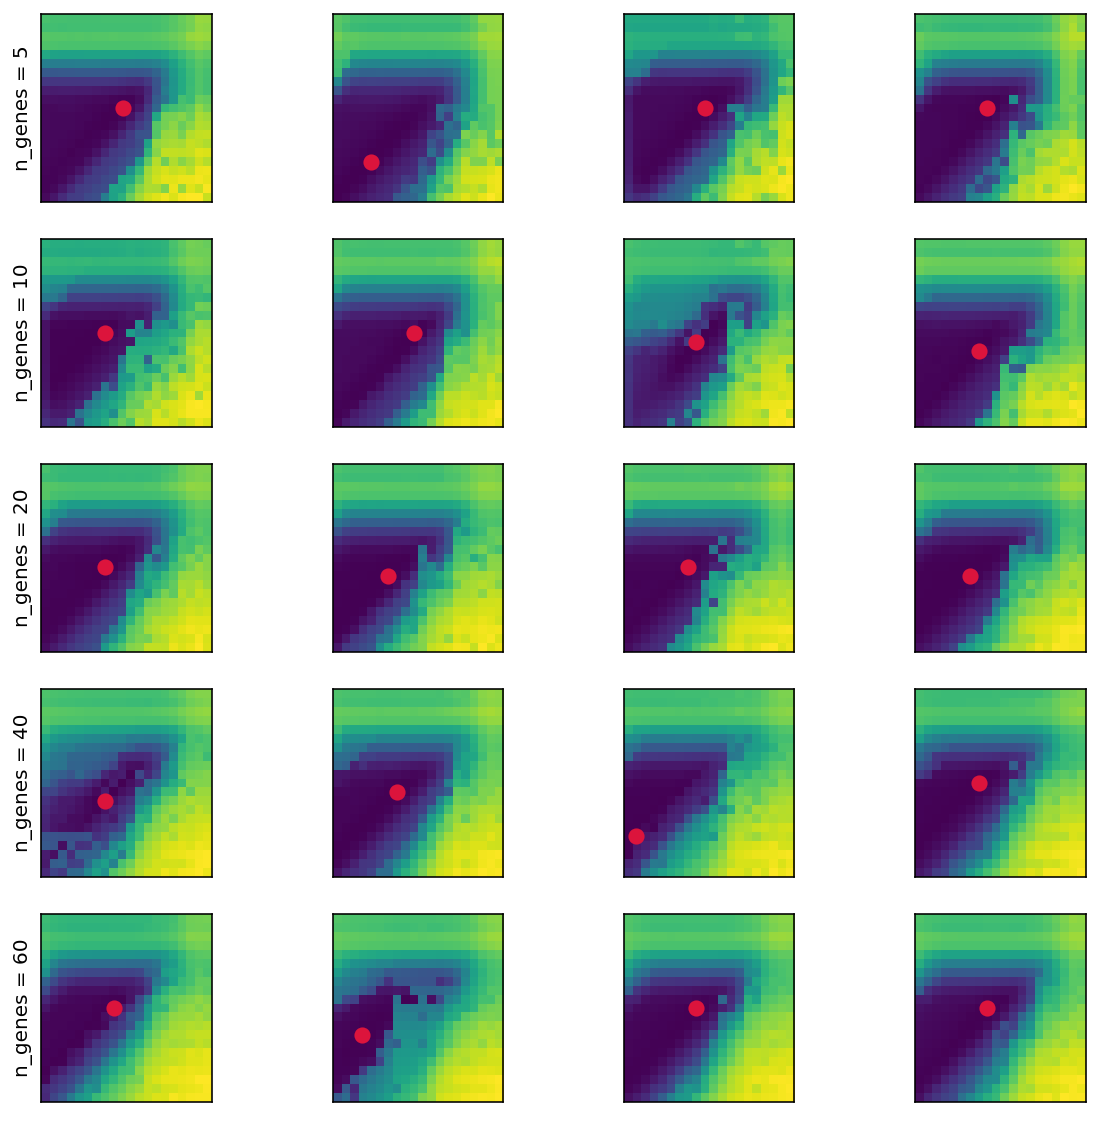

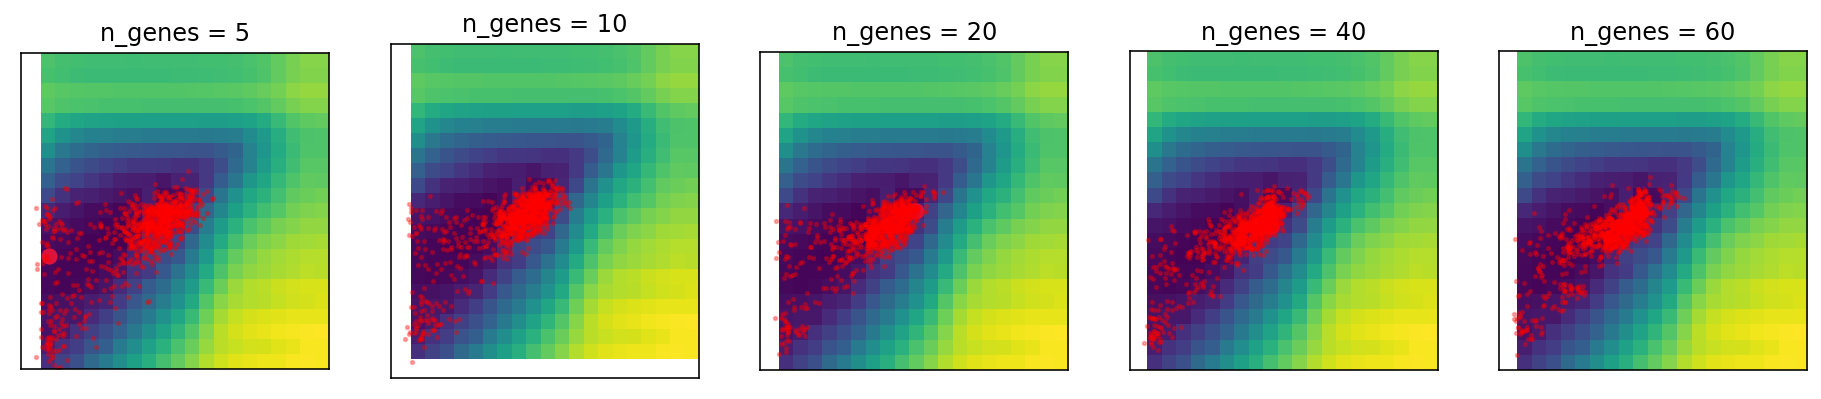

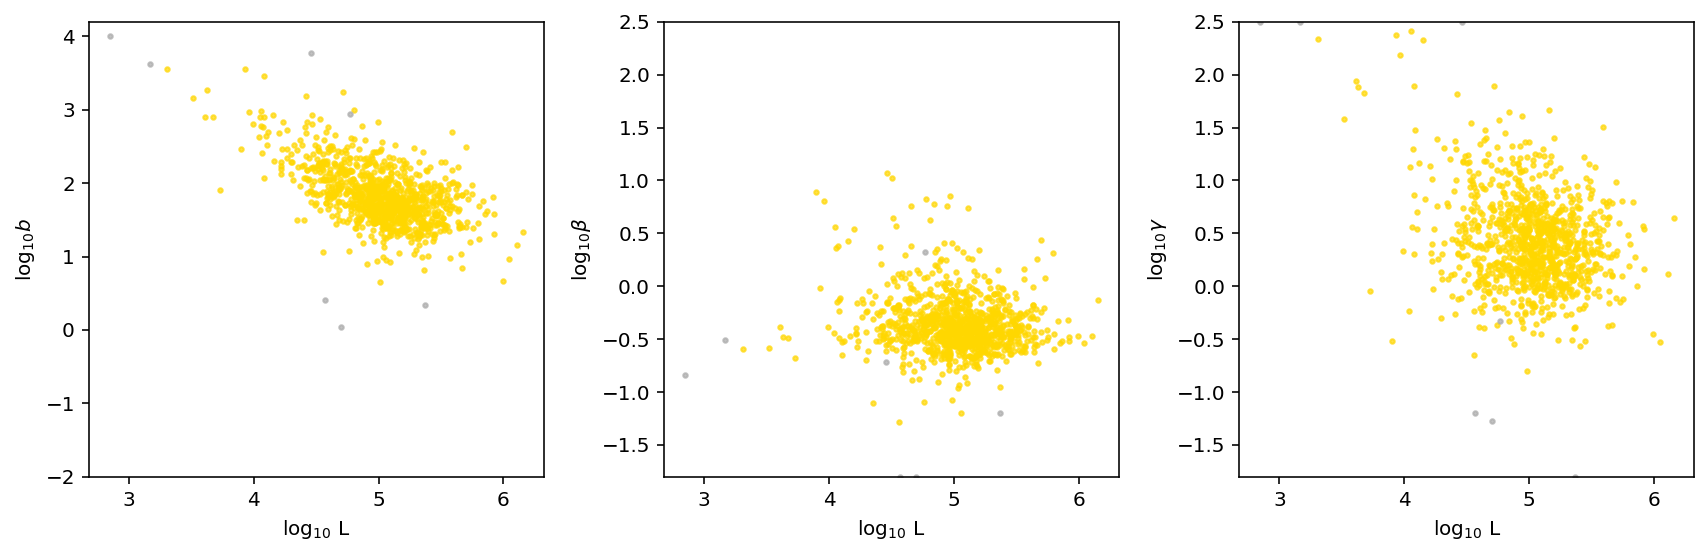

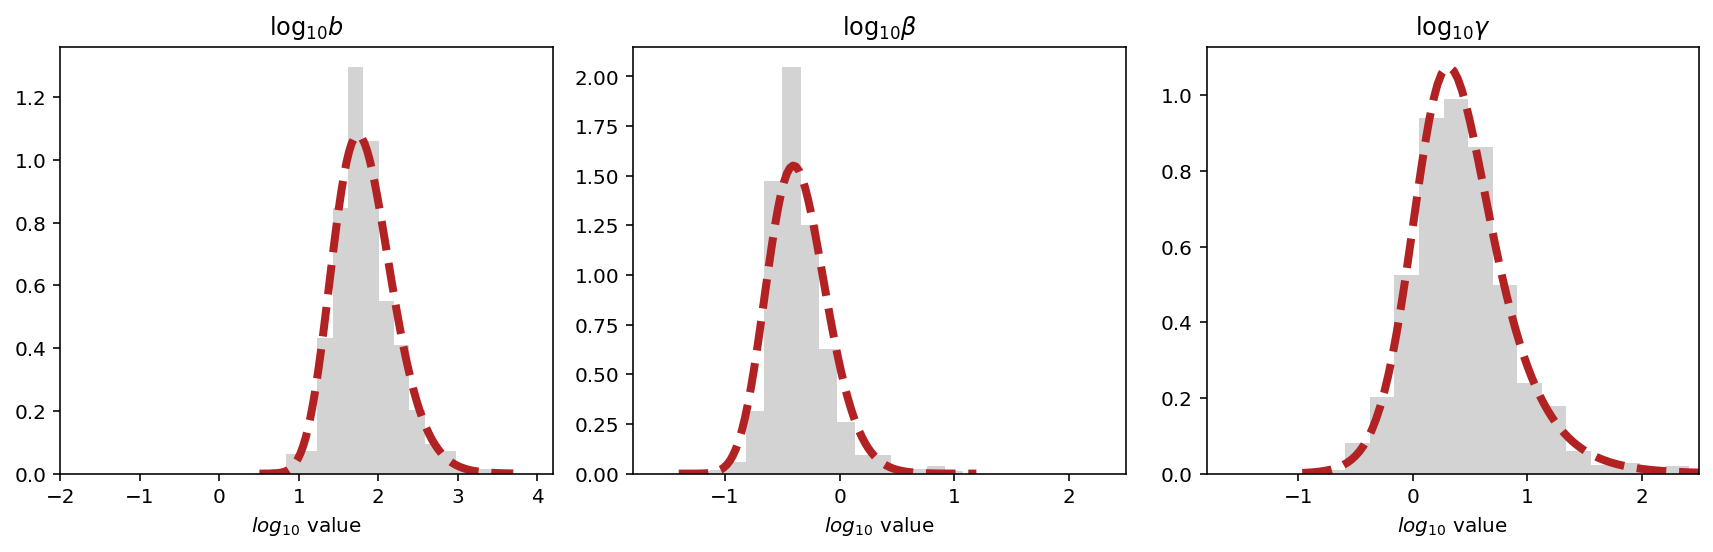

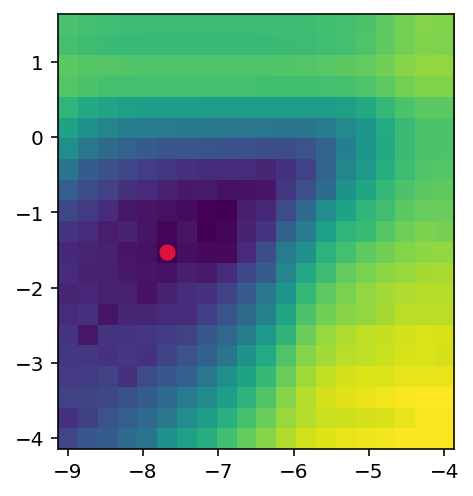

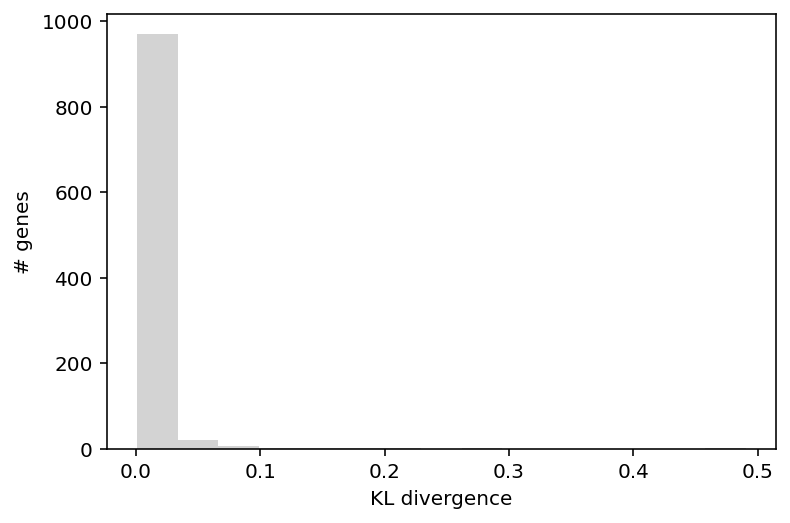

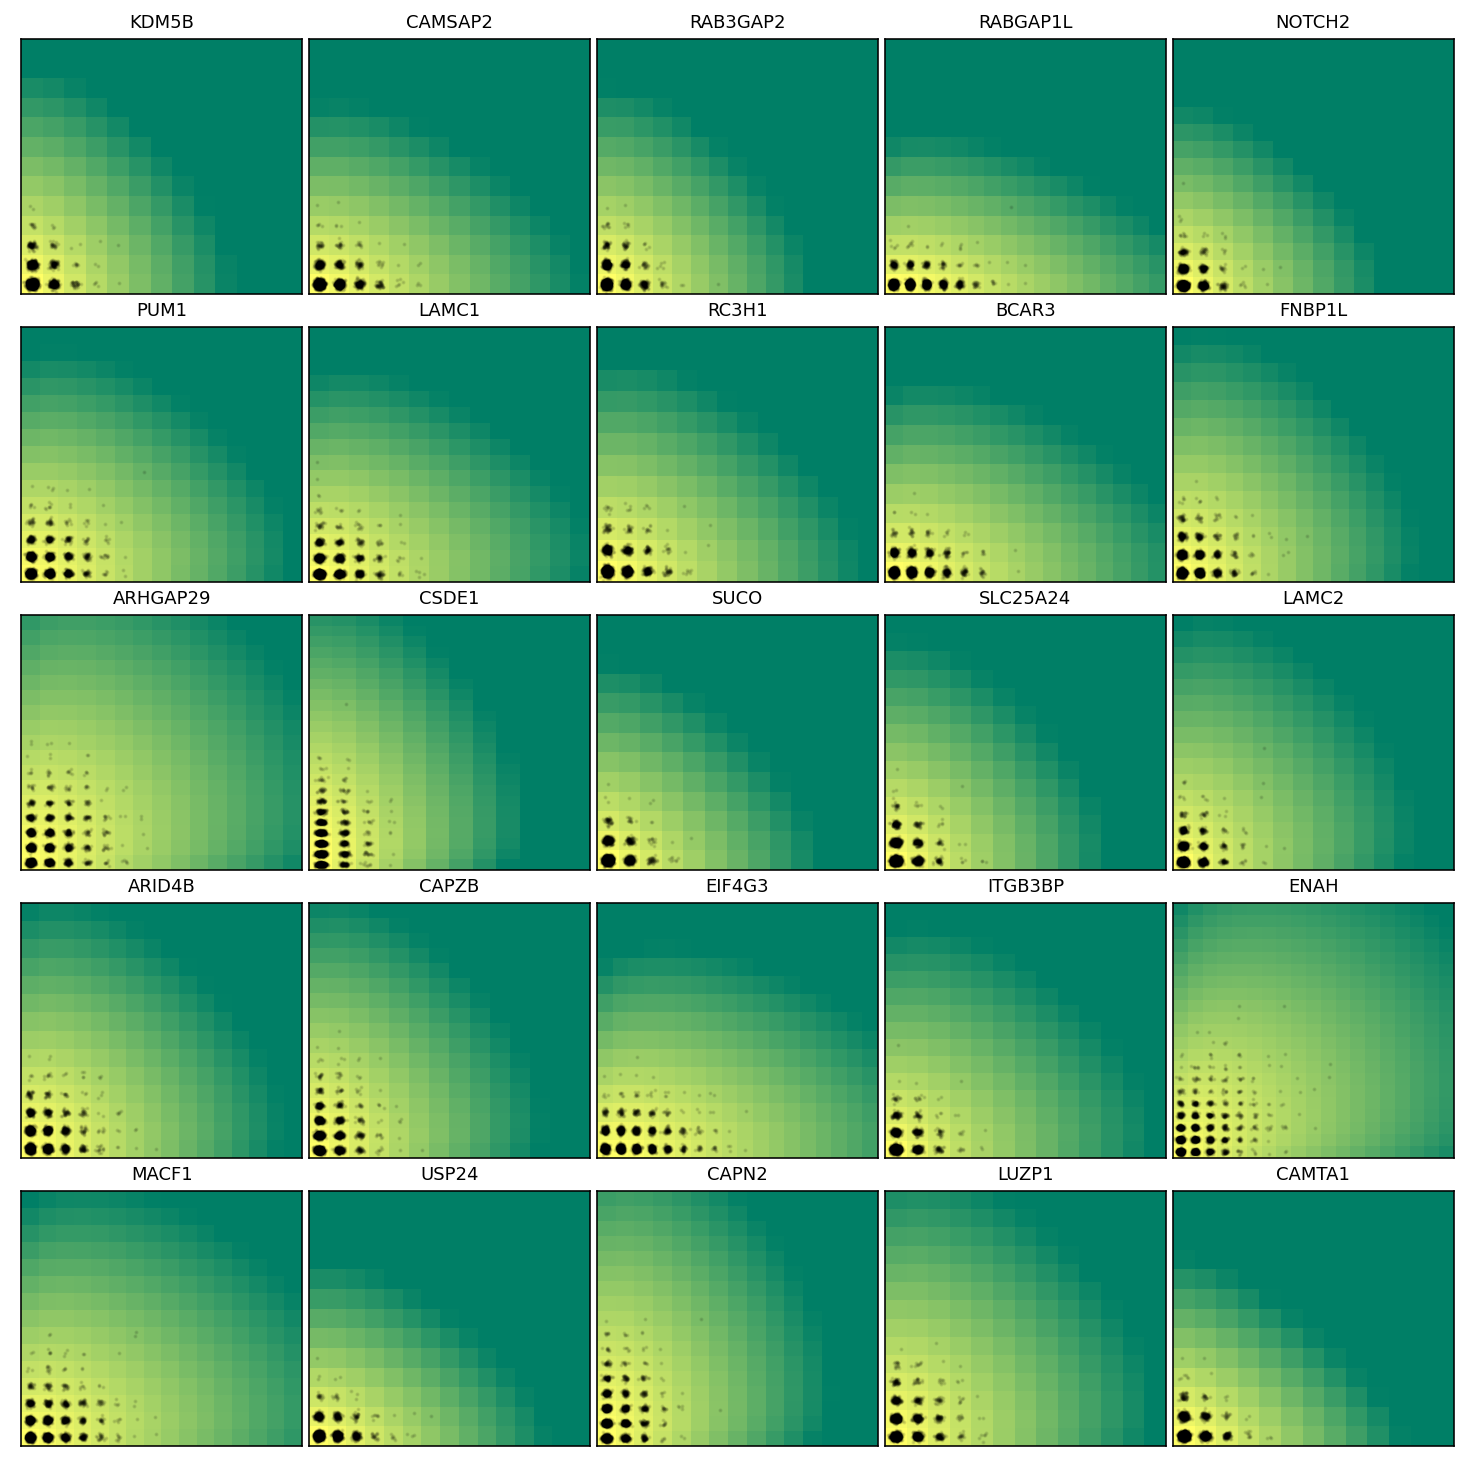

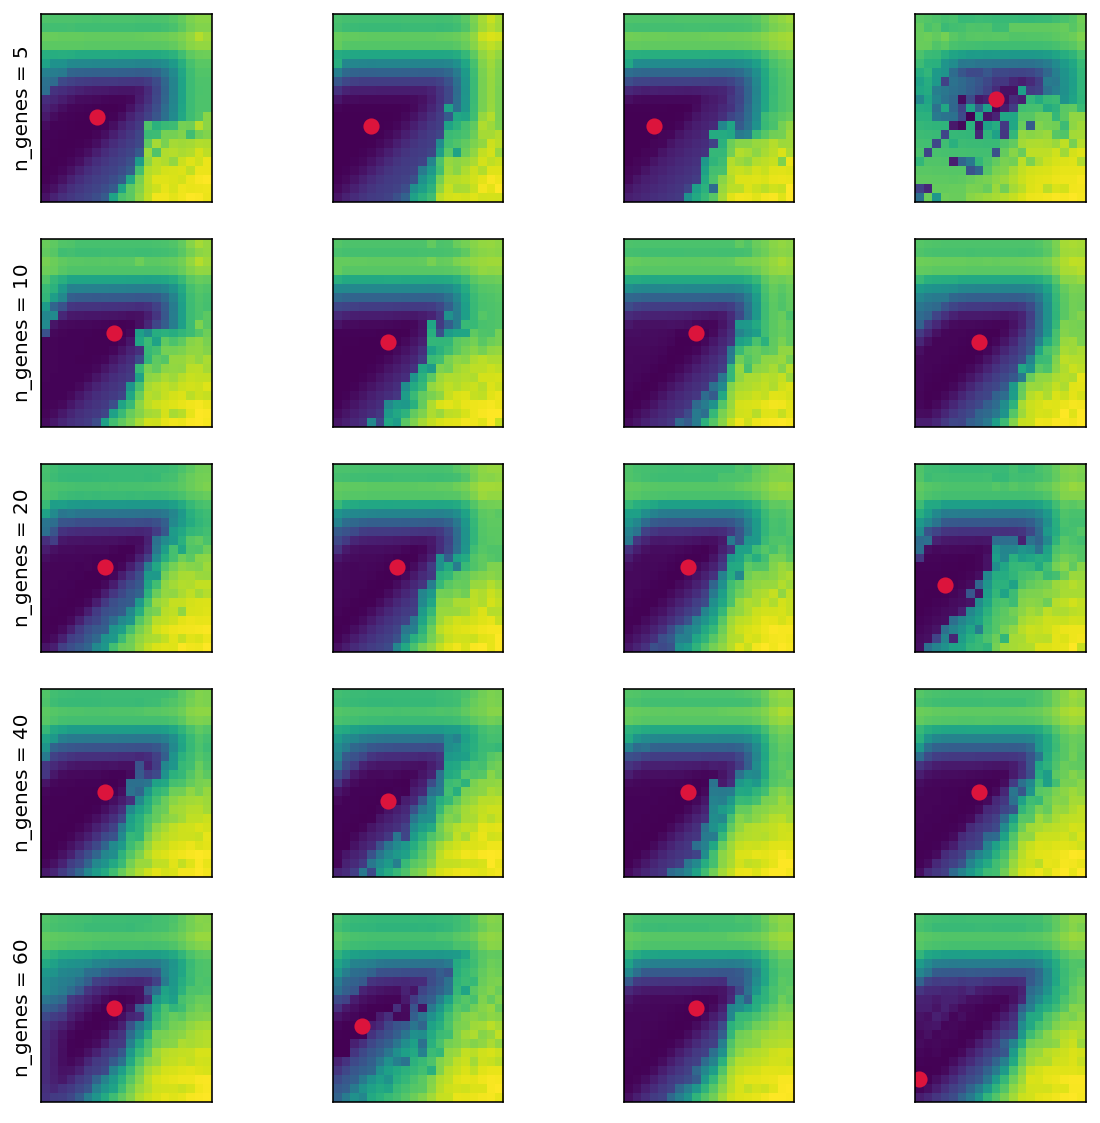

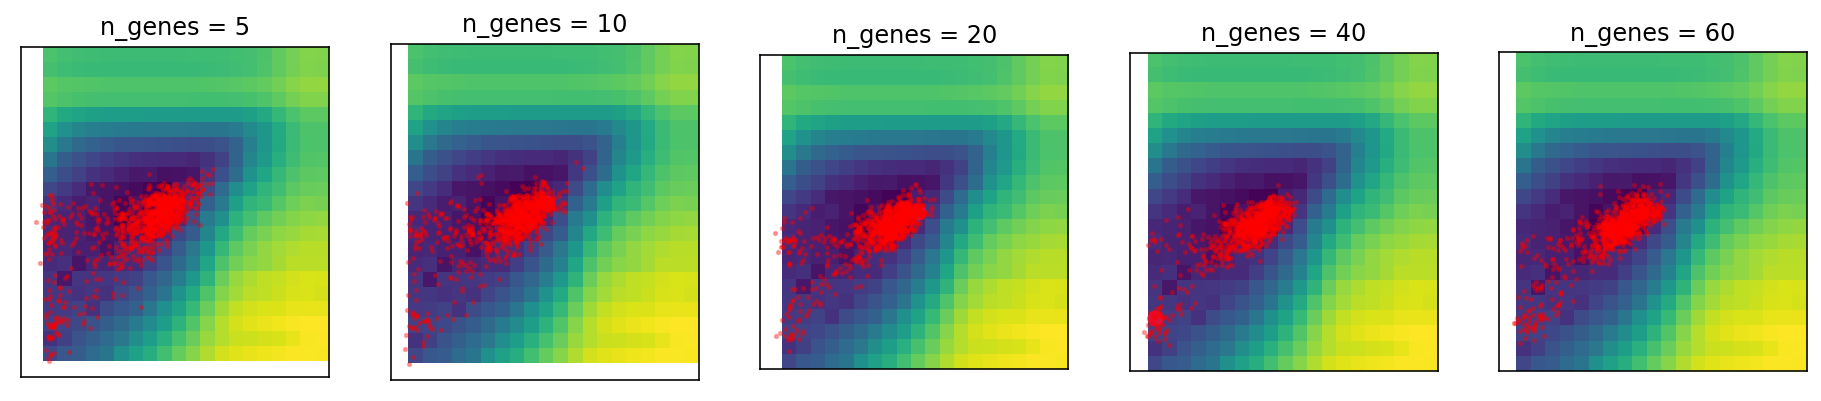

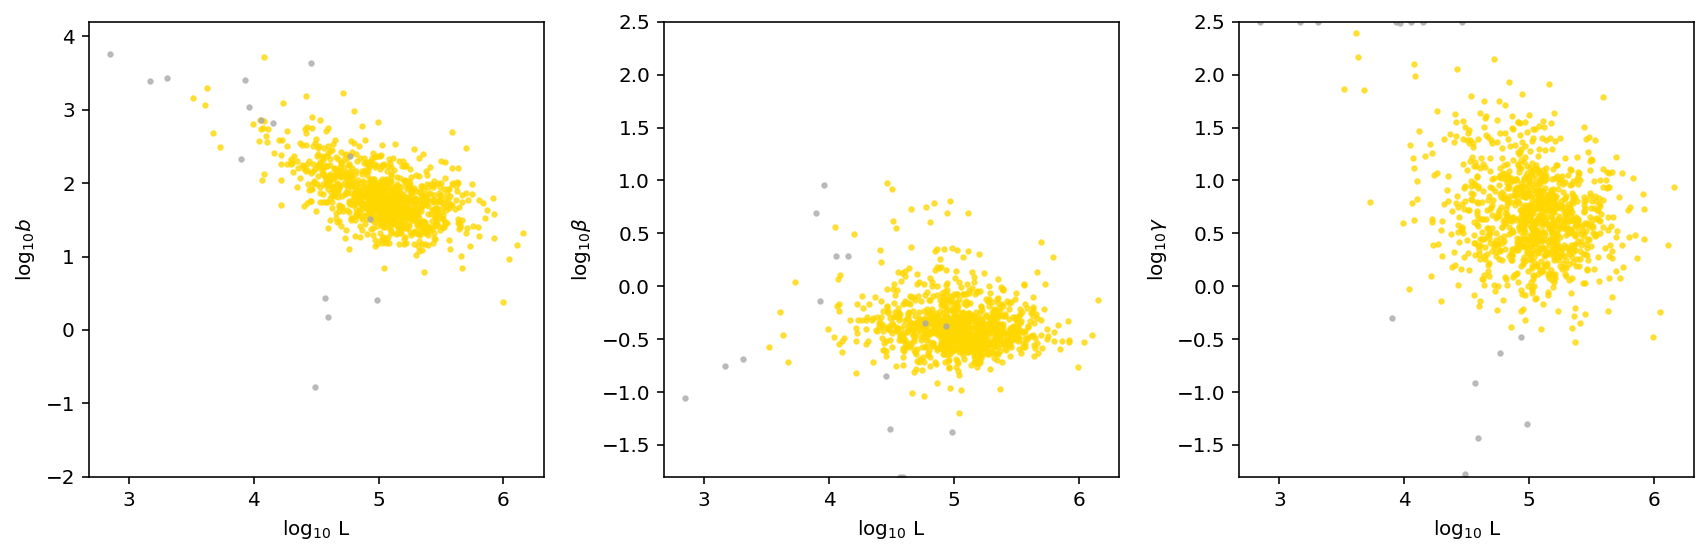

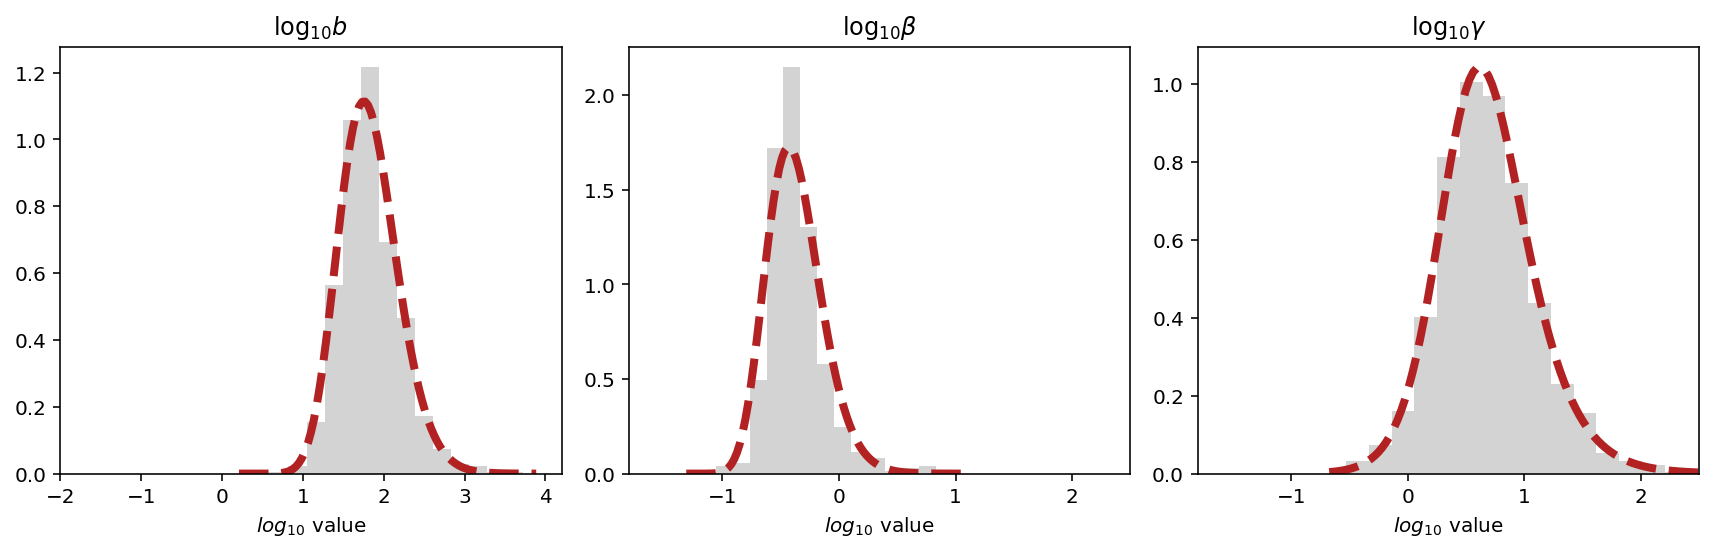

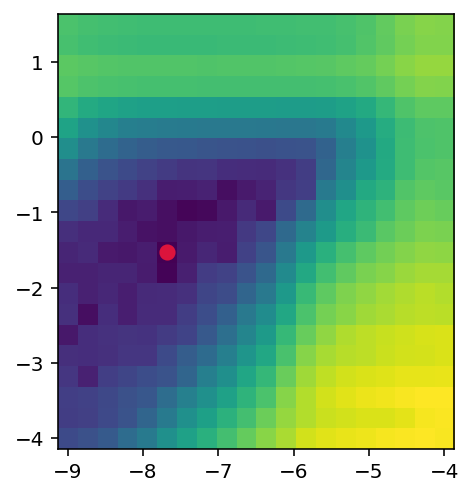

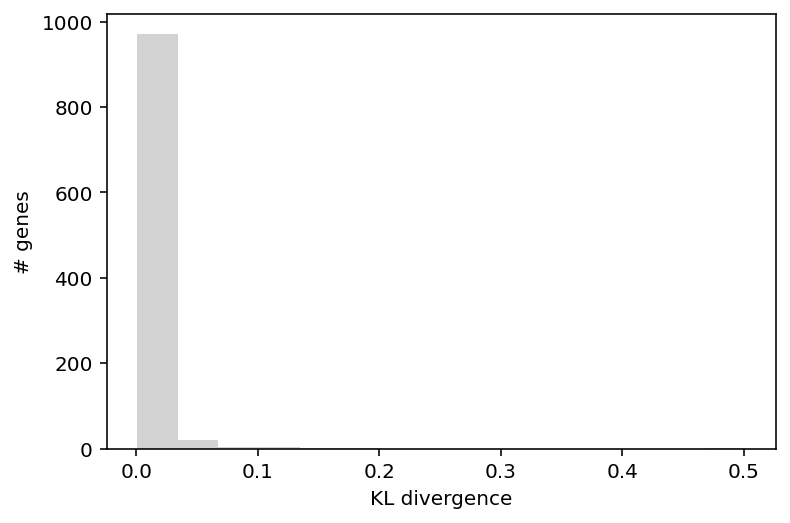

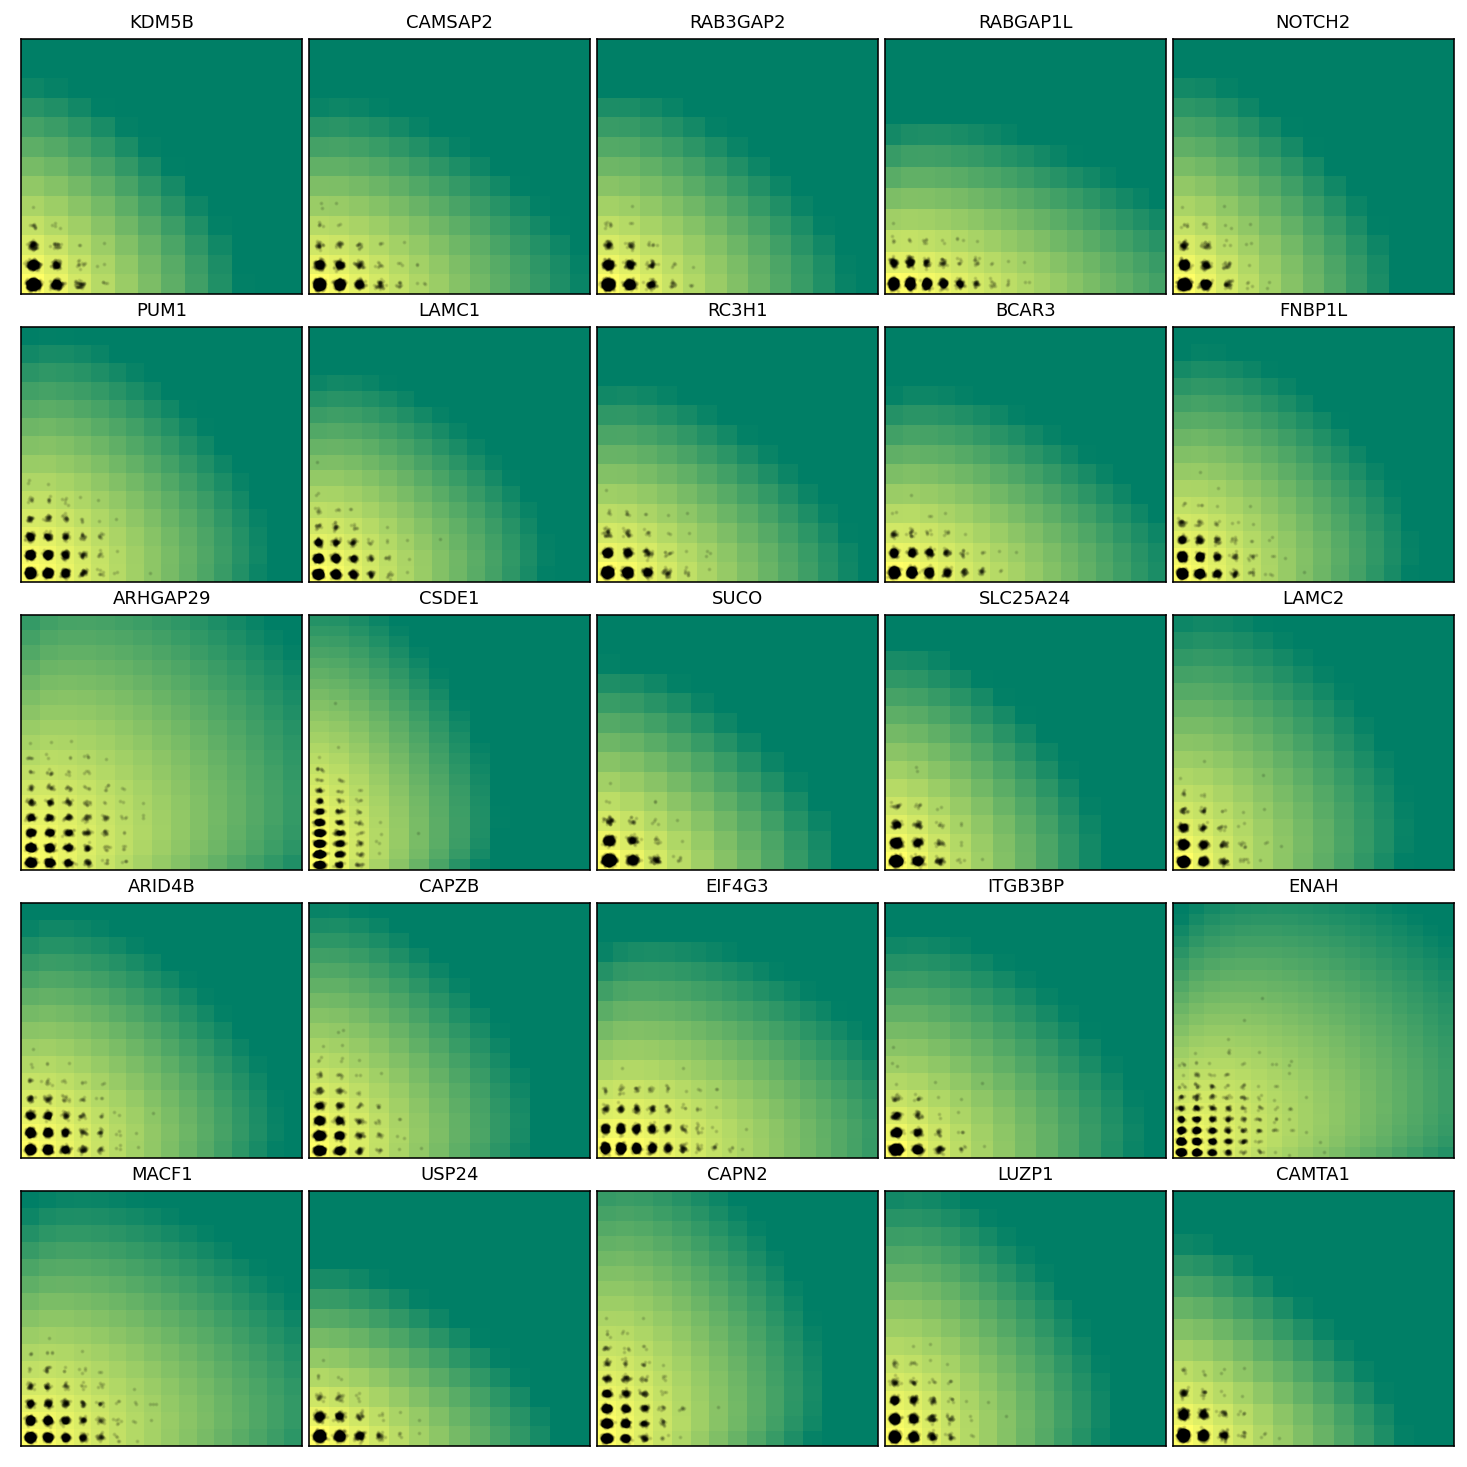

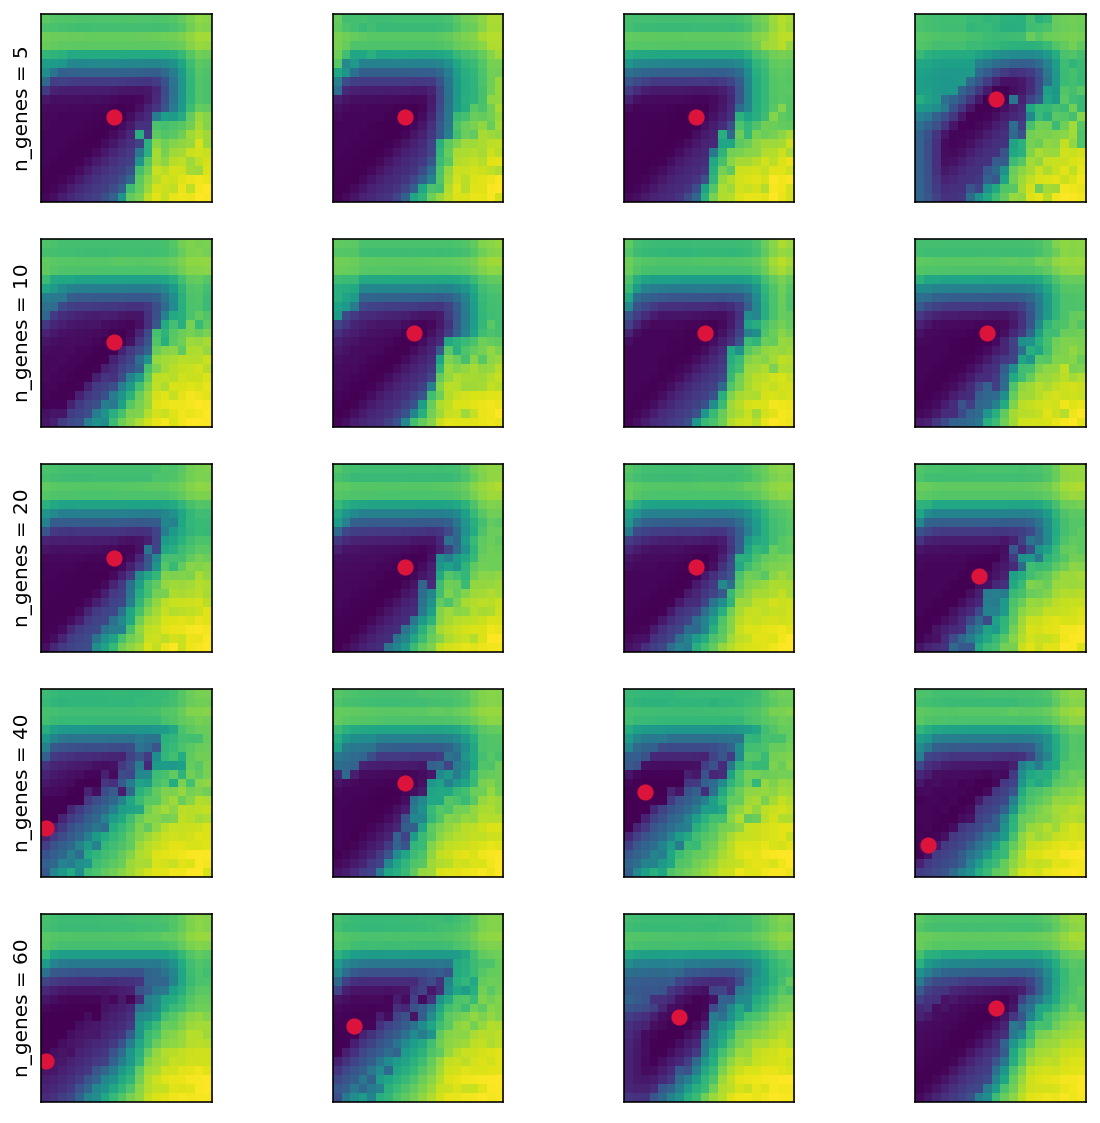

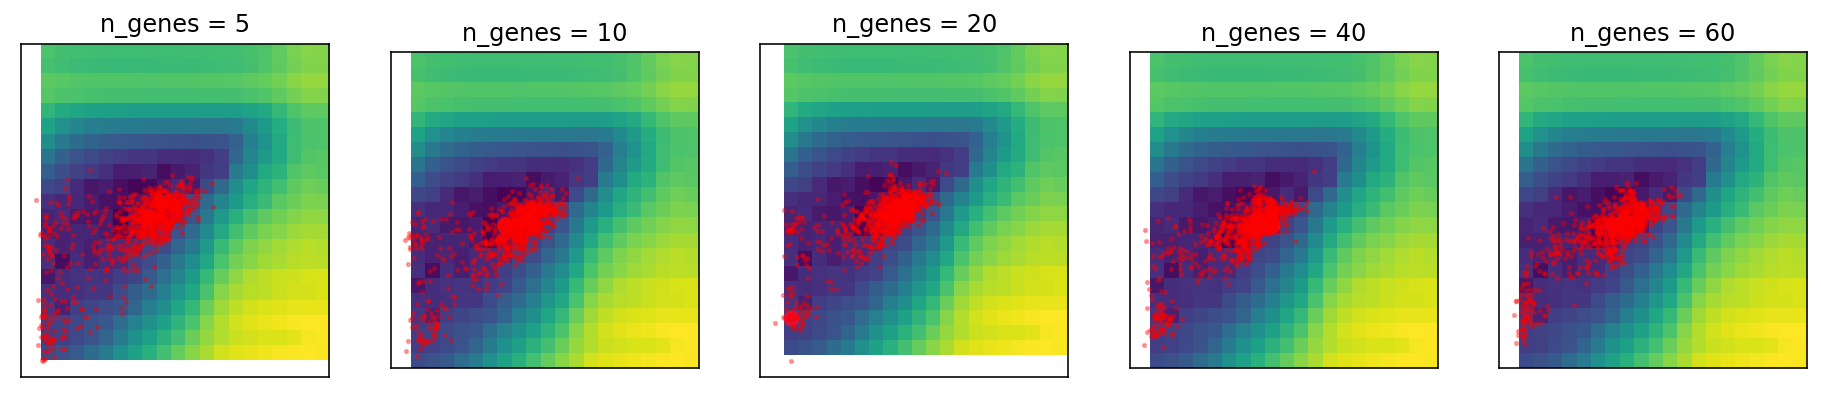

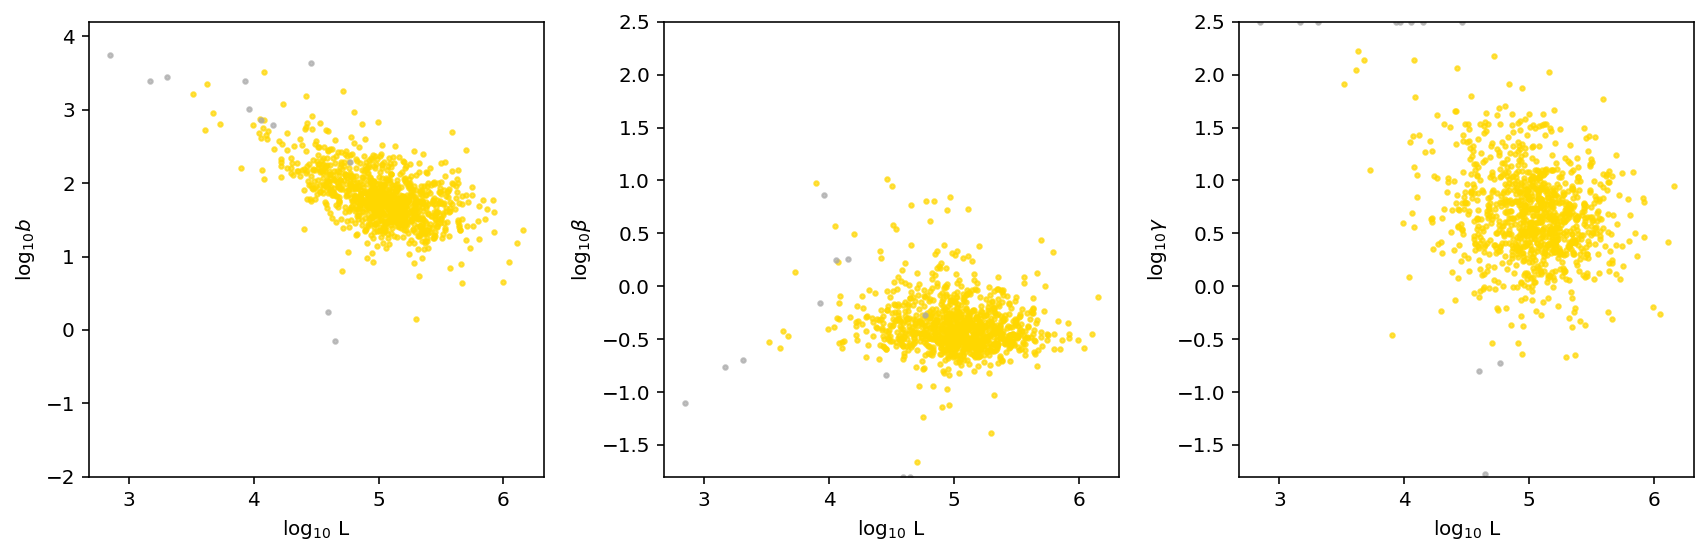

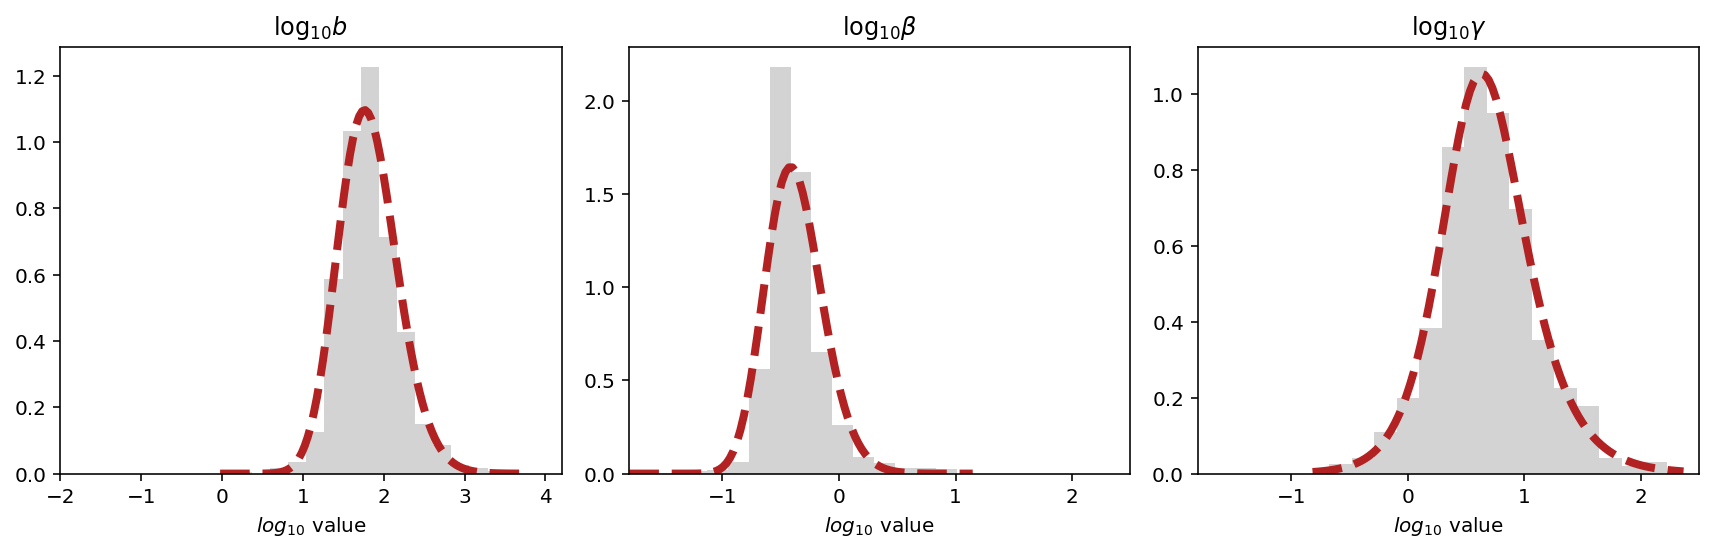

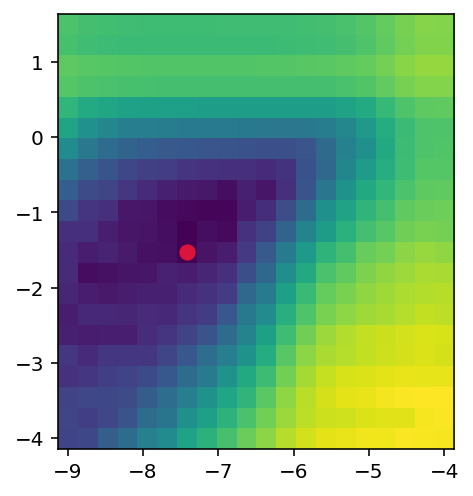

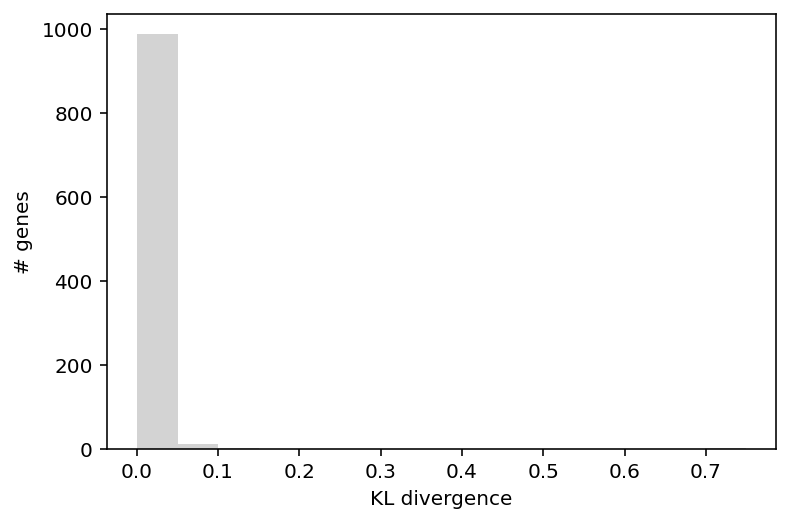

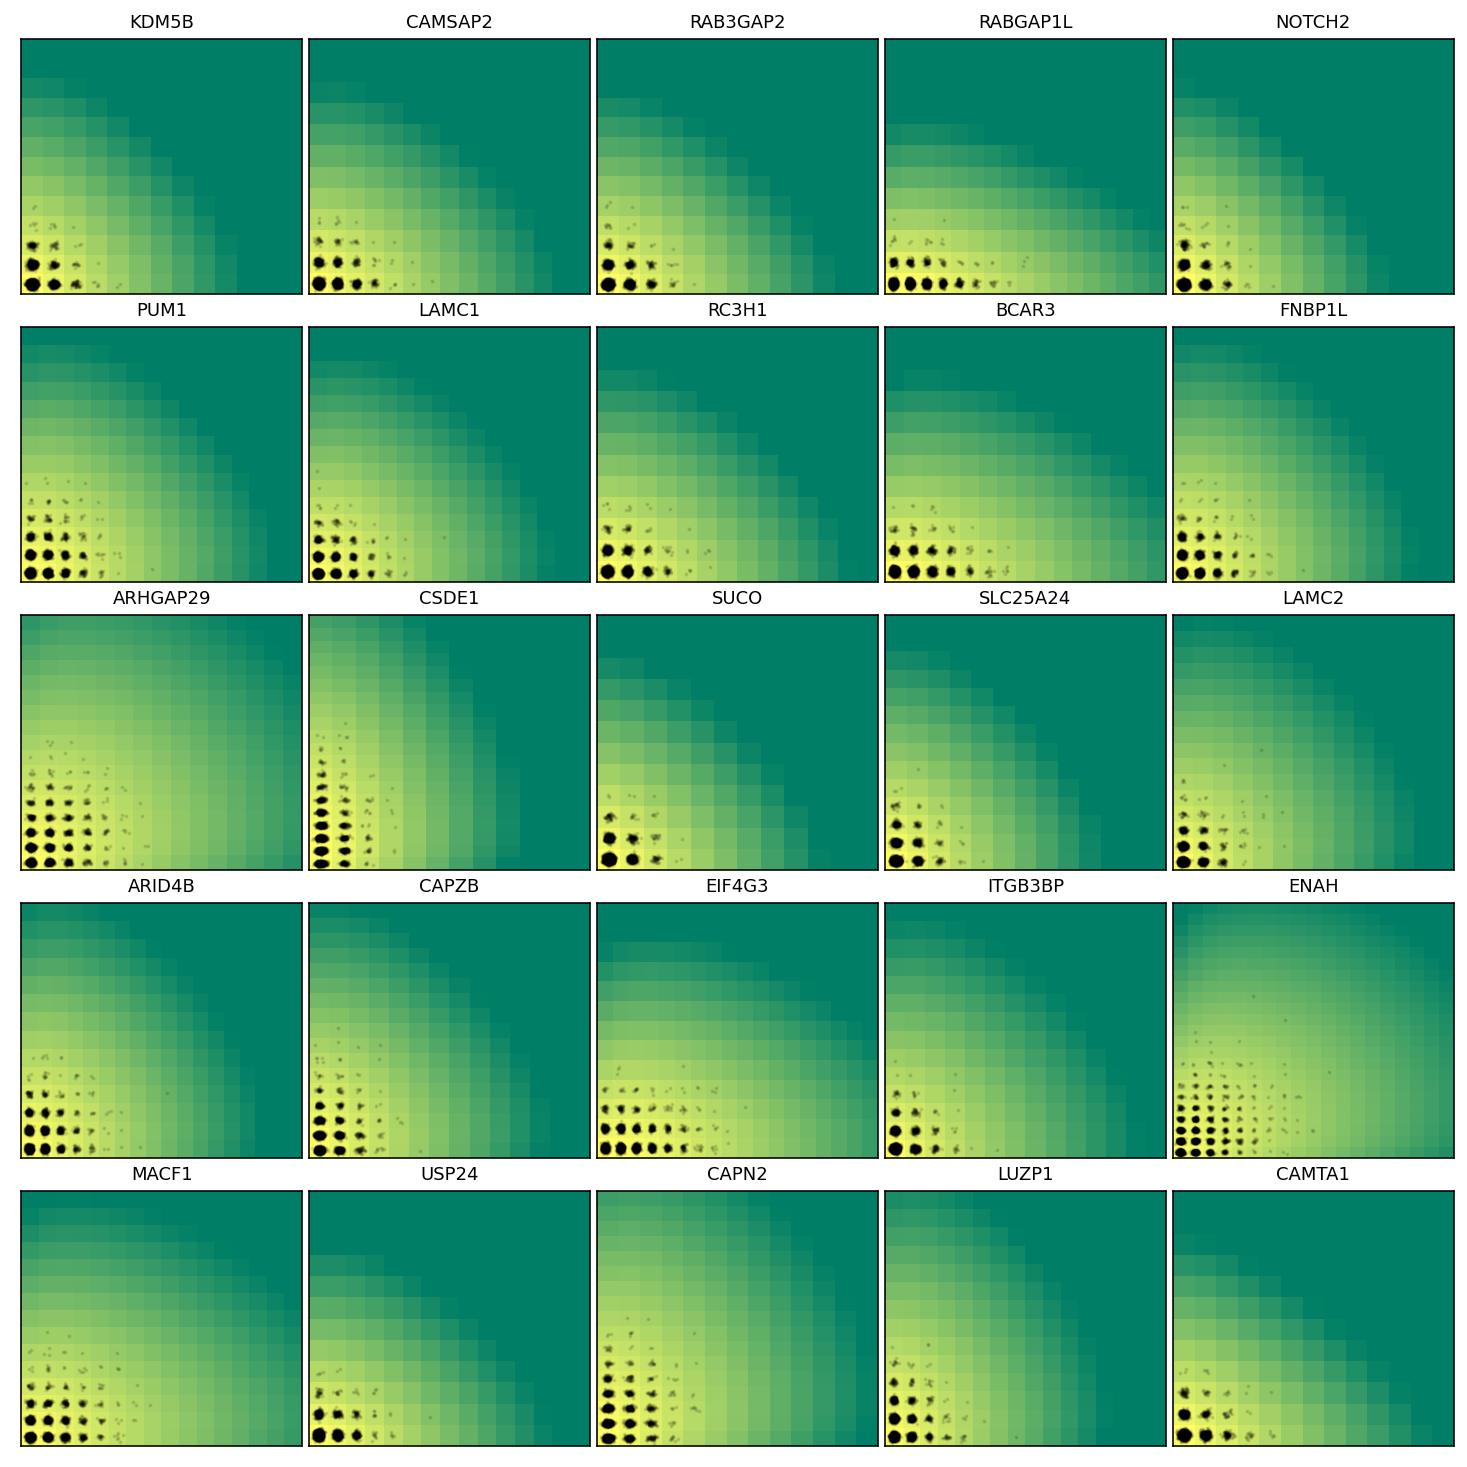

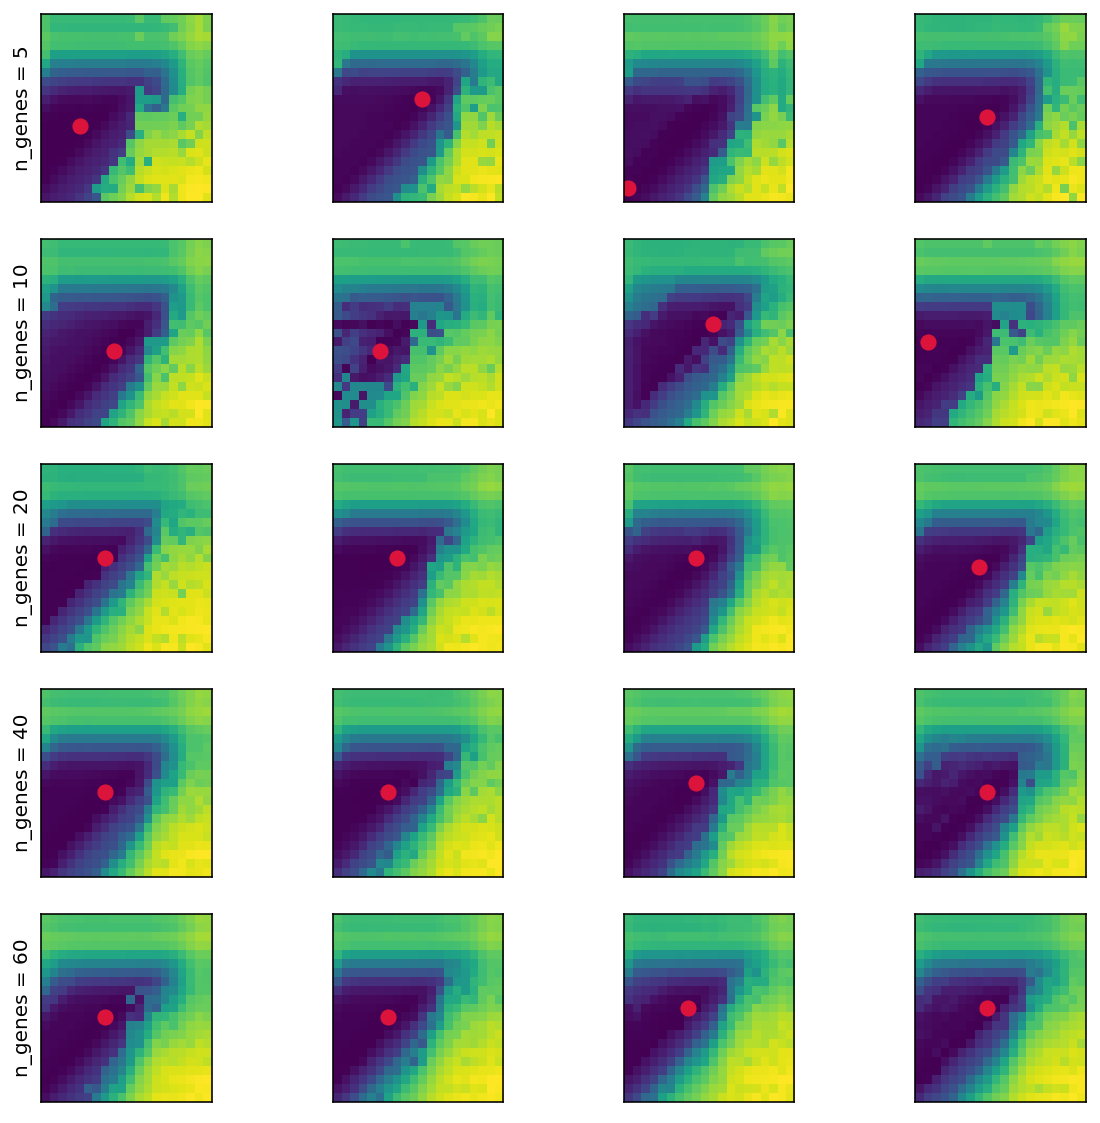

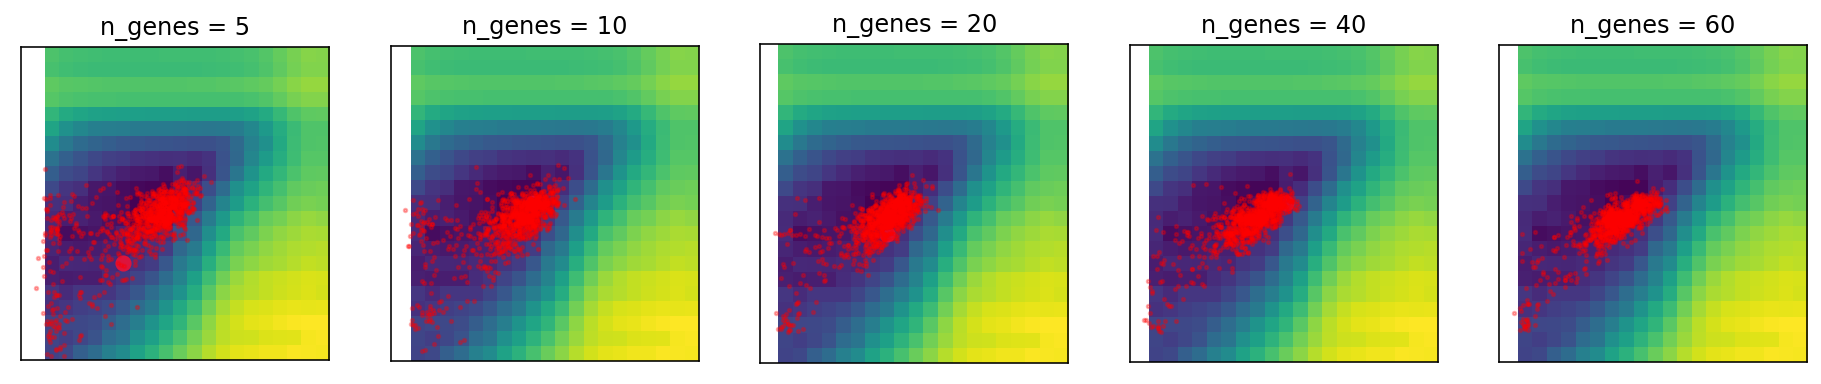

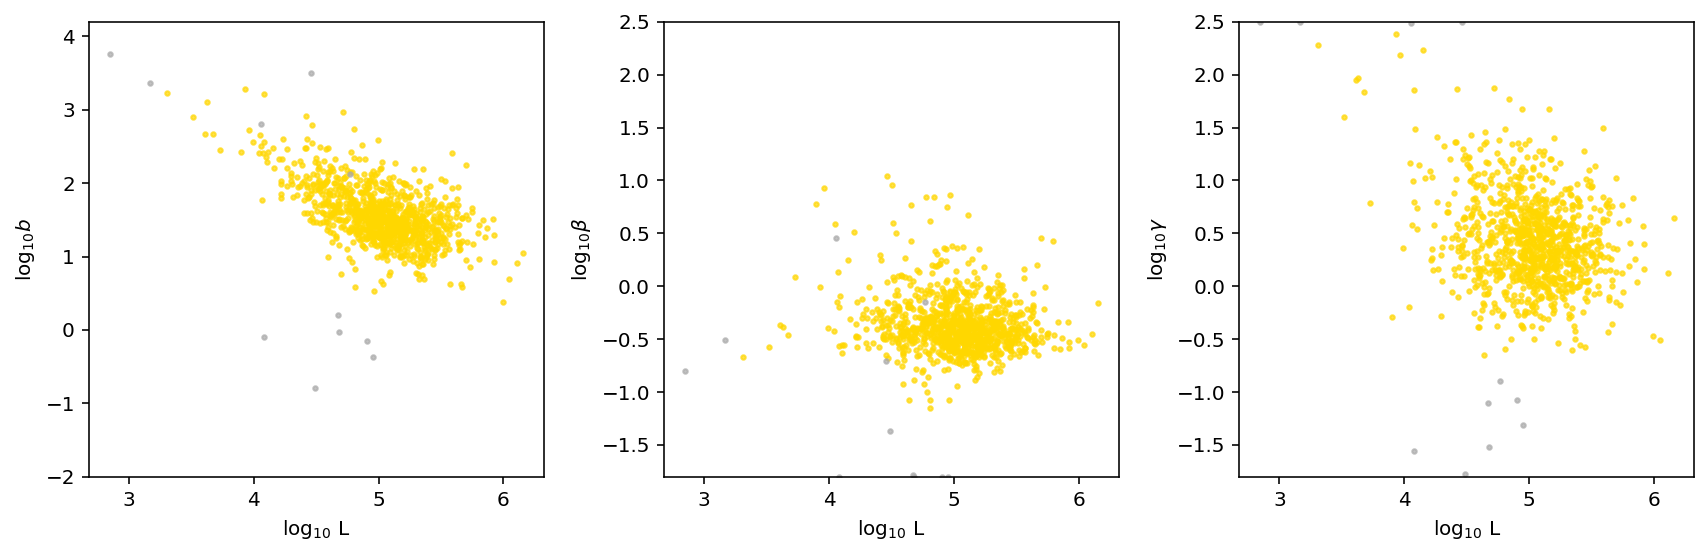

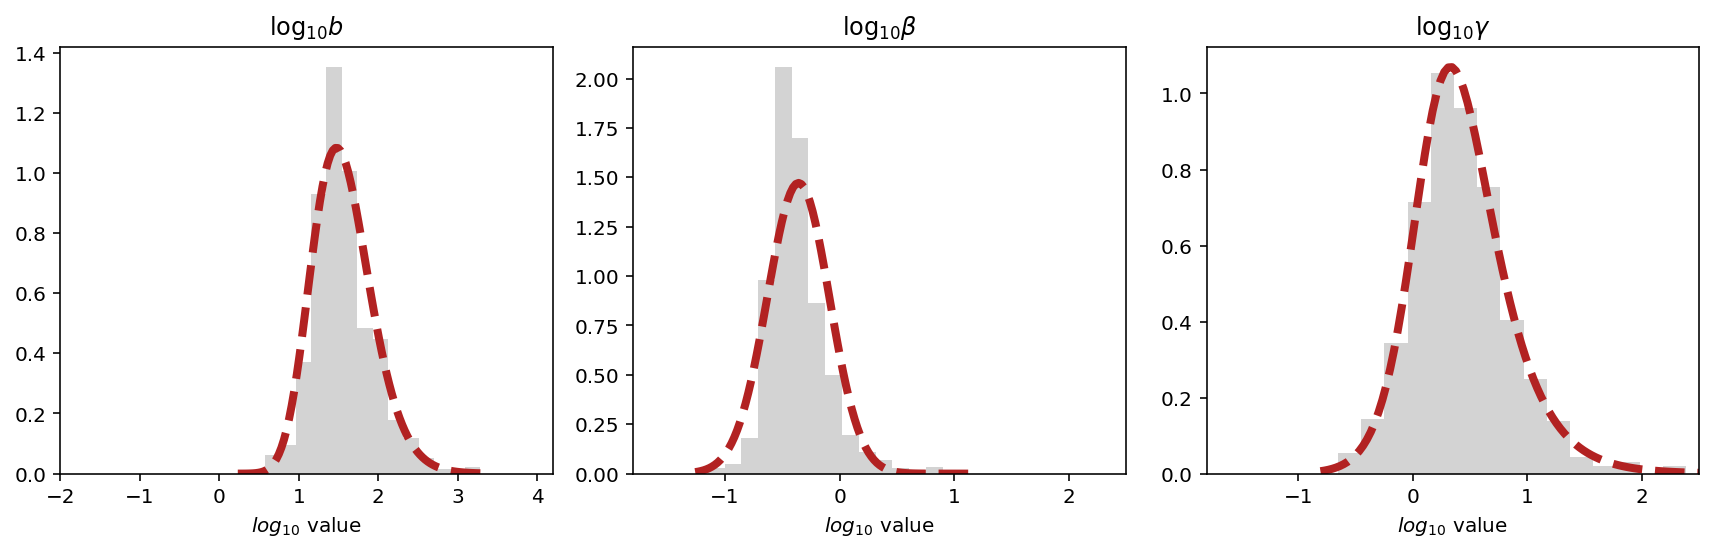

In [531]:
for i in range(4):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    sr.plot_landscape(ax1)

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd,threshold=1e-3)
    sr.resample_opt_viz()
    sr.resample_opt_mc_viz()
    sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=1e-3) 

    sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=False,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()

In [532]:
#Read back in data
sr_arr = [monod.analysis.load_search_results(r[:-4]+'_upd.res') for r in result_strings]

INFO:root:Grid scan results loaded from ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run0/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run1/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run2/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run3/Bursty_Poisson_20x21/grid_scan_results_upd.res.


(-7.684210526315789, -1.7999999999999998)
INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run0/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
(-7.684210526315789, -1.525)
INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run1/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
(-7.684210526315789, -1.525)
INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run2/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
(-7.421052631578947, -1.525)
INFO:root:Figure stored to ./fits/gg_230922_025_tech_cancer_dt_1/meK_cancer_dt_k1_run3/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.


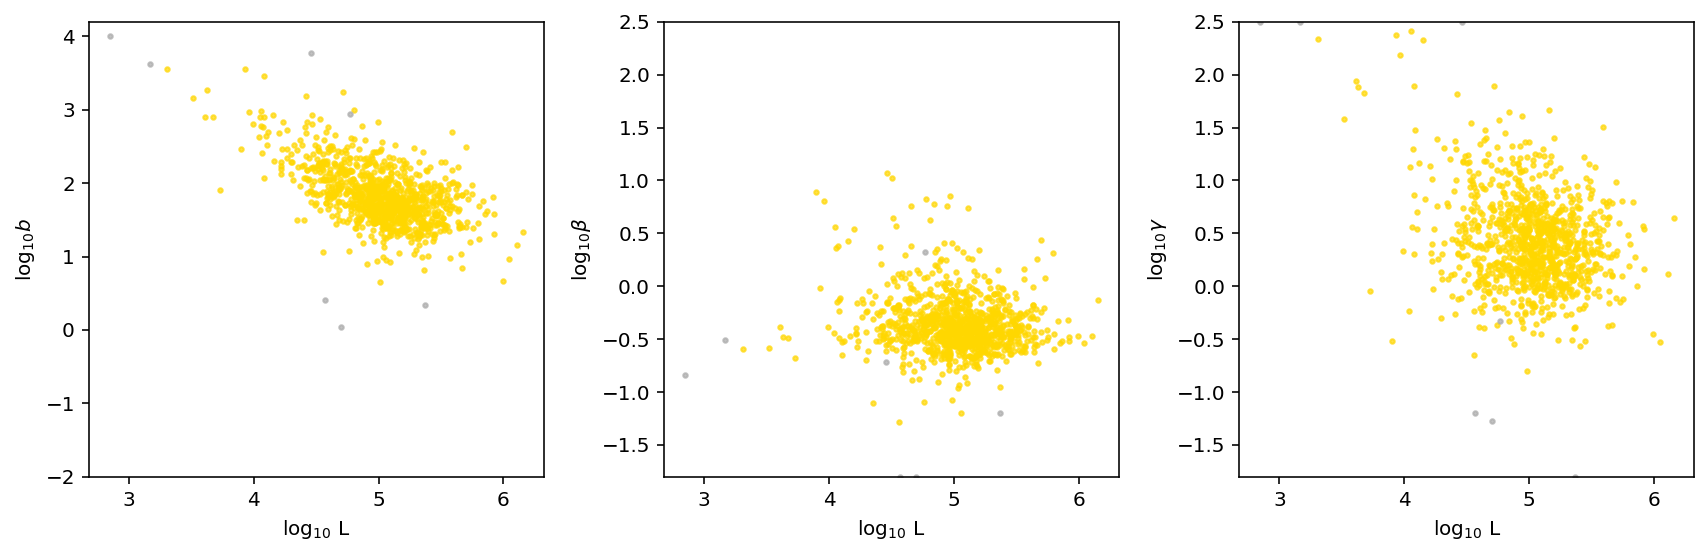

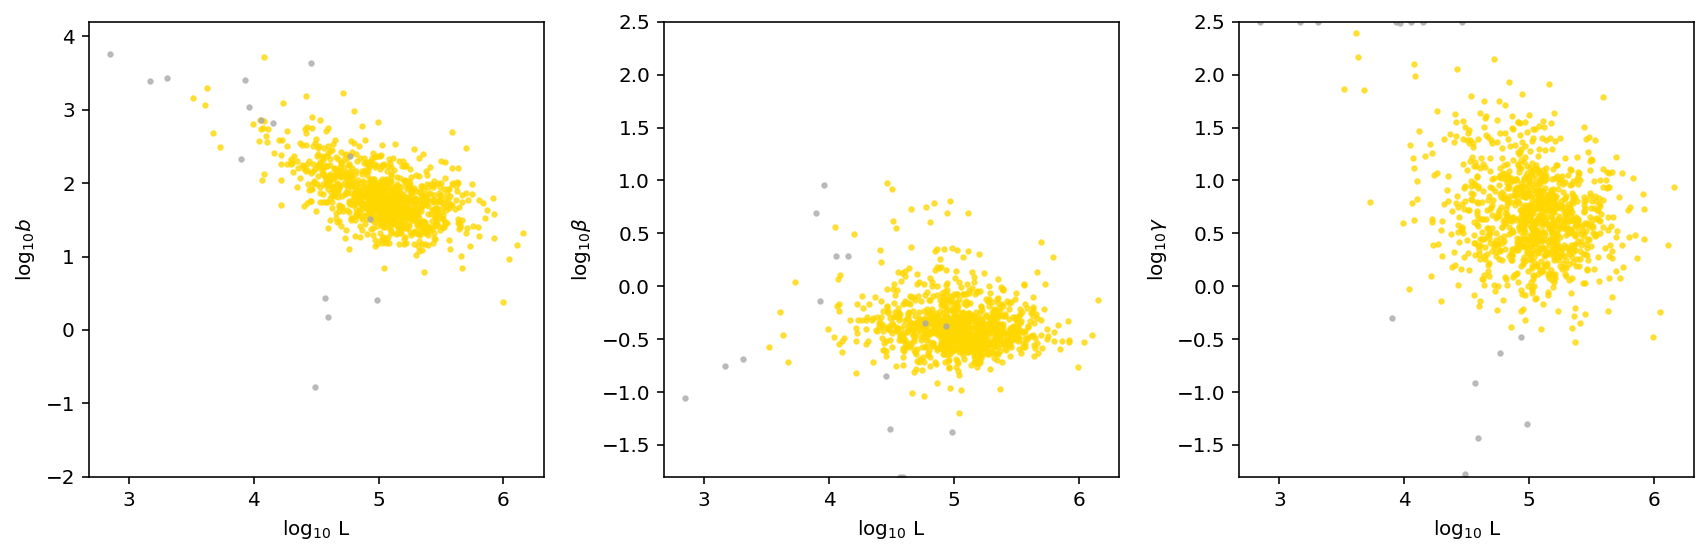

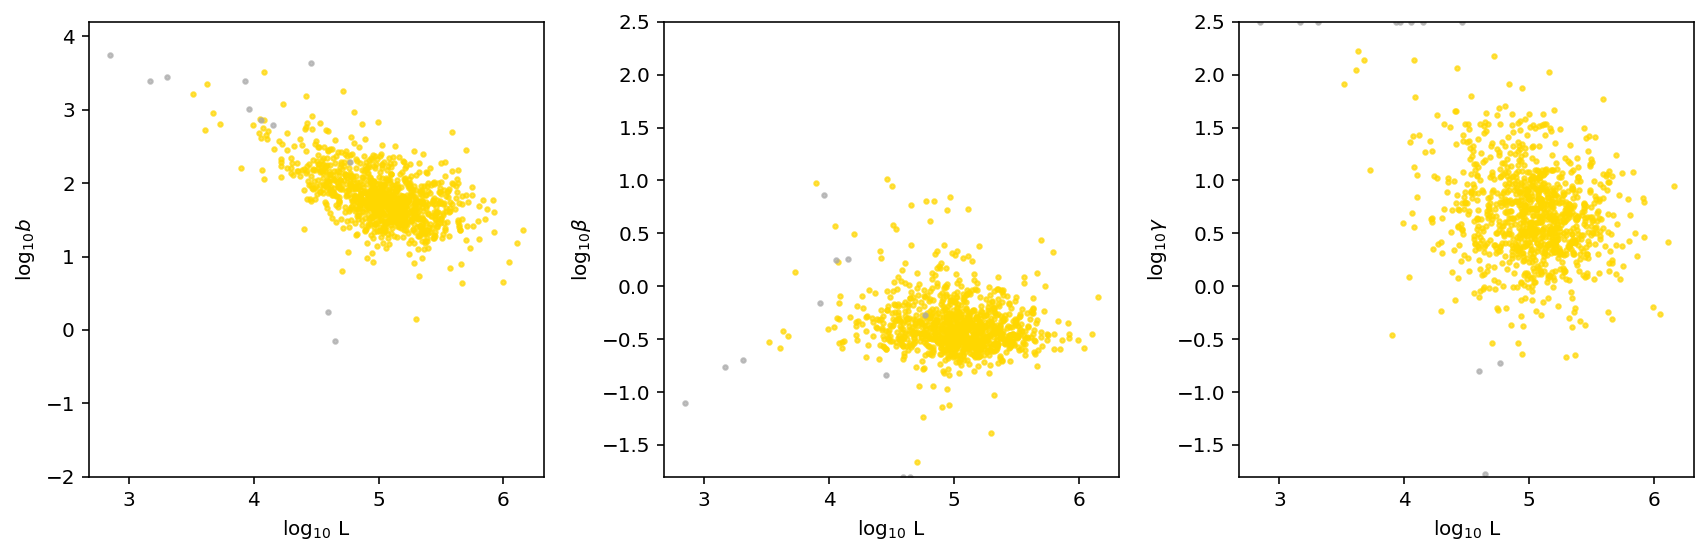

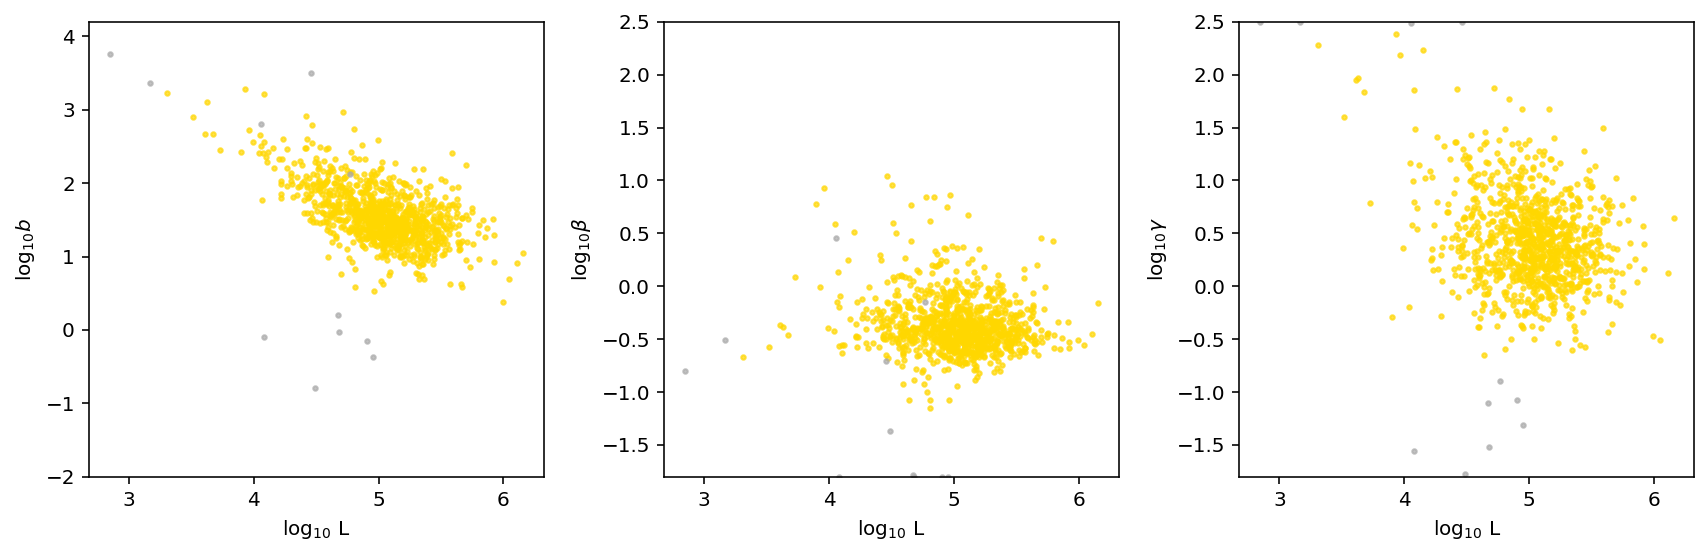

In [533]:
#See parameter fits per dataset
opt=[]
n_cells = []
for sr in sr_arr:
    y = sr.samp_optimum
    print(y)
    opt.append(y)
    n_cells.append(sr.n_cells)
    sr.plot_param_L_dep(plot_errorbars=False,plot_fit=True)
opt = np.asarray(opt)
n_cells = np.asarray(n_cells)

In [534]:
xl = np.asarray([sr.sp.samp_lb[0],sr.sp.samp_ub[0]])
yl = np.asarray([sr.sp.samp_lb[1],sr.sp.samp_ub[1]])
x=np.linspace(xl[0],xl[1],sr.sp.gridsize[0])
y=np.linspace(yl[0],yl[1],sr.sp.gridsize[1])

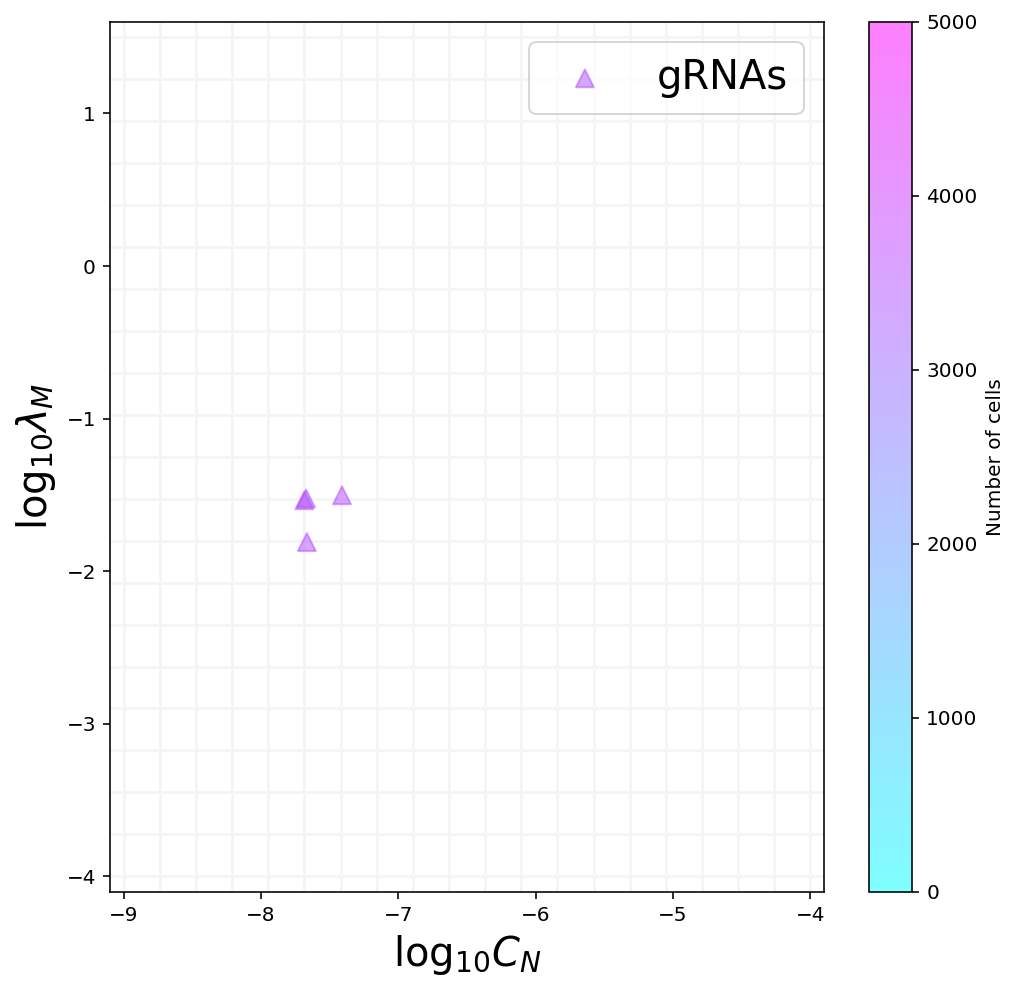

In [535]:
fs = 20
d=0.1

fig1,ax1 = plt.subplots(1,1,figsize=(8,8))
for i in range(sr.sp.gridsize[0]):
    plt.plot([x[i]]*2,yl + [-d,d],c='whitesmoke')
for i in range(sr.sp.gridsize[1]):
    plt.plot(xl+ [-d,d],[y[i]]*2,c='whitesmoke')
jit = np.random.randn(4,2)*0.01
opt_ = opt+jit
cmap = 'cool'



stf = range(4) 

plt.scatter(opt_[stf,0],opt_[stf,1],80,n_cells[stf],marker='^',zorder=1000,
            alpha=0.5,cmap=cmap,label='gRNAs',vmin=0,vmax=5000,)
plt.xlim(xl+ [-d,d])
plt.ylim(yl+ [-d,d])

plt.legend(fontsize=fs,loc='upper right')
plt.colorbar(label='Number of cells')

plt.xlabel(r'$\log_{10} C_N$',fontsize=fs)
plt.ylabel(r'$\log_{10} \lambda_M$',fontsize=fs)

fig_string = sr.batch_analysis_string+'/landscape_qc.png'
plt.savefig(fig_string,dpi=450)

In [148]:
# sr.sp.sampl_vals

### **Run meK-Means**

Over the range of Ks previously specified

In [637]:
#Set bounds from physical parameters search space
phys_lb = [-2.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 2.5]


samp_lb = [-7.684210526315789, -1.525]
samp_ub = [-7.684210526315789, -1.525]

gridsize = [1,1]

In [640]:
#Set number of epochs
epochs = 15

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230922_025_meK_cancer_dt_1 already exists.
INFO:root:Dataset: meK_cancer_dt_k1_run0
INFO:root:3490 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:905 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k1_run0 already exists.
INFO:root:Dataset: meK_cancer_dt_k1_run1
INFO:root:3514 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:947 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k1_run1 already exists.
INFO:root:Dataset: meK_cancer_dt_k1_run2
INFO:root:3497 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:923 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230922_025_meK_ca

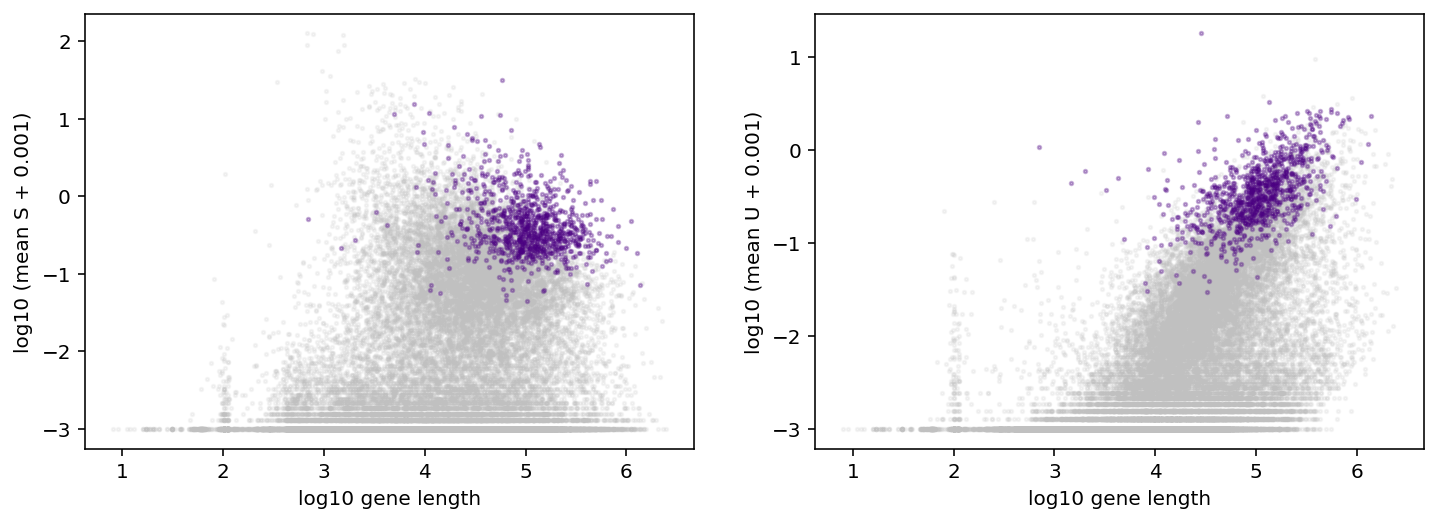

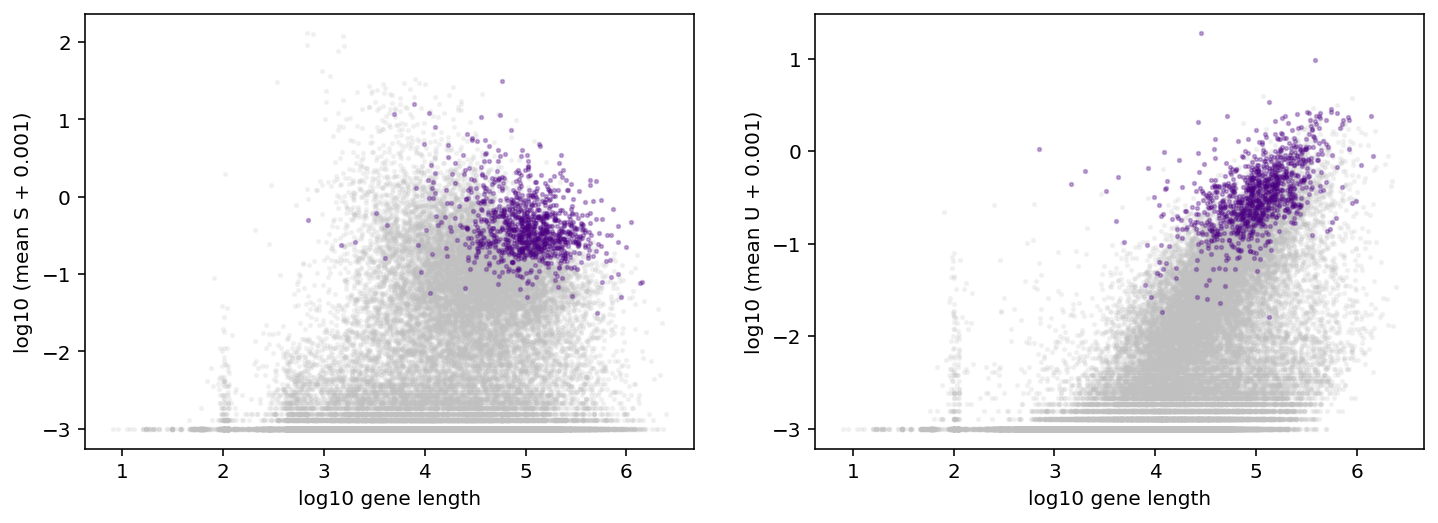

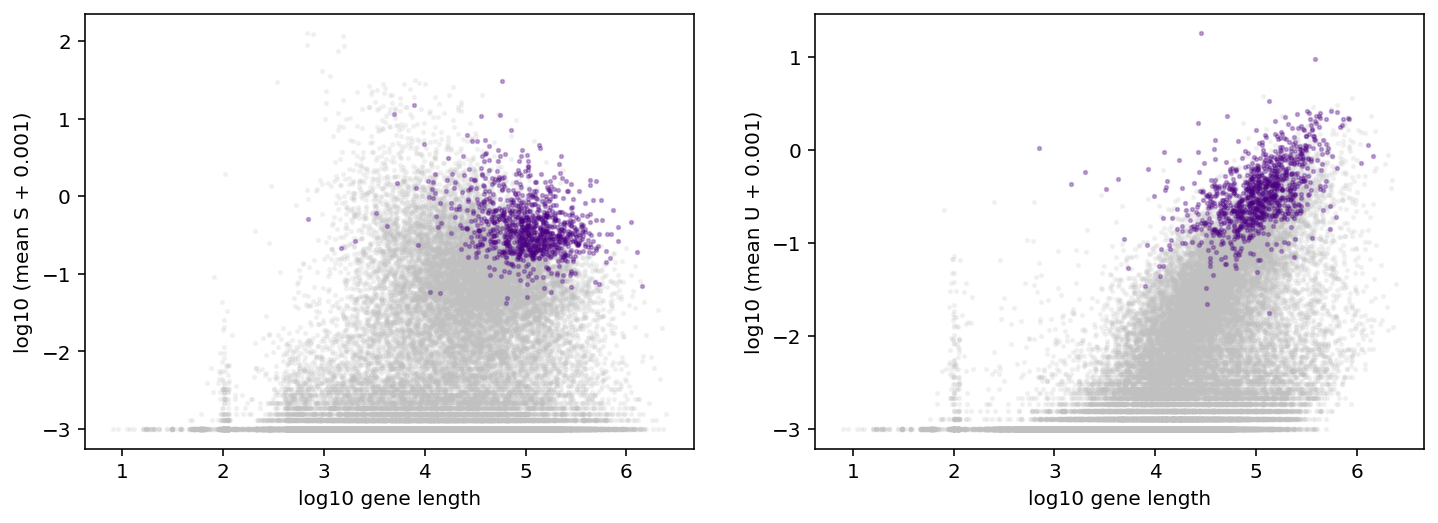

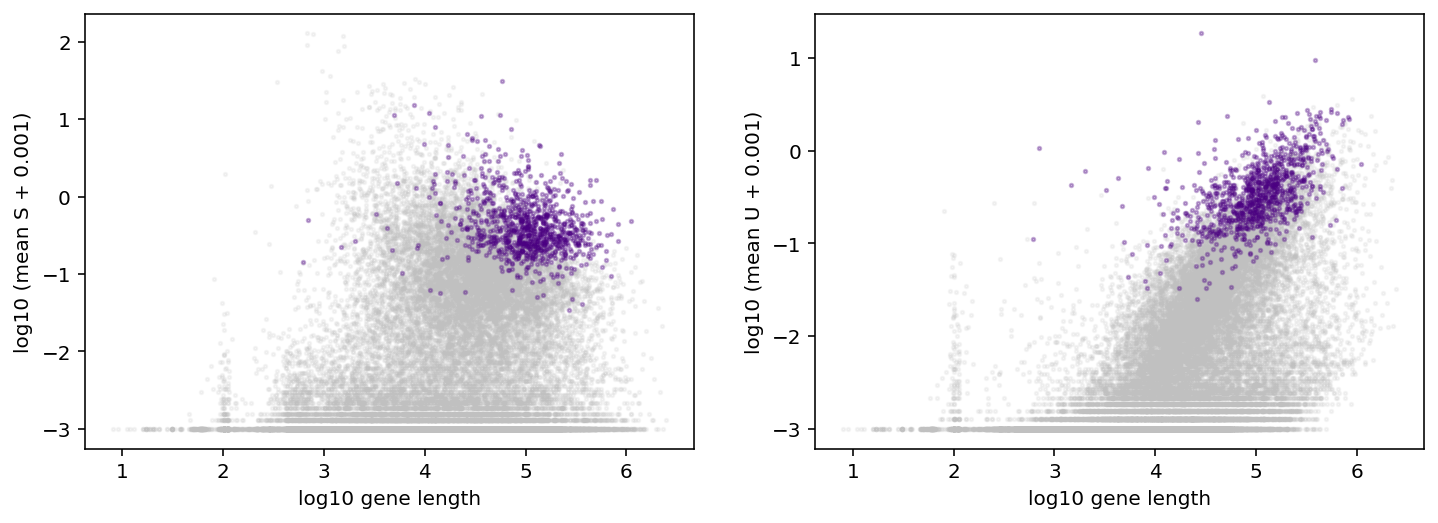

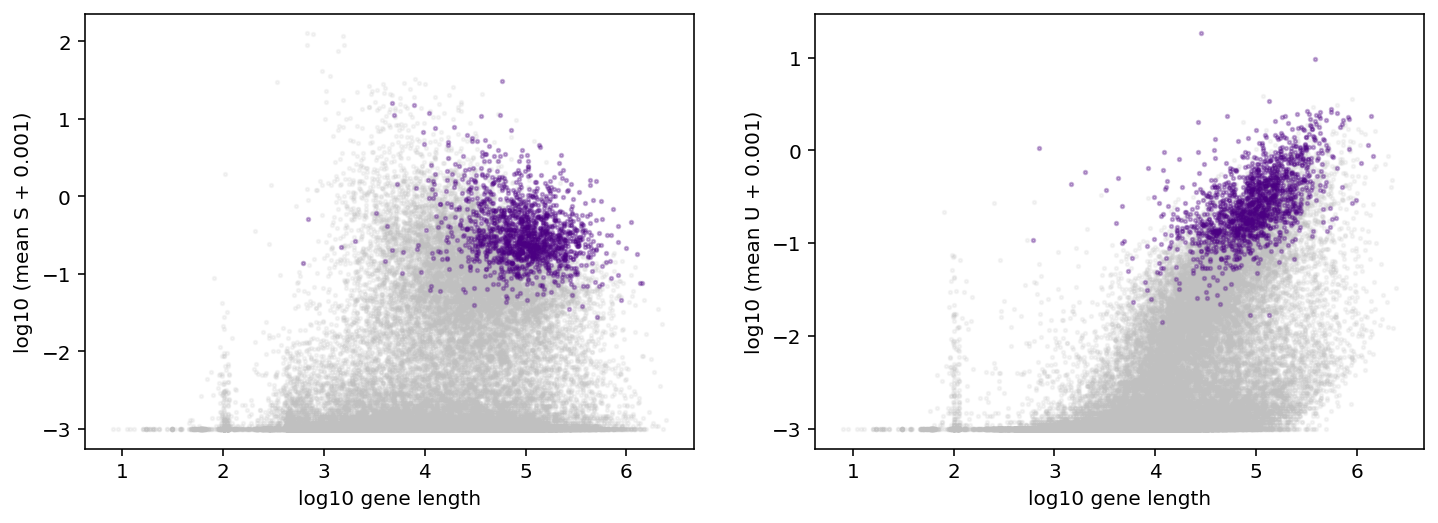

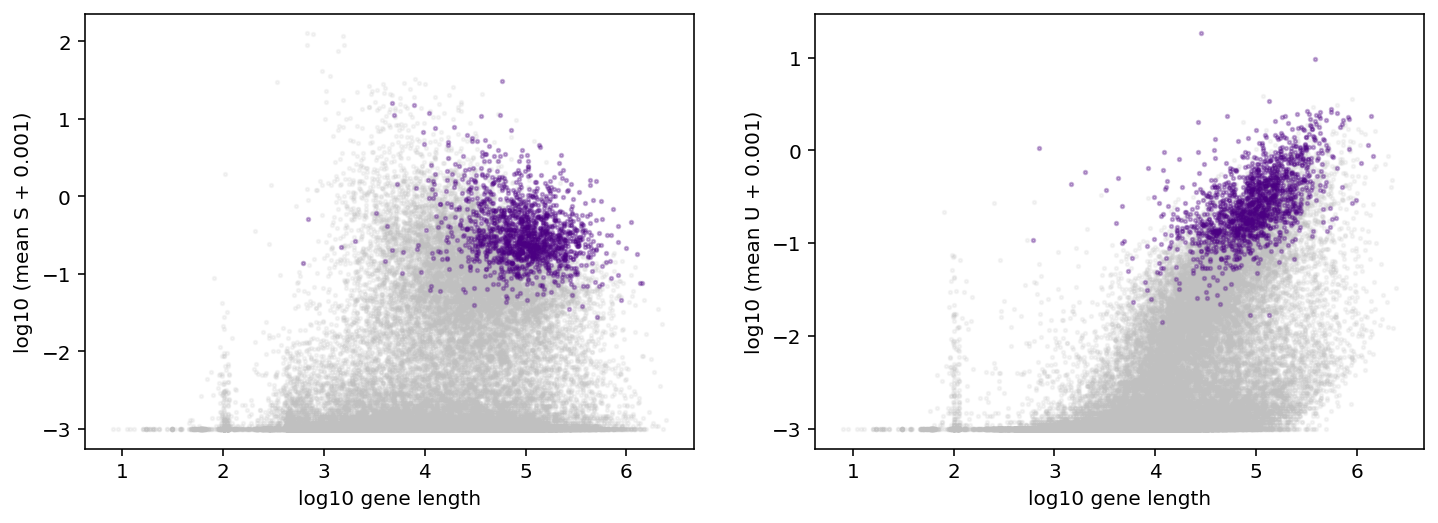

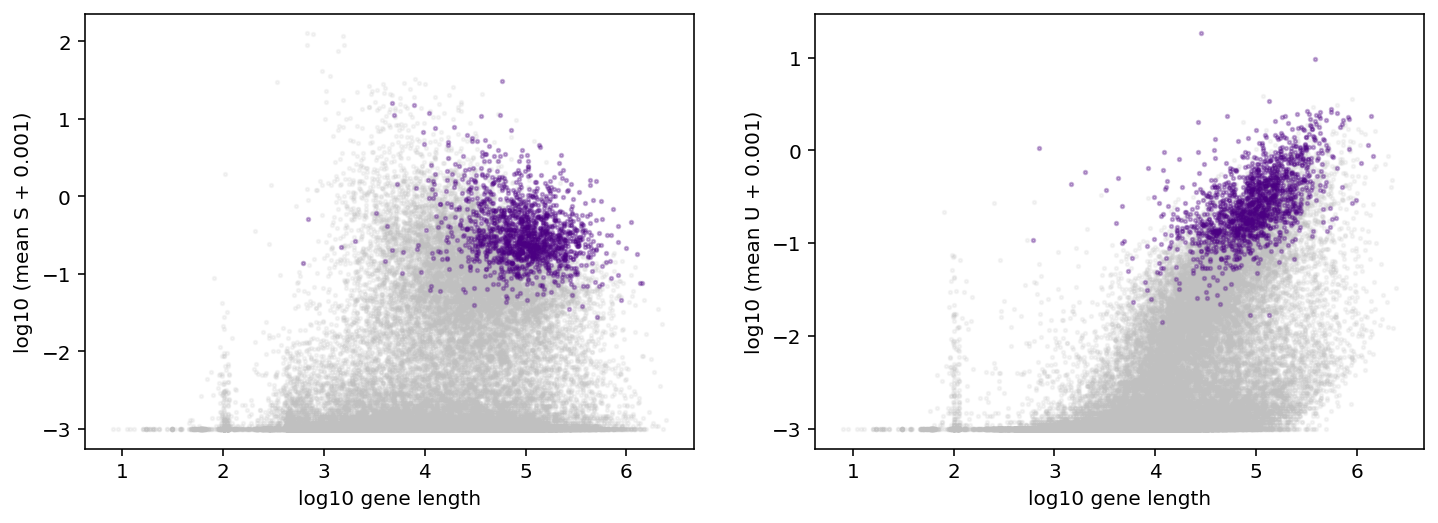

In [641]:
#Select to run inference on, same genes selected across all runs --> running over all, but could limit this to just K=5,10
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='meK_cancer_dt',batch_id=1,\
                                             datestring='230922', n_genes=len(g_names[final_filt]),\
                                             exp_filter_threshold=None,cf=cf,
                                                             genes_to_fit=g_names[final_filt]) #len(all_gs_forinf)

In [642]:
result_strings = []
for i in range(4,num_ks): #Here only running meK-Means for K=5,10 not K=1

    #Define model with bursty transcription and Poisson molecule capture/sampling
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    #Set up mminference parameters
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

    #Read in loom file with filtered barcodes
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])

    #Run inference(fit_all_grid_points()) and Save result file strings
    full_result_string = inference_parameters.fit_all_grid_points(30,search_data) 

    result_strings.append(full_result_string)
    
    

INFO:root:Directory ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k5_run4/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k5_run4/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: meK_cancer_dt_k5_run4
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:Gene list extracted from ./fits/gg_230922_025_meK_cancer_dt_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k5_run4/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:09<00:00, 49.90s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:25<00:00, 53.10s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.16005905 0.15855522 0.2282101  0.36089693 0.0922787 ]
Q Function:  -17108589.730848882

INFO:root:EM Epoch 2/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:56<00:00, 47.24s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.16774202 0.10435145 0.28663874 0.41493116 0.02633663]
Q Function:  -17106471.104773287

INFO:root:EM Epoch 3/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:12<00:00, 50.51s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.08306809e-01 3.73894384e-02 3.30073388e-01 5.23835005e-01
 3.95359554e-04]
Q Function:  -17094258.394734014

INFO:root:EM Epoch 4/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:34<00:00, 68.52s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.55378362e-02 1.39161769e-02 3.55701449e-01 5.84844538e-01
 9.55292319e-11]
Q Function:  -17016155.32985194

INFO:root:EM Epoch 5/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:10<00:00, 83.52s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.08646483e-03 1.50437952e-10 3.42728015e-01 6.56185520e-01
 9.55292319e-11]
Q Function:  -16994351.706324805

INFO:root:EM Epoch 6/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [03:46<00:00, 113.29s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292319e-11 3.43163303e-01 6.56836697e-01
 9.55292319e-11]
Q Function:  -17072896.074212134

INFO:root:EM Epoch 7/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [04:04<00:00, 122.41s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292466e-11 3.41894920e-01 6.58105079e-01
 9.55292319e-11]
Q Function:  -17003367.333122734

INFO:root:EM Epoch 8/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [04:16<00:00, 128.27s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292320e-11 3.36975837e-01 6.63024163e-01
 9.55292319e-11]
Q Function:  -17031909.54625581

INFO:root:EM Epoch 9/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [04:25<00:00, 132.93s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55294870e-11 3.32110027e-01 6.67889972e-01
 9.55292319e-11]
Q Function:  -17051998.286917232

INFO:root:EM Epoch 10/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [04:07<00:00, 123.87s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55307349e-11 3.20285826e-01 6.79714174e-01
 9.55292319e-11]
Q Function:  -17028992.541378327

INFO:root:EM Epoch 11/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [03:40<00:00, 110.14s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292375e-11 3.18077343e-01 6.81922656e-01
 9.55292319e-11]
Q Function:  -17010216.054272555

INFO:root:EM Epoch 12/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [03:42<00:00, 111.50s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292321e-11 3.11396566e-01 6.88603433e-01
 9.55292319e-11]
Q Function:  -17045538.95941651

INFO:root:EM Epoch 13/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [03:46<00:00, 113.11s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292319e-11 3.05440087e-01 6.94559912e-01
 9.55292319e-11]
Q Function:  -17032742.564598814

INFO:root:EM Epoch 14/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [03:51<00:00, 115.87s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292319e-11 3.01959377e-01 6.98040623e-01
 9.55292319e-11]
Q Function:  -17020898.71655312

INFO:root:EM Epoch 15/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [04:12<00:00, 126.01s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292320e-11 2.95560171e-01 7.04439829e-01
 9.55292319e-11]
Q Function:  -17010479.584497493

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k5_run4/Bursty_Poisson_1x1/analysis_figures_2 already exists.
INFO:root:Directory ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k5_run4/Bursty_Poisson_1x1/analysis_figures_3 already exists.
INFO:root:Runtime: 4240.2 seconds.
INFO:root:Directory ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k10_run5/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k10_run5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: meK_cancer_dt_k10_run5
INFO:root:36601 features observed, 36169 match genome annotations. 36149 were unique.
INFO:root:Gene list extracted from ./fits/gg_230922_025

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:59<00:00, 23.96s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:24<00:00, 26.46s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.06834406 0.01061536 0.11772692 0.13157104 0.10833784 0.14466253
 0.00778554 0.1236045  0.16722389 0.12012833]
Q Function:  -17511373.97218419

INFO:root:EM Epoch 2/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:33<00:00, 30.38s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.55420647e-02 9.55293502e-05 1.71418985e-01 1.03299983e-01
 9.43166219e-02 2.19348118e-01 9.55292319e-11 1.47693447e-01
 1.22263786e-01 9.60214648e-02]
Q Function:  -17226342.95924096

INFO:root:EM Epoch 3/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:15<00:00, 31.99s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [5.37309517e-03 9.55292319e-11 1.79275401e-01 1.17316473e-01
 1.14013798e-01 3.77078378e-01 9.55292319e-11 1.59986937e-01
 1.27290432e-02 3.42268741e-02]
Q Function:  -17331642.900332812

INFO:root:EM Epoch 4/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [04:20<00:00, 43.50s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292319e-11 9.83621565e-02 1.33260811e-01
 1.07585401e-01 4.62801000e-01 9.55292319e-11 1.96295287e-01
 9.69363580e-10 1.69534317e-03]
Q Function:  -17146800.352898847

INFO:root:EM Epoch 5/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:12<00:00, 50.45s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292319e-11 8.45303269e-02 9.89708774e-02
 8.43801029e-02 5.38098244e-01 9.55292319e-11 1.94020448e-01
 9.55292319e-11 9.55292319e-11]
Q Function:  -17133120.257261842

INFO:root:EM Epoch 6/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:31<00:00, 54.20s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292319e-11 2.13830062e-02 9.86442274e-02
 7.27601454e-02 5.97128079e-01 9.55292319e-11 2.10084541e-01
 9.55292319e-11 9.55292319e-11]
Q Function:  -17152502.84941808

INFO:root:EM Epoch 7/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:24<00:00, 66.20s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292319e-11 1.13226642e-07 7.32923138e-02
 3.81335885e-02 6.41951233e-01 9.55292319e-11 2.46622751e-01
 9.55292319e-11 9.55292319e-11]
Q Function:  -17208033.3730933

INFO:root:EM Epoch 8/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:04<00:00, 61.16s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292319e-11 9.55563505e-11 3.99611945e-02
 1.57489863e-03 6.50870549e-01 9.55292319e-11 3.07593357e-01
 9.55292319e-11 9.55292319e-11]
Q Function:  -17177313.4602648

INFO:root:EM Epoch 9/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:10<00:00, 83.53s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292319e-11 9.55292403e-11 1.40580202e-03
 9.55292319e-11 6.60951579e-01 9.55292319e-11 3.37642619e-01
 9.55292319e-11 9.55292319e-11]
Q Function:  -17141566.890978046

INFO:root:EM Epoch 10/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [03:52<00:00, 116.08s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292319e-11 9.55292349e-11 9.55292319e-11
 9.55292319e-11 6.54863753e-01 9.55292319e-11 3.45136247e-01
 9.55292319e-11 9.55292319e-11]
Q Function:  -17107435.583934028

INFO:root:EM Epoch 11/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [03:50<00:00, 115.05s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292319e-11 9.55292319e-11 9.55292319e-11
 9.55292319e-11 6.69066468e-01 9.55292319e-11 3.30933532e-01
 9.55292319e-11 9.55292319e-11]
Q Function:  -17032025.999149416

INFO:root:EM Epoch 12/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [03:54<00:00, 117.18s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292319e-11 9.55292319e-11 9.55292319e-11
 9.55292319e-11 6.73349375e-01 9.55292319e-11 3.26650624e-01
 9.55292319e-11 9.55292319e-11]
Q Function:  -17052007.191882256

INFO:root:EM Epoch 13/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [03:50<00:00, 115.11s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292319e-11 9.55292319e-11 9.55292319e-11
 9.55292319e-11 6.78728526e-01 9.55292319e-11 3.21271473e-01
 9.55292319e-11 9.55292319e-11]
Q Function:  -17026626.44557667

INFO:root:EM Epoch 14/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [03:47<00:00, 113.67s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292319e-11 9.55292319e-11 9.55292319e-11
 9.55292319e-11 6.76746711e-01 9.55292319e-11 3.23253288e-01
 9.55292319e-11 9.55292319e-11]
Q Function:  -17018015.599174798

INFO:root:EM Epoch 15/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [03:47<00:00, 113.74s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292319e-11 9.55292319e-11 9.55292319e-11 9.55292319e-11
 9.55292319e-11 6.89682082e-01 9.55292319e-11 3.10317918e-01
 9.55292319e-11 9.55292319e-11]
Q Function:  -17037663.3336934

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k10_run5/Bursty_Poisson_1x1/analysis_figures_5 already exists.
INFO:root:Directory ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k10_run5/Bursty_Poisson_1x1/analysis_figures_7 already exists.
INFO:root:Runtime: 4344.8 seconds.
INFO:root:Directory ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k15_run6/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k15_run6/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: meK_cancer_dt_k15_run6
INFO:root:36601 features observed, 36169 match genome annotations

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [04:17<00:00, 17.14s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [04:24<00:00, 17.62s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.08381617 0.10609252 0.0015115  0.04700928 0.03211723 0.13839596
 0.02883457 0.07571122 0.049335   0.01098883 0.14046325 0.09797619
 0.03624515 0.03478034 0.11672279]
Q Function:  -17718486.369666293

INFO:root:EM Epoch 2/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:39<00:00, 23.33s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [8.24953890e-02 5.64945246e-02 9.55292318e-11 8.79318628e-09
 1.91146914e-04 6.98083246e-02 5.95338460e-03 7.69393936e-02
 5.22279984e-03 9.55292318e-11 2.12011345e-01 1.41967805e-01
 3.66017909e-03 1.80258726e-02 3.27229827e-01]
Q Function:  -17401787.801011223

INFO:root:EM Epoch 3/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:25<00:00, 33.16s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.64839142e-02 4.01622984e-02 9.55292318e-11 9.55292318e-11
 9.55292318e-11 2.42977619e-04 9.55292318e-11 8.08942265e-03
 9.55292318e-11 9.55292318e-11 3.42927986e-01 2.11000546e-01
 9.55292318e-11 2.51284767e-04 3.50841569e-01]
Q Function:  -17242684.591629285

INFO:root:EM Epoch 4/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:14<00:00, 50.93s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.70675514e-04 2.39443591e-03 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 3.66993818e-01 2.43463949e-01
 9.55292318e-11 9.55292318e-11 3.86777120e-01]
Q Function:  -17149669.487692017

INFO:root:EM Epoch 5/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:49<00:00, 76.42s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 3.97377568e-01 2.10063501e-01
 9.55292318e-11 9.55292318e-11 3.92558930e-01]
Q Function:  -17015891.67915145

INFO:root:EM Epoch 6/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:50<00:00, 76.95s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 4.41713839e-01 1.83238410e-01
 9.55292318e-11 9.55292318e-11 3.75047751e-01]
Q Function:  -17026604.015190747

INFO:root:EM Epoch 7/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:51<00:00, 77.15s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 5.26148568e-01 1.78387787e-01
 9.55292318e-11 9.55292318e-11 2.95463644e-01]
Q Function:  -17055454.337818354

INFO:root:EM Epoch 8/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:50<00:00, 76.91s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 5.68156626e-01 1.57865372e-01
 9.55292318e-11 9.55292318e-11 2.73978001e-01]
Q Function:  -17021168.239518084

INFO:root:EM Epoch 9/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:51<00:00, 77.09s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 5.85486112e-01 1.43299563e-01
 9.55292318e-11 9.55292318e-11 2.71214323e-01]
Q Function:  -17053533.95240964

INFO:root:EM Epoch 10/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:53<00:00, 77.98s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 6.20813868e-01 1.24774477e-01
 9.55292318e-11 9.55292318e-11 2.54411654e-01]
Q Function:  -17040944.32141804

INFO:root:EM Epoch 11/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:51<00:00, 77.08s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 6.29616741e-01 1.13946547e-01
 9.55292318e-11 9.55292318e-11 2.56436711e-01]
Q Function:  -17113751.351823304

INFO:root:EM Epoch 12/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:03<00:00, 81.00s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 6.36256067e-01 9.62103755e-02
 9.55292318e-11 9.55292318e-11 2.67533557e-01]
Q Function:  -17152261.243905444

INFO:root:EM Epoch 13/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:15<00:00, 85.12s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 6.37544887e-01 7.81278952e-02
 9.55292318e-11 9.55292318e-11 2.84327217e-01]
Q Function:  -17160667.395265426

INFO:root:EM Epoch 14/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:13<00:00, 84.43s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 6.46038927e-01 6.10634740e-02
 9.55292318e-11 9.55292318e-11 2.92897598e-01]
Q Function:  -17152117.679686356

INFO:root:EM Epoch 15/15: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:14<00:00, 84.76s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 9.55292318e-11 9.55292318e-11
 9.55292318e-11 9.55292318e-11 6.49130039e-01 2.86478526e-02
 9.55292318e-11 9.55292318e-11 3.22222107e-01]
Q Function:  -17124041.309826568

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k15_run6/Bursty_Poisson_1x1/analysis_figures_10 created.
INFO:root:Directory ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k15_run6/Bursty_Poisson_1x1/analysis_figures_11 created.
INFO:root:Directory ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k15_run6/Bursty_Poisson_1x1/analysis_figures_14 created.
INFO:root:Runtime: 4420.0 seconds.


In [643]:
#DOes more genes --> more clusters? Try doubling to top 200?

#Read in result files for K=1,5,7 runs
sr = []
for strings in result_strings:
    sr += [[monod.analysis.load_search_results(i) for i in strings]]

sr

INFO:root:Grid scan results loaded from ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k5_run4/Bursty_Poisson_1x1/grid_scan_results_2.res.
INFO:root:Grid scan results loaded from ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k5_run4/Bursty_Poisson_1x1/grid_scan_results_3.res.
INFO:root:Grid scan results loaded from ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k10_run5/Bursty_Poisson_1x1/grid_scan_results_5.res.
INFO:root:Grid scan results loaded from ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k10_run5/Bursty_Poisson_1x1/grid_scan_results_7.res.
INFO:root:Grid scan results loaded from ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k15_run6/Bursty_Poisson_1x1/grid_scan_results_10.res.
INFO:root:Grid scan results loaded from ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k15_run6/Bursty_Poisson_1x1/grid_scan_results_11.res.
INFO:root:Grid scan results loaded from ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k15_run6/Bursty_Poisson_1x1/grid_scan_results

[[<monod.mminference.SearchResults at 0x7f25b7b49b10>,

In [644]:
raws = [d_string+'/raw.sd' for d_string in dataset_strings[4:]]
sd = [monod.analysis.load_search_data(w) for w in raws]
sd

INFO:root:Search data loaded from ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k5_run4/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k10_run5/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230922_025_meK_cancer_dt_1/meK_cancer_dt_k15_run6/raw.sd.


## **Assess Results of meK-Means**

In [645]:
def check_at_bounds(phys_params,thr=0.01):
    #Check for genes where parameter fits are close to boundary of grid
    x = np.any(np.logical_or(
        np.array(phys_lb)+thr > phys_params,
        np.array(phys_ub)-thr < phys_params) ,1)
    return x

In [646]:
def vis_metrics(results,title,ks,figsize=(18, 5),s=50,save_file=None):
    '''
    Visualize -Q function and KLD over epochs, and -AIC for final model inference

    results: list of len num_ks, of lists of SearchResults objs per K tested (e.g. [[SearchResults],[SearchResults,SearchResults]] for K=1&2)
    title: title string for leftmost, plot
    ks: list of ks tested (e.g. [1,2])
    figsize: tuple for size of figure
    s: size of dots in scatterplot
    save_file: string, output file to save image

  '''

    num_ks = len(results)
    sets = []
    qs = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()

    aic = []
    fin_k = []
    kls = []

    epoch = len(results[0][0].all_qs.flatten())
    epos = list(range(1,epoch+1))*num_ks

    for i in range(num_ks):

        qs += list(-1*results[i][0].all_qs.flatten())
        sets += [ks[i]]*epoch
        aic += [results[i][0].aic[0]]
        fin_k += [len(results[i])]


        concat_klds = []
        ks_used = []
        for r in results[i]:
            concat_klds += [r.all_klds[0,:,:]]
            ks_used += [r.assigns]

        concat_klds = np.array(concat_klds)
        concat_klds = concat_klds.reshape((concat_klds.shape[1], concat_klds.shape[2],concat_klds.shape[0]))

        kls += list(np.mean(np.sum(concat_klds[:,:,:],axis=1),axis=1)) #Sum of klds across k clusters


    res['Q'] = qs
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]

    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k

    #Plot Q function over epochs
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)

    sns.lineplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    g1=sns.scatterplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('-Q')
    ax[0].legend(
          title='Set K')
    ax[0].set_title(title)
    sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))


    #Plot klds over epochs
    g2=sns.lineplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')
    ax[1].legend(
          title='Set K')
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))



    #Plot aics
    g3=sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final Assigned k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='Set K')
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if save_file is None:
        plt.show()
    else:
        plt.savefig(save_file)


In [647]:
#Plot cluster concordance with true labels and distribution of clusters

def vis_assign(assign,true=None,title='',figsize=(18, 5),save_file=None):
    '''
    Plot distribution of cluster assignments (optional: with previous annotations)

    assign: np.array of cluster assignments (1..k) for each cell
    true: list of user-given cluster assignments (string) for each cell, optional
    title: title string for cluster assignment plot
    figsize: tuple for size of figure
    save_file: string, output file to save image

    '''

    true_copy = list(true)
    assign_copy = list(assign)

    #Plot cluster assignments and distribution of sizes of each cluster
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    if true is not None:
        hues = true
    else:
        hues = assign_copy

    g= sns.histplot(x=assign,hue=hues,hue_order=list(np.unique(hues)), kde=False,ax=ax,
                    palette='tab20',multiple="dodge",
                    discrete=True)

    plt.xticks(np.arange(0,np.max(assign)+1))


    ax.set_xlabel('meK-Means Cluster Assignment')
    ax.set_title(title)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if save_file is None:
        plt.show()
    else:
        plt.savefig(save_file)



In [648]:
#Plot param distributions for specified clusters

def vis_params(param_estimates,assigns_toplot = [],title='',figsize=(18, 5),to_filt=True,save_fig=None,pal=sns.color_palette("Set2")+sns.color_palette("Pastel1")+sns.color_palette("Set3")):
    
    #Plot param distributions
    pal =  pal
    palette = {0:pal[0], 1:pal[1] ,2:pal[2] , 3:pal[3] , 4:pal[4] , 
               5:pal[5] , 6:pal[6] , 7:pal[7] , 8:pal[8] , 9:pal[9],
              10:pal[10], 11:pal[11] ,12:pal[12] , 13:pal[13] , 14:pal[14] , 
               15:pal[15] , 16:pal[16] , 17:pal[17] , 18:pal[18] , 19:pal[19]}

    if len(assigns_toplot) < 1:
        assigns_toplot = range(param_estimates.shape[0])
        
       
    bs = []
    betas = []
    gammas = []
    clus = []
    for a in assigns_toplot:
        if to_filt:
            filt = ~check_at_bounds(param_estimates[a,:,:] ,thr=0.01)
        else:
            filt = np.array([True]*param_estimates[a,:,:].shape[0]) 
        bs += list(param_estimates[a,filt,0])
        betas += list(param_estimates[a,filt,1])
        gammas += list(param_estimates[a,filt,2])
        clus += [a]*param_estimates[a,filt,0].shape[0]
        
    res = pd.DataFrame()
    res['b'] = bs
    res['beta'] = betas
    res['gamma'] = gammas
    res['Assignment'] = clus
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    g1=sns.histplot(data=res, x='b',hue='Assignment', kde=False,ax=ax[0],
                 palette=palette,multiple="dodge",legend=False,stat='density')
    ax[0].set_xlabel('b',fontsize=14)
    ax[0].set_ylabel('Density',fontsize=14)
    ax[0].set_title(title)
    ax[0].tick_params(axis='both', which='major', labelsize=14,)
    
    g2=sns.histplot(data=res, x='beta',hue='Assignment', kde=False,ax=ax[1],
                 palette=palette,multiple="dodge",legend=False,stat='density')
    ax[1].set_xlabel('beta',fontsize=14)
    ax[1].set_ylabel('Density',fontsize=14)
    ax[1].tick_params(axis='both', which='major', labelsize=14,)
    
    g3=sns.histplot(data=res, x='gamma',hue='Assignment', kde=False,ax=ax[2],
                 palette=palette,multiple="dodge",stat='density')
    ax[2].set_xlabel('gamma',fontsize=14)
    ax[2].set_ylabel('Density',fontsize=14)
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))
    ax[2].tick_params(axis='both', which='major', labelsize=14,)
    
    plt.tight_layout()
    if save_fig is None:
        plt.show()
    else:
        plt.savefig(save_fig)
    
    return res
    

In [649]:
#Plot correlation of inferred means to observed means
def plot_means(sd,sr,res_inds=[0,0],clus_inds=[0,0],figsize=(18,18),save_fig=None):
    c_filt = sr[res_inds[1]][clus_inds[1]].filt
    
    true_s = sd[res_inds[0]].layers[1,:,c_filt] #gene x cell
    true_u = sd[res_inds[0]].layers[0,:,c_filt]
    mean_s = np.mean(true_s,axis=0)
    mean_u = np.mean(true_u,axis=0)
    print(mean_u.shape)

    mm = sr[res_inds[1]][clus_inds[1]].param_estimates[0,:,:] #genes x params
    
    filt = ~check_at_bounds(mm,thr=0.01)
    
    mm_u = (mm[:,0]+(samp_ub[0]+sd[res_inds[0]].gene_log_lengths))-mm[:,1]
    mm_s = (mm[:,0]+samp_ub[1])-mm[:,2]
    print(mm_s.shape)


    
    rho =[]
    p = []   
    
    #Plot param histograms
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    g=sns.scatterplot(y=list(mean_u[filt & (mean_u!=0)]),x=list(10**mm_u[filt & (mean_u!=0)]),
                    s=70,edgecolor='black',color='#FFCCCC', alpha=0.8,ax=ax[0])
    ax[0].tick_params(axis='both', which='major', labelsize=14,)
   
    
    rho += [np.corrcoef(list(np.log(mean_u[filt & (mean_u!=0)])),list(np.log(10**mm_u[filt & (mean_u!=0)])))[0,1]]
    p += [scipy.stats.spearmanr(list(mean_u[filt & (mean_u!=0)]),list(10**mm_u[filt & (mean_u!=0)]))[0]]
    
    ax[0].set_xlabel('meK-Means '+r'$\mu_U$',fontsize=14)
    ax[0].set_ylabel('Obs '+r'$\mu_U$',fontsize=14)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')

    
    
    g2=sns.scatterplot(y=list(mean_s[filt & (mean_s!=0)]),x=list(10**mm_s[filt & (mean_s!=0)]),
                    s=70,edgecolor='black',color='#003366', alpha=0.6,ax=ax[1])
    ax[1].tick_params(axis='both', which='major', labelsize=14,)
   
    
    rho += [np.corrcoef(list(np.log(mean_s[filt & (mean_s!=0)])),list(np.log(10**mm_s[filt & (mean_s!=0)])))[0,1]]
    p += [scipy.stats.spearmanr(list(mean_s[filt & (mean_s!=0)]),list(10**mm_s[filt & (mean_s!=0)]))[0]]
    
    ax[1].set_xlabel('meK-Means '+r'$\mu_S$',fontsize=14)
    ax[1].set_ylabel('Obs '+r'$\mu_S$',fontsize=14)
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    
    for i, a in enumerate(ax.flat):

       
        bot,top = a.get_ylim()
        l,r = a.get_xlim()

        newl = np.min([bot,l])
        newr = np.max([top,r])

        a.set_xlim((newl,newr))
        a.set_ylim((newl,newr))

        a.text(.05,.7,r'$r$ = {:.2f}'.format(rho[i]),fontsize=14,transform=a.transAxes)
        a.text(.05,.85,r'$\rho$ = {:.2f}'.format(p[i]),fontsize=14,transform=a.transAxes)

        a.plot(a.get_xlim(),a.get_xlim(),'--',color=[116/255,112/255,113/255],linewidth=3,alpha=0.4)

        
    plt.tight_layout()
    if save_fig is None:
        plt.show()
    else:
        plt.savefig(save_fig)

    
    

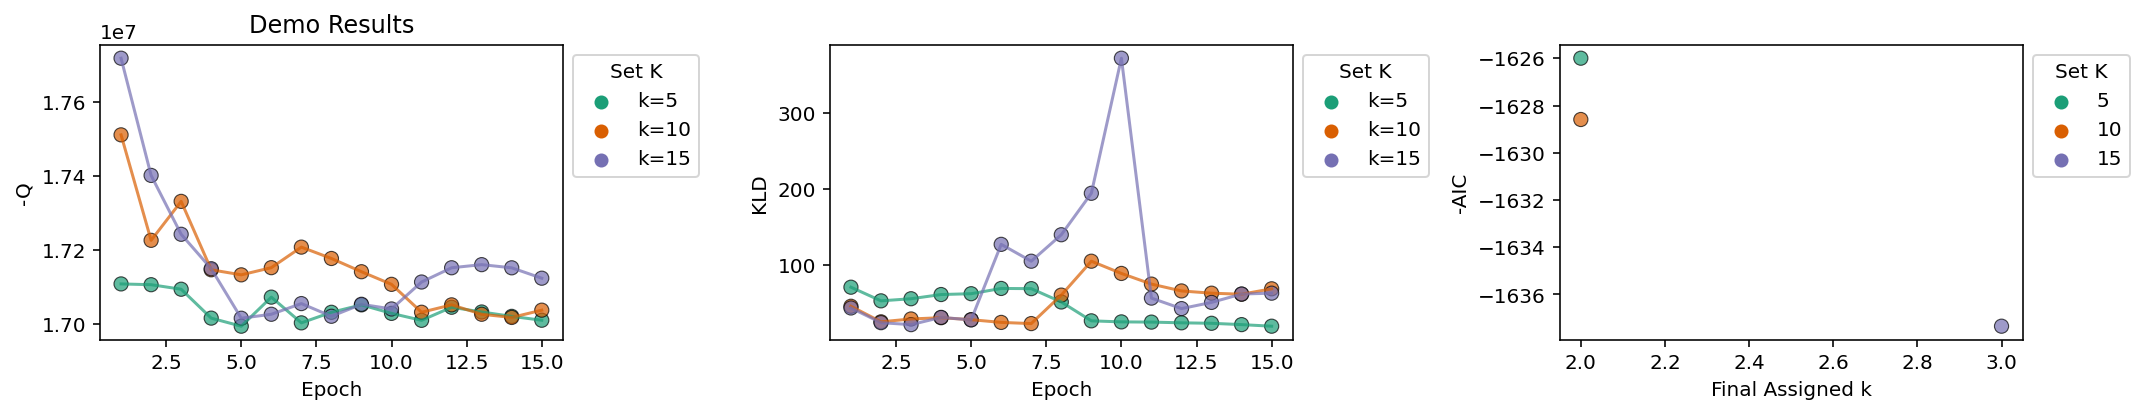

In [650]:
vis_metrics(sr,'Demo Results',ks[4:],figsize=(15,3))

In [651]:
#Concatenate cell cluster assignments across all cells and cluster result files
mek_assigns = []
for which_res in range(len(sr)):
    k_res = sr[which_res] #Get all result files for model
    cat_assigns = np.array([None]*int(np.sum(cf[which_res+4]))) #cat_assigns is empty list of length = no. cell barcodes (after umi filtering)
    for i in range(len(k_res)):
        r = k_res[i]
        cat_assigns[r.filt] = r.assigns #denotes with cluster k cells were assigned to

    mek_assigns += [cat_assigns]

len(mek_assigns)

3

In [652]:
#Get 'original' cell type assignments for the filtered barcodes/cells, from Yao et al. 2021
all_assigns = mek_assigns

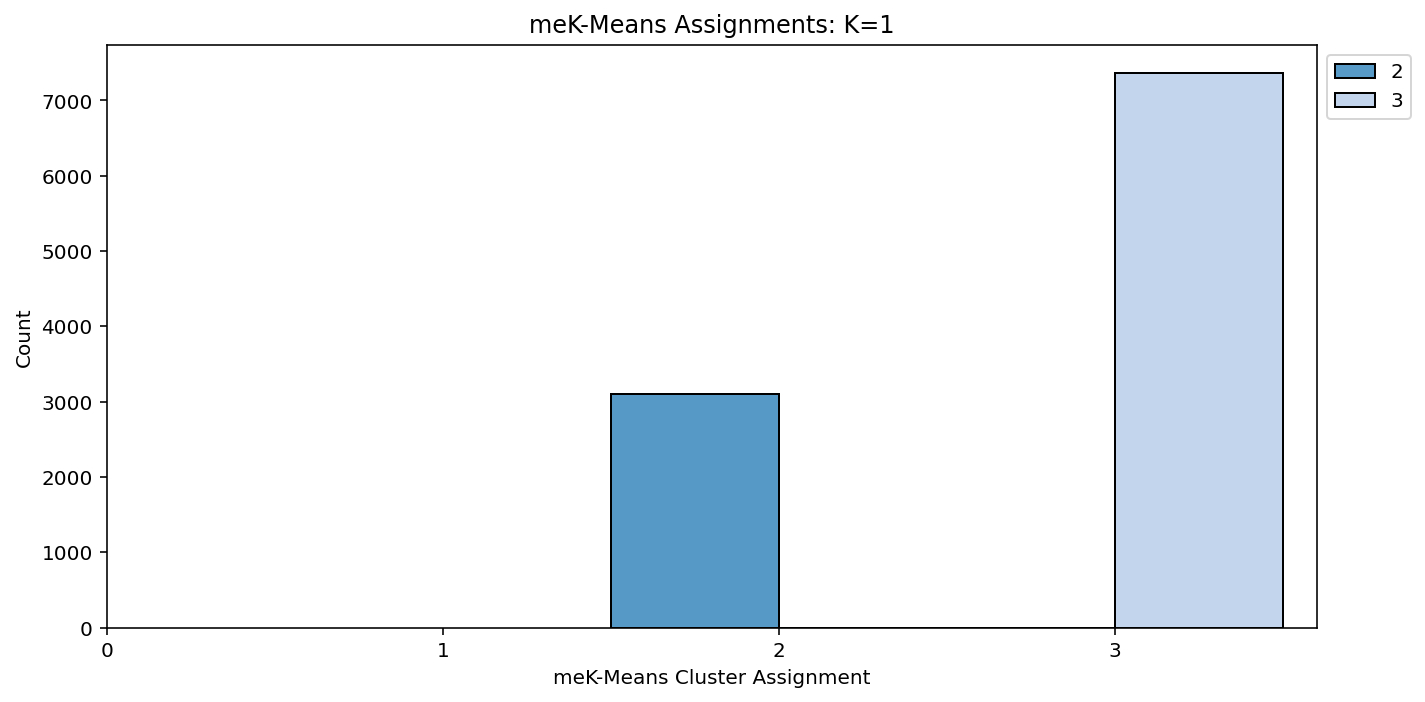

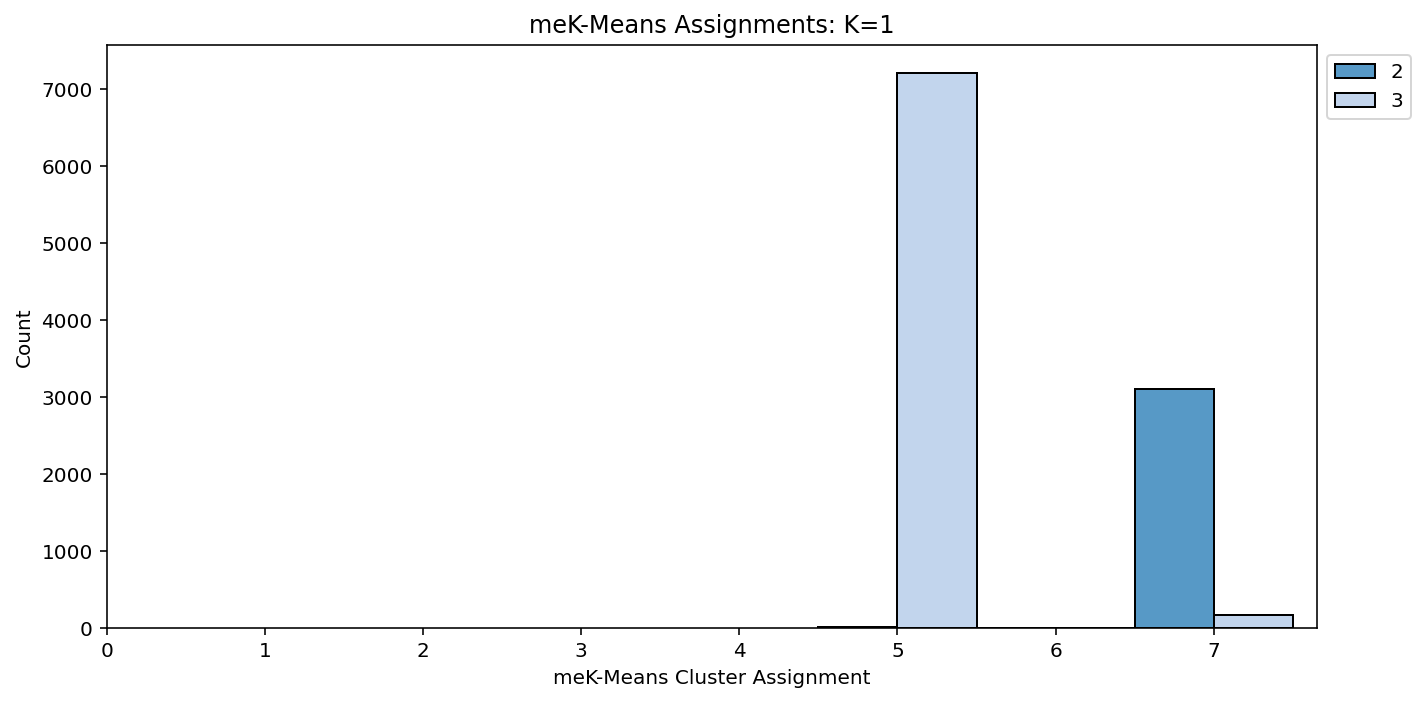

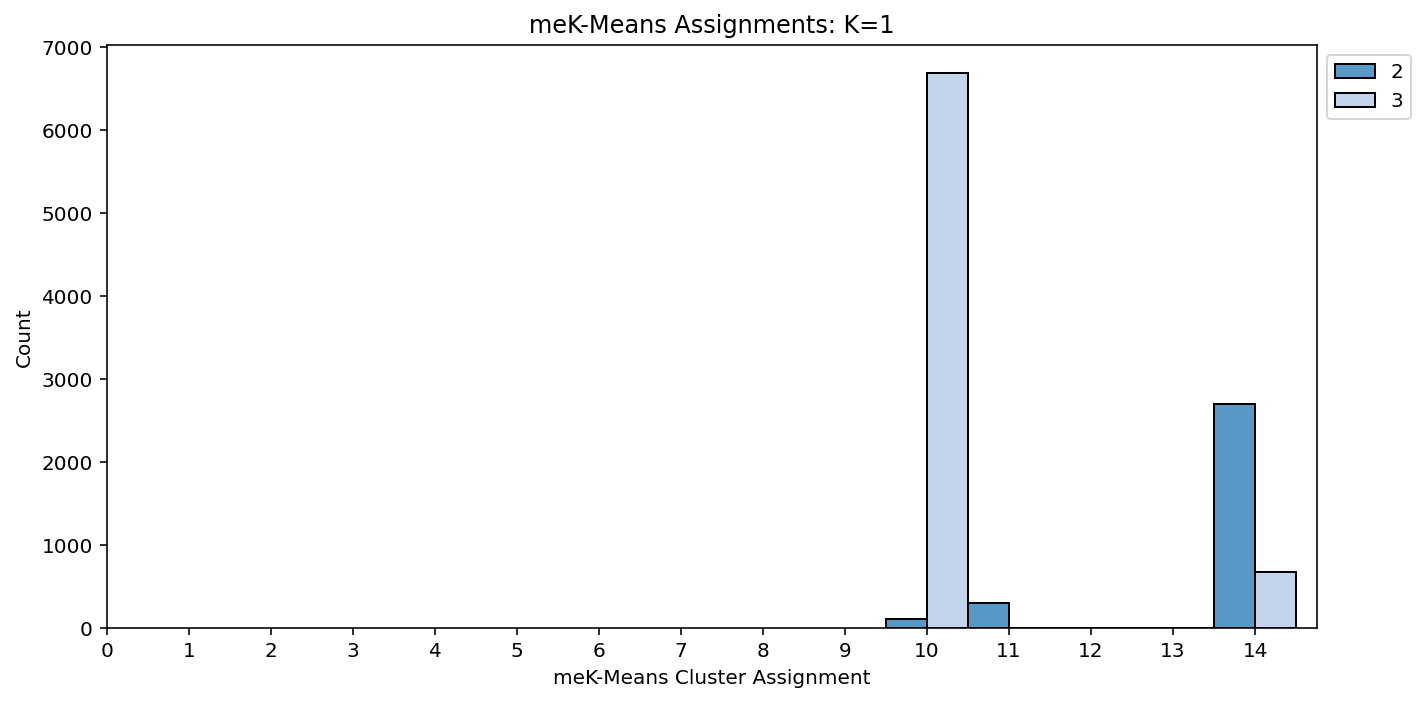

In [653]:
for i in range(len(mek_assigns)):
    m = mek_assigns[i]
    vis_assign(m,true=mek_assigns[0],title='meK-Means Assignments: K='+str(ks[i]),figsize=(10,5))

In [654]:
from sklearn.cluster import KMeans

In [655]:
new_S = search_data.layers[0,:,:]
S_t = new_S.T
tots = np.sum(S_t,axis=1)
divids = (1e4/tots)[:,None]
S_t = S_t*divids
S_t = np.log1p(S_t)

kmeans = KMeans(n_clusters=5, random_state=0).fit(S_t)
labs = kmeans.labels_


<AxesSubplot:ylabel='Count'>

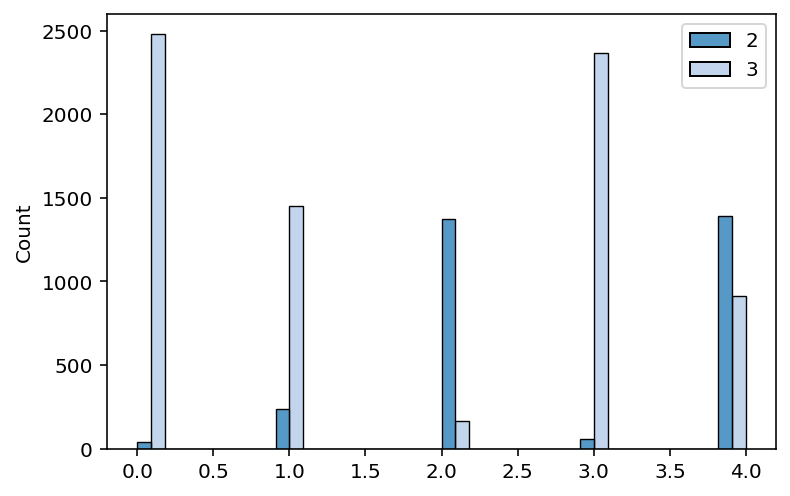

In [656]:
sns.histplot(x=labs,hue=mek_assigns[0],palette='tab20',multiple='dodge')


In [657]:
new_S = search_data.layers[1,:,:]
S_t = new_S.T
tots = np.sum(S_t,axis=1)
divids = (1e4/tots)[:,None]
S_t = S_t*divids
S_t = np.log1p(S_t)

kmeans = KMeans(n_clusters=5, random_state=0).fit(S_t)
labs2 = kmeans.labels_


<AxesSubplot:ylabel='Count'>

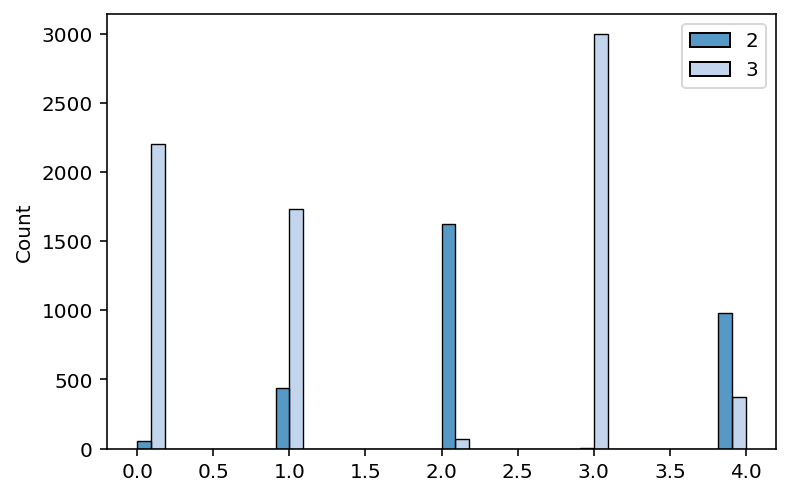

In [658]:
sns.histplot(x=labs2,hue=mek_assigns[0],palette='tab20',multiple='dodge')


In [659]:
import igraph as ig
import leidenalg as la
from sklearn.neighbors import kneighbors_graph

A = kneighbors_graph(S_t, 30, mode='connectivity', include_self=True)
sources, targets = A.nonzero()
weights = A[sources, targets]
if isinstance(weights, np.matrix):
    weights = weights.A1
g = ig.Graph(directed=False) #True in scanpy, which is odd
g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
g.add_edges(list(zip(sources, targets)))

g.es['weight'] = weights

partition_type = la.RBConfigurationVertexPartition


part = la.find_partition(g, partition_type, 
                                weights=np.array(g.es['weight']).astype(np.float64), 
                                n_iterations=-1, resolution_parameter=1.0)


labels = np.array(part.membership)
    

<AxesSubplot:ylabel='Count'>

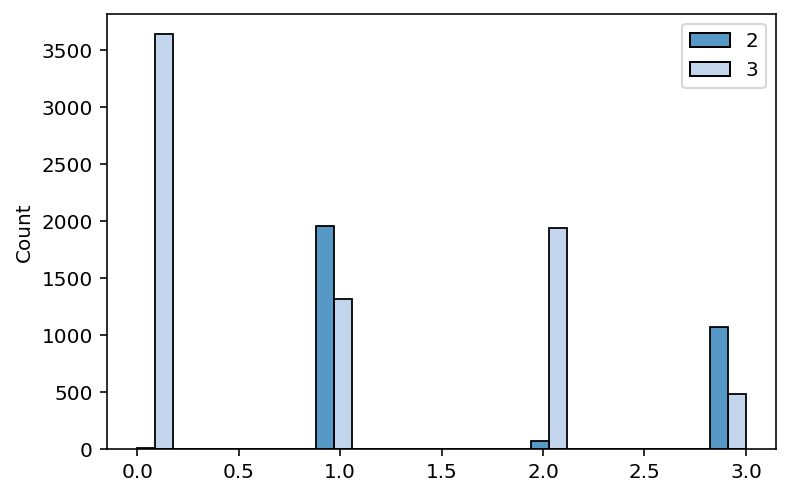

In [660]:
sns.histplot(x=labels,hue=mek_assigns[0],palette='tab20',multiple='dodge')

**Compare Expression of Original Study Markers**

In [739]:
#Select result to analyze
chosen = 0
n_genes = sr[chosen][0].n_genes
n_phys_pars = sr[chosen][0].sp.n_phys_pars
par_vals_uncorrected = np.zeros((len(sr[chosen]),n_genes,n_phys_pars))

#filt = ~sr_arr[0].rejected_genes
#par_vals_uncorrected[0,:,:] = sr_arr[0].phys_optimum

for j in range(len(sr[chosen])):
    par_vals_uncorrected[j,:,:] = sr[chosen][j].param_estimates[0,:,:]
    #filt = filt & ~sr_arr[j].rejected_genes

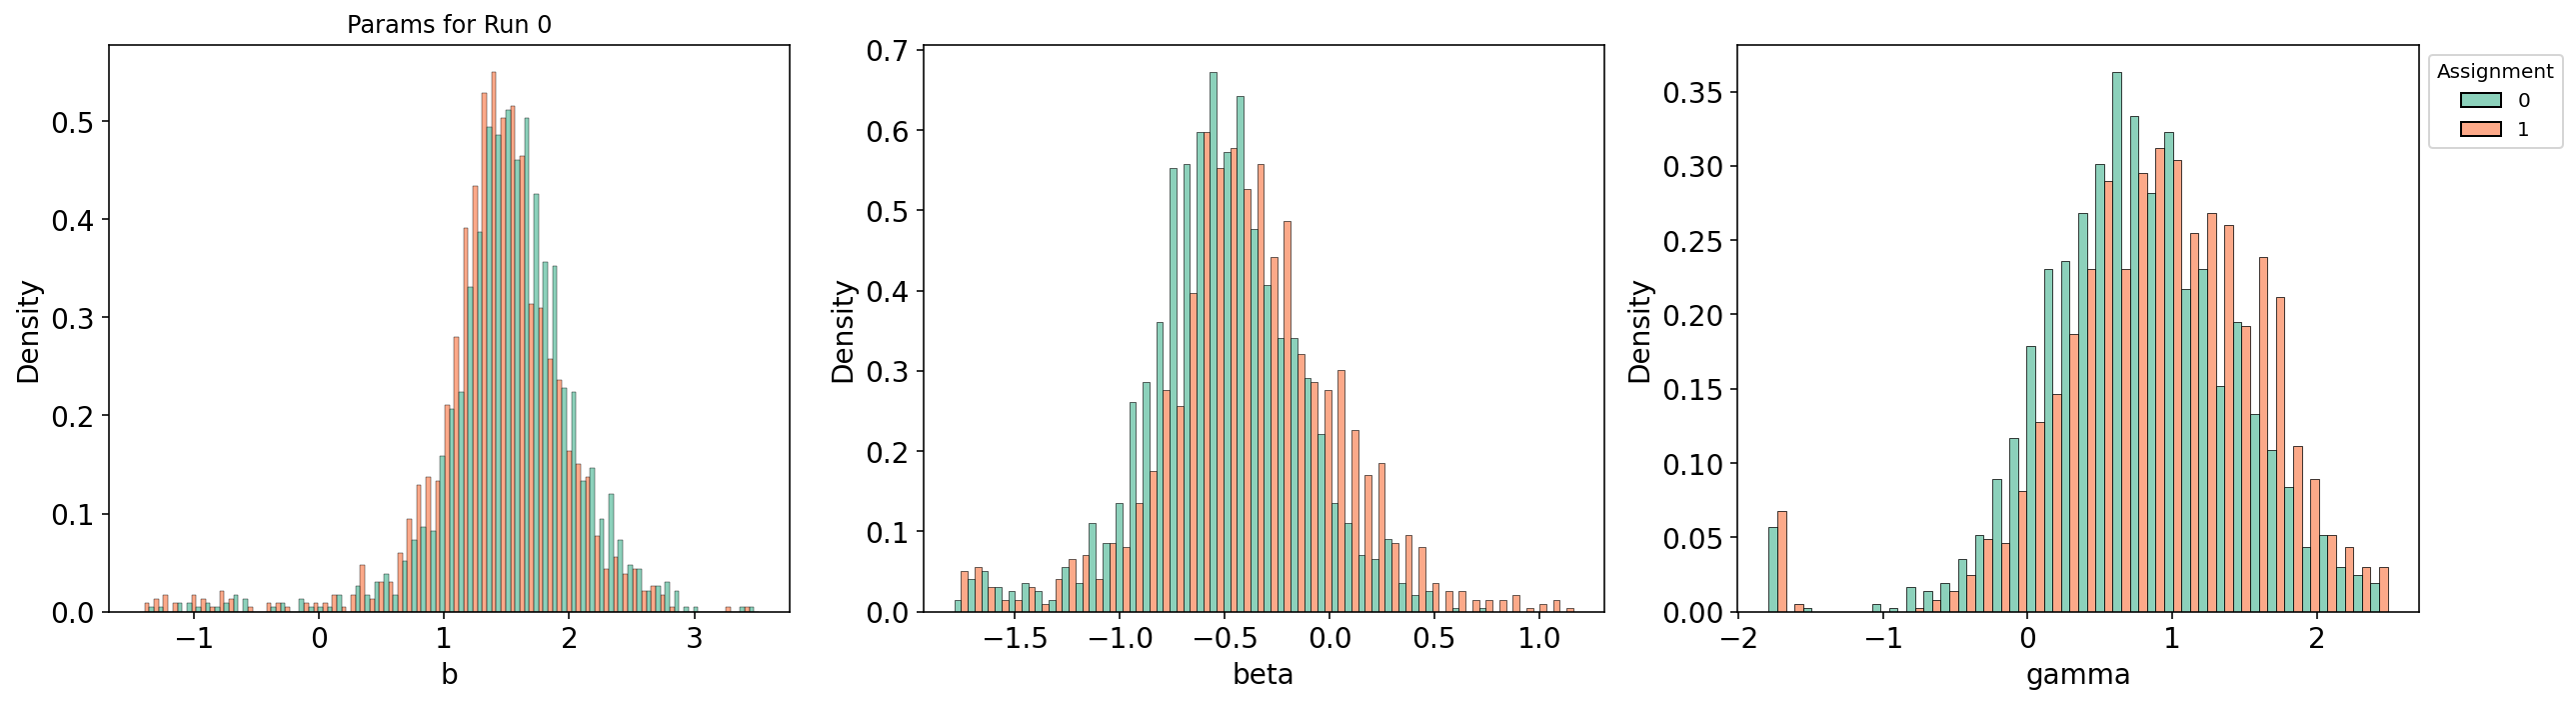

In [700]:
res=vis_params(par_vals_uncorrected,to_filt=True,title='Params for Run '+str(chosen),figsize=(18, 5))
    

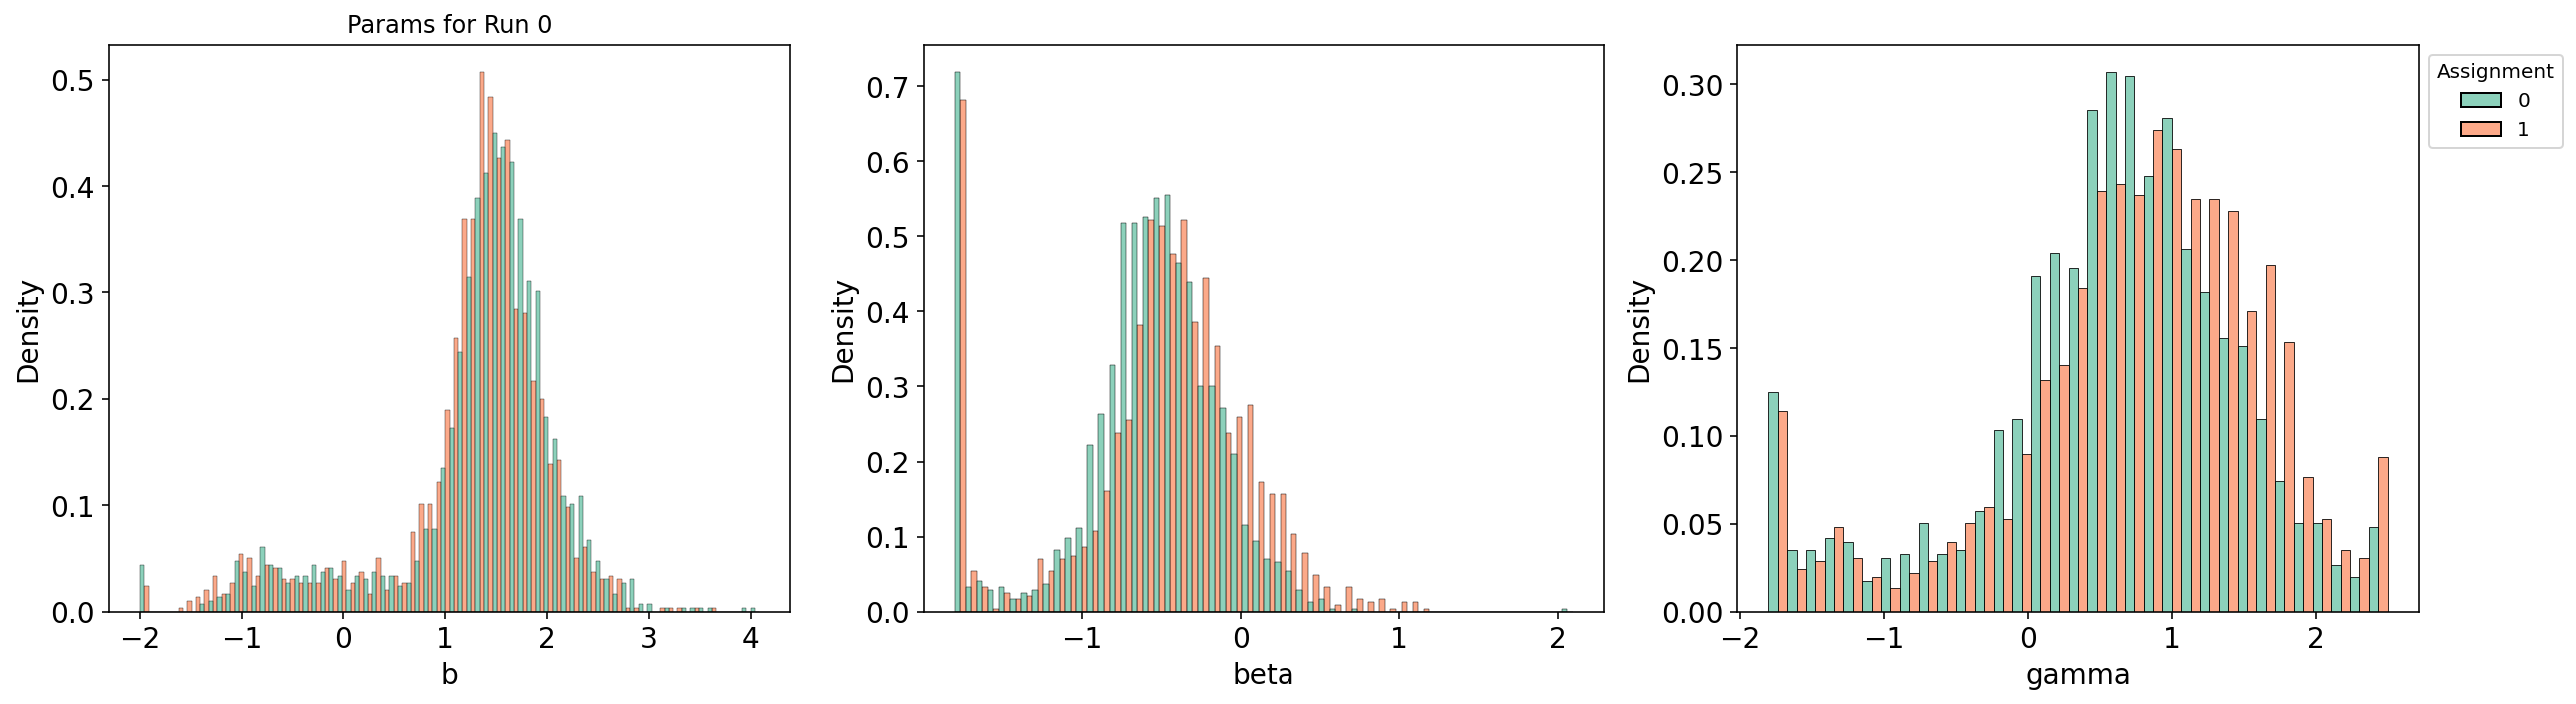

In [761]:
res=vis_params(par_vals_uncorrected,to_filt=False,title='Params for Run '+str(chosen),figsize=(18, 5))
    

In [762]:
#See Supp Fig 9.
toplot_marks = ['MAZ', 'AP1', 'SOX9' ,'E2F1', 'NFY','YY1',
               'GSTK1','ALDH1A3','KLHL24','GSN','AHNAK2','SOX4',
               'TIMP2','PSAP','CD24','FN1','IGFBP3','GRN',
               'DAB2','ATF','FOXF2','SAT1','TFPI2','MGP','THBS1',
               'FABP5','BDNF','PTPLAD1']


#toplot_marks = lit_genes
toplot_marks = np.unique(toplot_marks)

In [763]:
check_names = sr[chosen][0].gene_names
inds = [list(check_names).index(i) for i in toplot_marks if i in check_names]
print(len(inds))

13


In [764]:
#Create clustermap with approximated spliced means from inferred parameter (b/gamma  = s_mean)
toshape = np.array(res['b']+samp_ub[1]-res['gamma'])
toshape = toshape.reshape([len(sr[chosen]),n_genes])
toshape.shape

toshape = toshape[:,inds]


In [765]:
df = pd.DataFrame(np.log1p(10**(toshape.T)))
df.index = check_names[inds]


df.head()

0         1
AHNAK2   0.416598  0.321418
ALDH1A3  1.593909  1.211323
BDNF     0.339138  0.155897
CD24     1.266933  1.109066
FN1      0.803673  0.538084

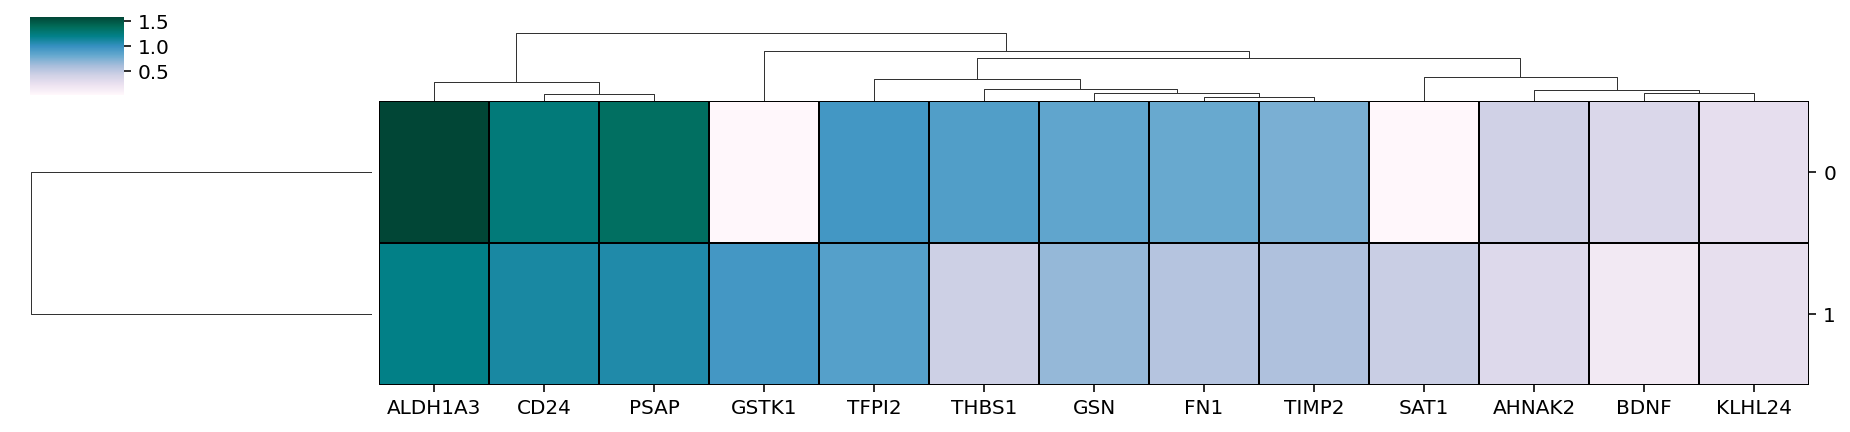

In [766]:
g=sns.clustermap(df.T,figsize=(13,3),cmap="PuBuGn",
               linewidths=0.01,linecolor='black')

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.savefig('meKMeans_clustermap_cancer_dt.pdf')

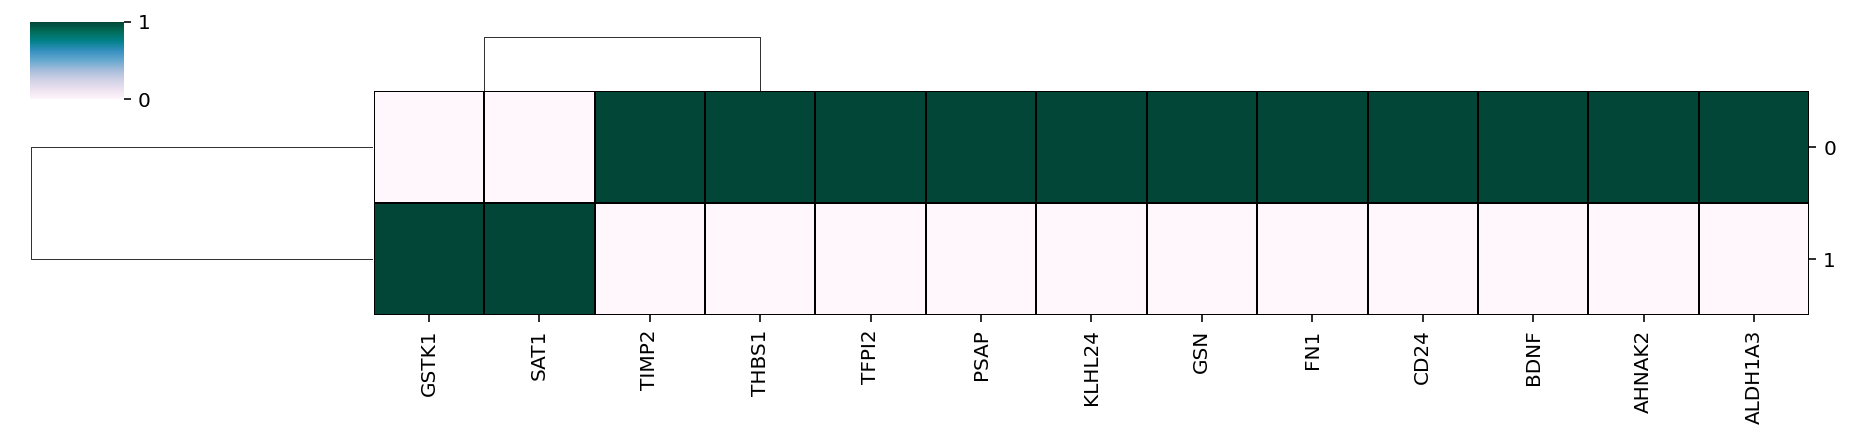

In [767]:
g=sns.clustermap(df.T,figsize=(13,3),standard_scale=1,cmap="PuBuGn",
               linewidths=0.01,linecolor='black')

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.savefig('meKMeans_clustermap_cancer_dt.pdf')

In [689]:
#Check raw expression of genes

In [722]:
#Mean per gene for all genes before filtering for genes
raw_clus = S[cf[-1],:]
print(raw_clus.shape)

#Do library-size normalization of spliced counts as is standard
tots = np.sum(raw_clus,axis=1)
divids = (1e4/tots)[:,None]
raw_clus = raw_clus*divids

print(raw_clus.shape)

assigned = len(sr[chosen])
mean_g = np.zeros((len(sr[chosen]),raw_clus.shape[1]))

for i in range(len(sr[chosen])):
    f = sr[chosen][i].filt
    
    mean_g[i,:] = np.mean(raw_clus[f,:],axis=0)

(10468, 36601)
(10468, 36601)


In [723]:
g_inds = [list(g_names).index(i) for i in toplot_marks if i in g_names]
df = pd.DataFrame(np.log1p(mean_g[:,g_inds].T))
df.index = g_names[g_inds]


df.head()

0         1
AHNAK2   0.498435  0.680803
ALDH1A3  1.763720  1.958922
BDNF     0.413265  0.362653
CD24     1.437133  1.839057
DAB2     0.303858  0.518860

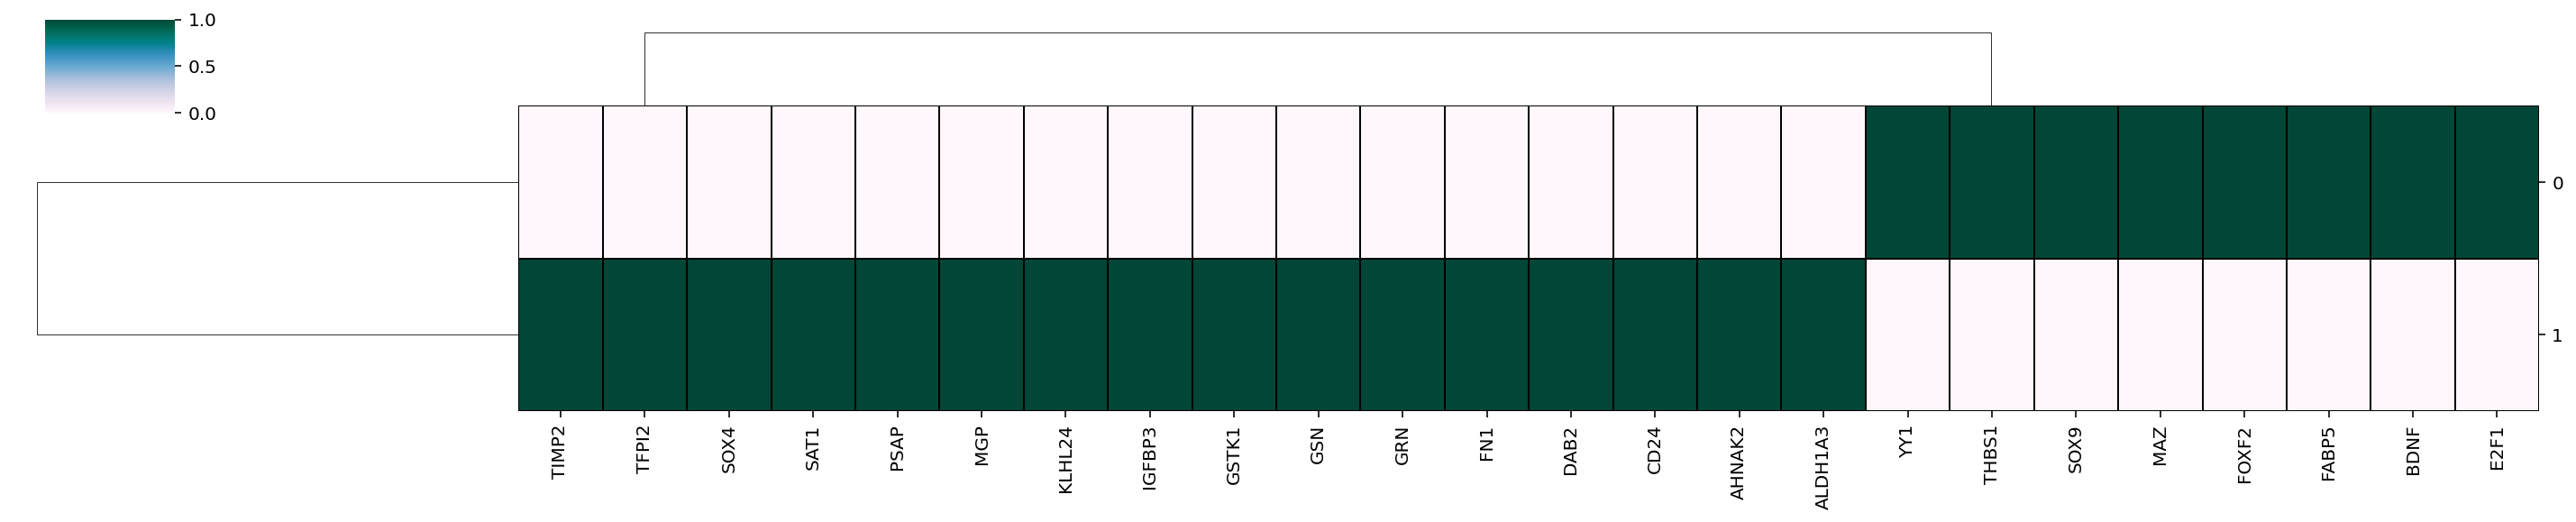

In [732]:
g=sns.clustermap(df.T,figsize=(20,4),standard_scale=1,cmap="PuBuGn",
               linewidths=0.01,linecolor='black') #standard_scale=1

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.savefig('mek_mean_clustermap_pbmc.pdf')

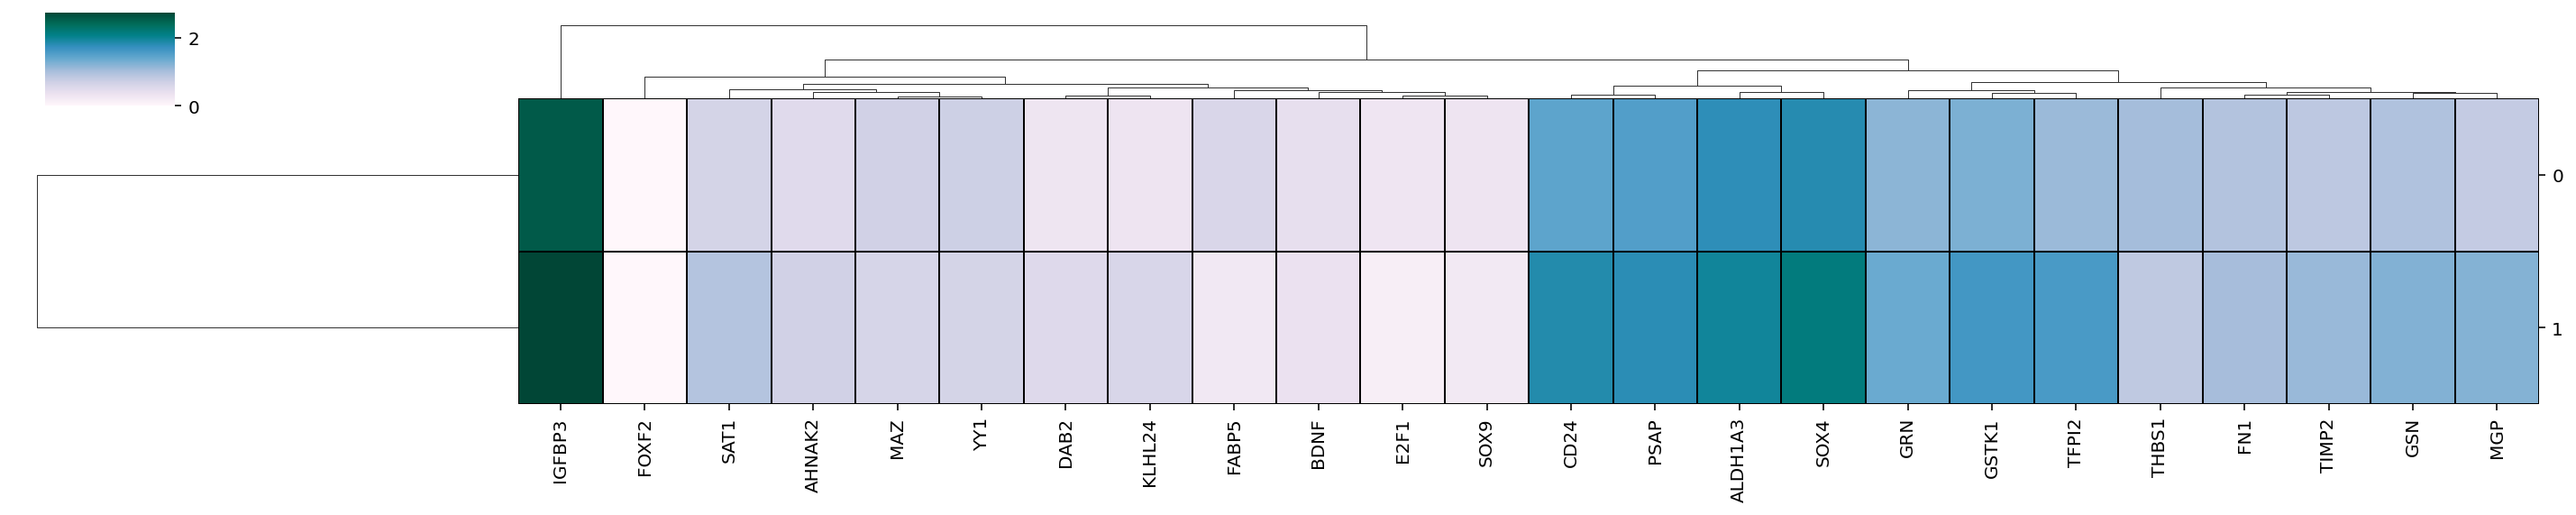

In [730]:
g=sns.clustermap(df.T,figsize=(20,4),cmap="PuBuGn",
               linewidths=0.01,linecolor='black') #standard_scale=1

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.savefig('mek_mean_clustermap_pbmc.pdf')

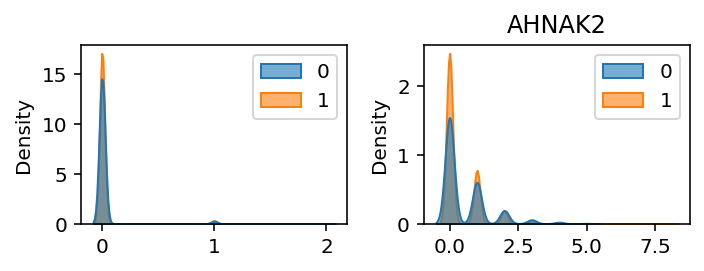

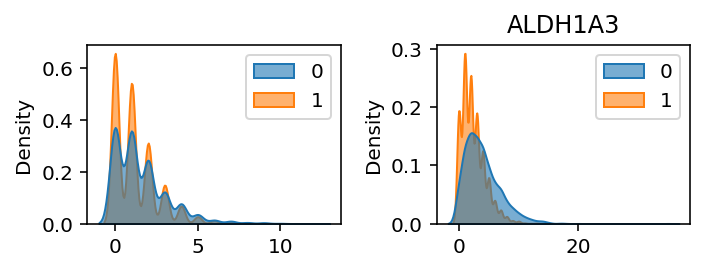

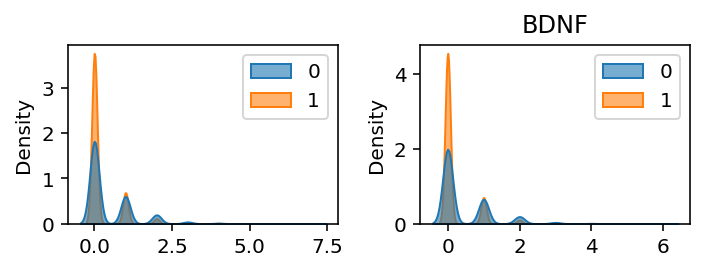

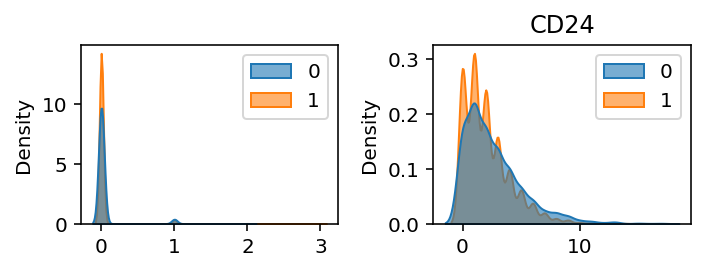

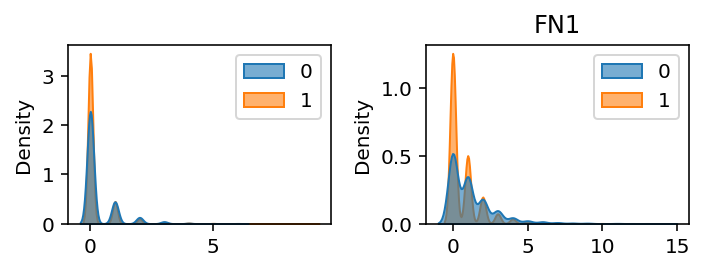

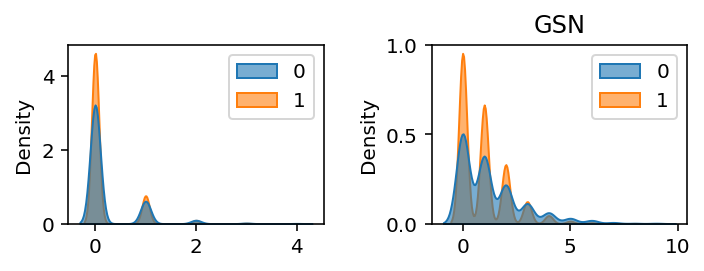

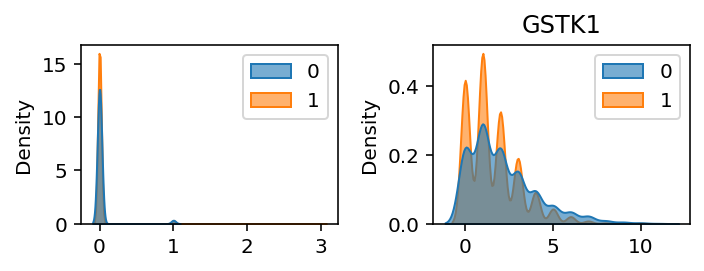

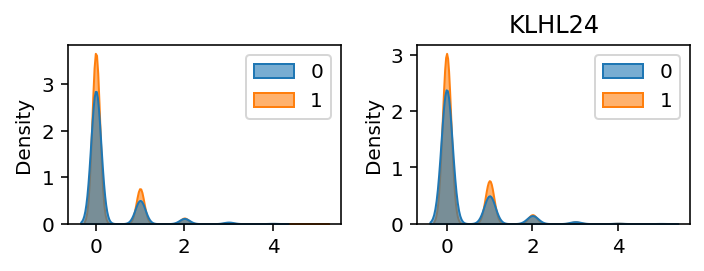

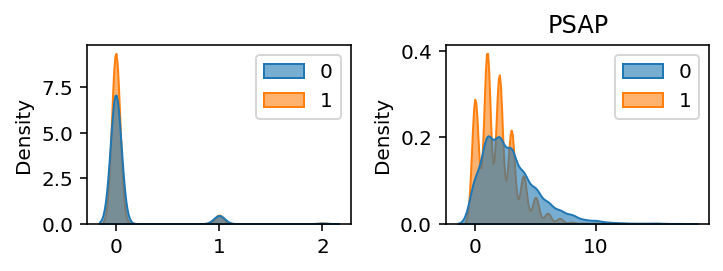

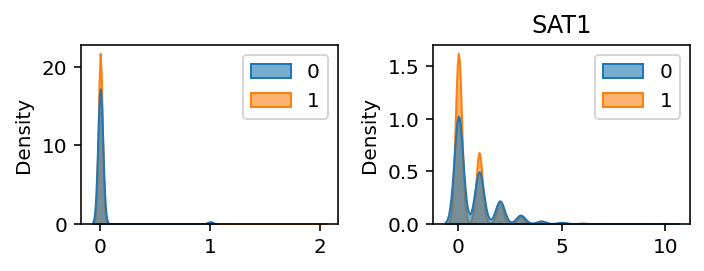

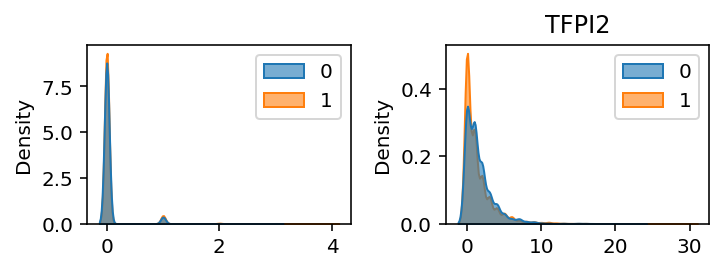

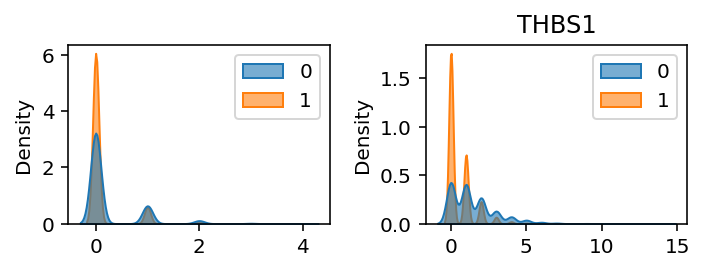

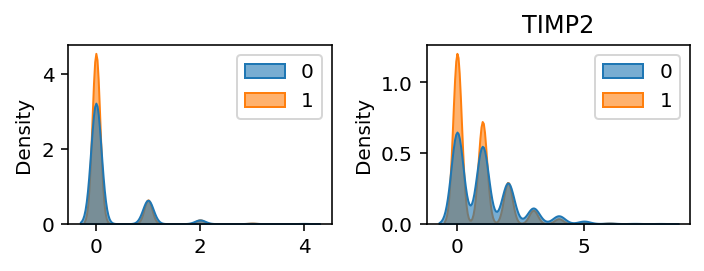

In [711]:
count_plot = toplot_marks 

s_l6 = sd[0].layers[1][:,sr[chosen][0].filt]
s_l23 = sd[0].layers[1][:,sr[chosen][1].filt]
u_l6 = sd[0].layers[0][:,sr[chosen][0].filt]
u_l23 = sd[0].layers[0][:,sr[chosen][1].filt]

labs = ['0']*s_l6.shape[1] + ['1']*s_l23.shape[1]
u = np.concatenate((u_l6,u_l23),axis=1)
s = np.concatenate((s_l6,s_l23),axis=1)

for i in count_plot:
    if i in list(sd[0].gene_names):
        ind = list(sd[0].gene_names).index(i)
        fig,ax = plt.subplots(1,2,figsize=(5,2))
        sns.kdeplot(u[ind,:],alpha=0.6,hue=pd.Categorical(labs),fill=True,
                    common_norm=False,ax=ax[0])
        sns.kdeplot(s[ind,:],alpha=0.6,hue=pd.Categorical(labs),fill=True,
                    common_norm=False,ax=ax[1])
        plt.title(i)
        plt.tight_layout()
        plt.show()


(1749,)
(1749,)


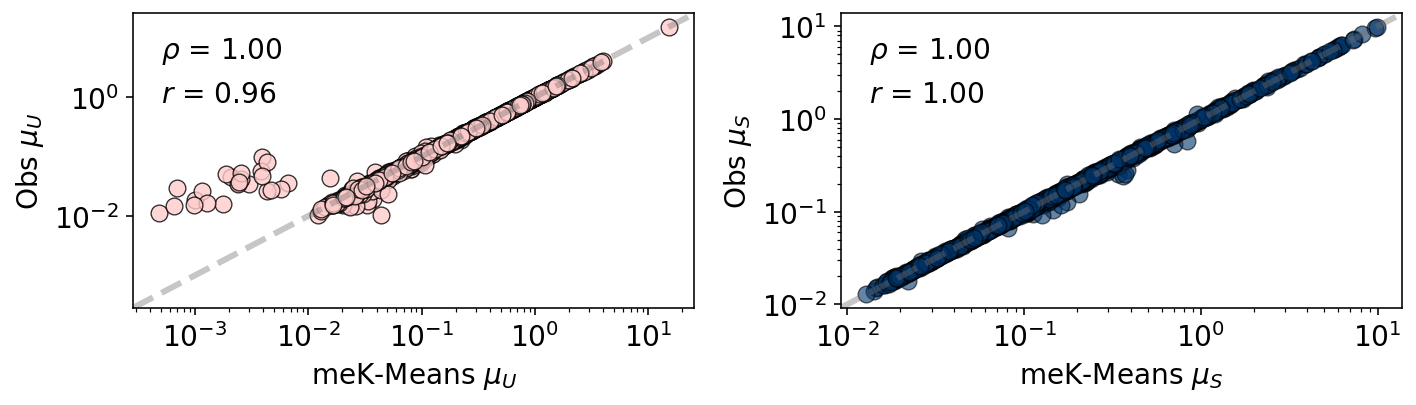

In [748]:
plot_means(sd,sr,res_inds=[0,0],clus_inds=[0,0],figsize=(10,3))

(1749,)
(1749,)


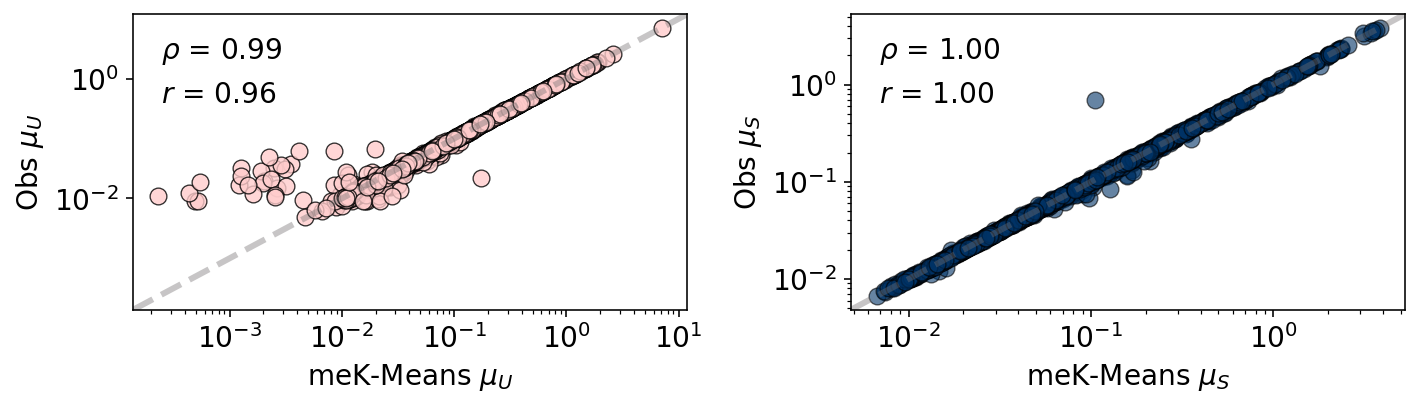

In [749]:
plot_means(sd,sr,res_inds=[0,0],clus_inds=[0,1],figsize=(10,3))

In [ ]:
#Check trends in inferred mu, observed mu, observed normalized mu ---> Cell size has effect here....

In [768]:
inf_muS_0 = par_vals_uncorrected[0,:,0]+samp_ub[1]-par_vals_uncorrected[0,:,2]
inf_muS_1 = par_vals_uncorrected[1,:,0]+samp_ub[1]-par_vals_uncorrected[1,:,2]

In [776]:
muS_0 = np.mean(sd[0].layers[1][:,sr[0][0].filt],axis=1)
muS_1 = np.mean(sd[0].layers[1][:,sr[0][1].filt],axis=1)

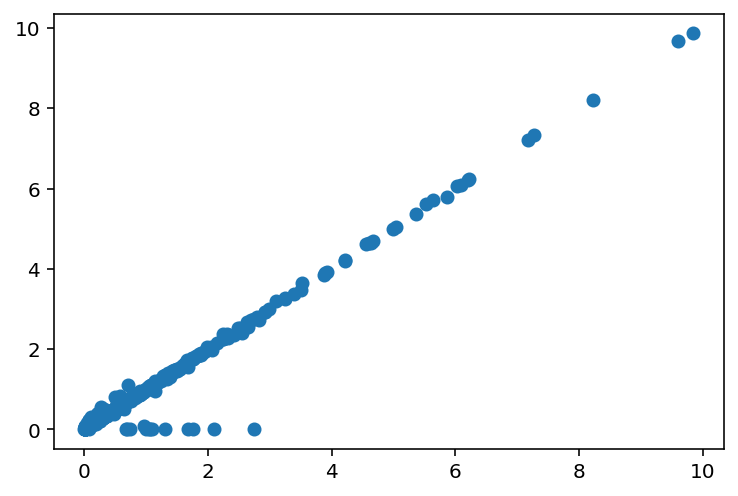

In [769]:
plt.scatter(np.mean(sd[0].layers[1][:,sr[0][0].filt],axis=1).flatten(),10**inf_muS_0)

In [791]:
test_g = 'GSTK1'
test_ind = list(sd[0].gene_names).index(test_g)
test_ind_2 = list(g_names).index(test_g)

In [792]:
print('inf_muS_0:'+str(10**inf_muS_0[test_ind]))
print('inf_muS_1:'+str(10**inf_muS_1[test_ind]))
print()
print('muS_0:'+str(muS_0[test_ind]))
print('muS_1:'+str(muS_1[test_ind]))

inf_muS_0:0.01883649089489801
inf_muS_1:1.5761265802012832

muS_0:2.101388440426219
muS_1:1.5731922398589064


In [793]:
print('normS_0:'+str(mean_g[0,test_ind_2]))
print('normS_1:'+str(mean_g[1,test_ind_2]))

normS_0:2.534288382789832
normS_1:4.070995884627082


In [782]:
S.shape

(11662, 36601)